# Objective

To define supply thresholds based on demand

# Import Packages

In [135]:
import pandas as pd
import glob
import numpy as np

import math
from datetime import datetime

from pyhive import presto

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Configs

In [2]:
city = 'Chennai'
service = 'Link'
start_date = '20230710'
end_date = '20230723'

PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/lchf_super_clusters/dse-demand-analysis/'

# Connection 

In [3]:
# conn = presto.connect(host='prime-trino.serving.data.production.internal',
#                       port=80,
#                       username='pallavi.chandra@rapido.bike')

# conn = presto.connect(host='presto.yoda.run',
#                       port=8080,
#                       username='pallavi.chandra@rapido.bike')


conn = presto.connect(
    host='presto-gateway.serving.data.plectrum.dev',
    port='443',
    protocol='https',
    catalog='hive',
    username='pallavi.chandra@rapido.bike'
)

# SQL Queries

In [4]:
fe_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service_name}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        COUNT(distinct order_id) AS rr_count,
        COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END) AS net_count
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service_name}')
        AND city_name = '{city}'

    GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        COALESCE(rr_tbl.rr_count,0) AS rr_count,
        COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        SUM(fe_count) AS fe_count,
        SUM(rr_count) AS rr_count,
        SUM(net_count) AS net_count,
        100.0*SUM(rr_count)/SUM(fe_count) AS FE2RR,
        100.0*SUM(net_count)/SUM(rr_count) AS G2N,
        100.0*SUM(net_count)/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where fe_count > 0 
    and rr_count > 0 
    GROUP BY 
        1,2,3,4,5
)

SELECT * FROM order_stat ORDER BY 1,2,3,4
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service_name = service,
    city = city)

In [5]:
print(fe_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

# Read SQL Queries

In [7]:
#rr_data = pd.read_sql(rr_query, conn)

#rr_data = pd.read_csv('~/Downloads/rr_Hyd_20220905_20221128.csv')

fe_data = pd.read_sql(fe_query, conn)

fe_data

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0       Chennai  20230710  2023-07-10                        0630         5   
1       Chennai  20230710  2023-07-10                        1145         6   
2       Chennai  20230710  2023-07-10                        1030         3   
3       Chennai  20230710  2023-07-10                        1200         9   
4       Chennai  20230710  2023-07-10                        1845         7   
...         ...       ...         ...            ...          ...       ...   
162543  Chennai  20230723  2023-07-23         puzhal         1815         6   
162544  Chennai  20230723  2023-07-23         puzhal         1415         5   
162545  Chennai  20230723  2023-07-23         puzhal         1845         3   
162546  Chennai  20230723  2023-07-23         puzhal         1930         2   
162547  Chennai  20230723  2023-07-23         puzhal         2215         5   

        rr_count  net_count FE2RR    G2N FE2Net  
0              1          0  20.0    0.0    0.0  
1              2          1  33.3   50.0   16.7  
2              1          1  33.3  100.0   33.3  
3              2          1  22.2   50.0   11.1  
4              1          1  14.3  100.0   14.3  
...          ...        ...   ...    ...    ...  
162543         1          0  16.7    0.0    0.0  
162544         1          0  20.0    0.0    0.0  
162545         1          0  33.3    0.0    0.0  
162546         1          1  50.0  100.0   50.0  
162547         1          0  20.0    0.0    0.0  

[162548 rows x 11 columns]

In [8]:
fe_data.to_csv('~/Downloads/fe_data_{city}_{service}_non_peak_analysis.csv'.format(
    city=city, service=service), index = False)

In [5]:
fe_data = pd.read_csv('~/Downloads/fe_data_{city}_{service}_non_peak_analysis.csv'.format(
    city=city, service=service))
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster  quarter_hour  fe_count  \
0  Chennai  20230710  2023-07-10            NaN           630         5   
1  Chennai  20230710  2023-07-10            NaN          1145         6   
2  Chennai  20230710  2023-07-10            NaN          1030         3   
3  Chennai  20230710  2023-07-10            NaN          1200         9   
4  Chennai  20230710  2023-07-10            NaN          1845         7   

   rr_count  net_count  FE2RR    G2N  FE2Net  
0         1          0   20.0    0.0     0.0  
1         2          1   33.3   50.0    16.7  
2         1          1   33.3  100.0    33.3  
3         2          1   22.2   50.0    11.1  
4         1          1   14.3  100.0    14.3

## Get time period

In [71]:
def get_period(hour):
    hour = int(hour)
    if (hour >= 8 and hour <= 11):
        return "morning_peak"
    elif (hour >= 17 and hour <= 21):
        return "evening_peak"
    elif (hour > 11 and hour < 17):
        return "afternoon"
    else:
        return "rest"

In [11]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['time_period'] = fe_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

In [12]:
fe_data['week_period'] = fe_data['yyyymmdd'].map(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A')
)

fe_data

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0       Chennai  20230710  2023-07-10            NaN         0630         5   
1       Chennai  20230710  2023-07-10            NaN         1145         6   
2       Chennai  20230710  2023-07-10            NaN         1030         3   
3       Chennai  20230710  2023-07-10            NaN         1200         9   
4       Chennai  20230710  2023-07-10            NaN         1845         7   
...         ...       ...         ...            ...          ...       ...   
162543  Chennai  20230723  2023-07-23         puzhal         1815         6   
162544  Chennai  20230723  2023-07-23         puzhal         1415         5   
162545  Chennai  20230723  2023-07-23         puzhal         1845         3   
162546  Chennai  20230723  2023-07-23         puzhal         1930         2   
162547  Chennai  20230723  2023-07-23         puzhal         2215         5   

        rr_count  net_count  FE2RR    G2N  FE2Net   time_period week_period  
0              1          0   20.0    0.0     0.0          rest      Monday  
1              2          1   33.3   50.0    16.7  morning_peak      Monday  
2              1          1   33.3  100.0    33.3  morning_peak      Monday  
3              2          1   22.2   50.0    11.1     afternoon      Monday  
4              1          1   14.3  100.0    14.3  evening_peak      Monday  
...          ...        ...    ...    ...     ...           ...         ...  
162543         1          0   16.7    0.0     0.0  evening_peak      Sunday  
162544         1          0   20.0    0.0     0.0     afternoon      Sunday  
162545         1          0   33.3    0.0     0.0  evening_peak      Sunday  
162546         1          1   50.0  100.0    50.0  evening_peak      Sunday  
162547         1          0   20.0    0.0     0.0          rest      Sunday  

[162548 rows x 13 columns]

In [13]:
fe_data_filtered = fe_data[fe_data['time_period'] != 'rest']

In [14]:
fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
fe_data_filtered['pickup_cluster'] = fe_data_filtered['pickup_cluster'].astype(str)

fe_data_filtered = fe_data_filtered.fillna(0)
fe_data_filtered = fe_data_filtered.dropna()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [15]:
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Chennai  20230710  2023-07-10            NaN         0630         5   
1  Chennai  20230710  2023-07-10            NaN         1145         6   
2  Chennai  20230710  2023-07-10            NaN         1030         3   
3  Chennai  20230710  2023-07-10            NaN         1200         9   
4  Chennai  20230710  2023-07-10            NaN         1845         7   

   rr_count  net_count  FE2RR    G2N  FE2Net   time_period week_period  
0         1          0   20.0    0.0     0.0          rest      Monday  
1         2          1   33.3   50.0    16.7  morning_peak      Monday  
2         1          1   33.3  100.0    33.3  morning_peak      Monday  
3         2          1   22.2   50.0    11.1     afternoon      Monday  
4         1          1   14.3  100.0    14.3  evening_peak      Monday

In [16]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['quarter_hour'] = fe_data['quarter_hour'].astype(str)

fe_data['hour'] = fe_data['quarter_hour'].str[0:2]

In [17]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')

In [18]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

In [19]:
cluster_temporal_stats.head()

pickup_cluster hour week_period  total_fe_count  total_rr_count  \
0                 Adambakkam   00      Friday              19              10   
23058  Vadapalani Thirunagar   00      Monday              46              15   
23059  Vadapalani Thirunagar   00    Saturday              63              25   
23060  Vadapalani Thirunagar   00      Sunday              82              22   
23061  Vadapalani Thirunagar   00    Thursday              42              21   

       total_net_orders  fe_rr_ratio  g2n_ratio  
0                     5    50.000000  45.454545  
23058                 9    31.914894  56.250000  
23059                18    39.062500  69.230769  
23060                16    26.506024  69.565217  
23061                14    48.837209  63.636364

In [20]:
fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [21]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'time_period', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('pickup_cluster')


cluster_temporal_stats.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0      Adambakkam   afternoon      Friday            1204             290   
27     Adambakkam        rest   Wednesday             468             171   
26     Adambakkam        rest     Tuesday             501             183   
25     Adambakkam        rest    Thursday             698             238   
24     Adambakkam        rest      Sunday             450             129   

    total_net_orders  
0                194  
27               124  
26               116  
25               111  
24                93

In [22]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [23]:
lower_quantile_threshold_list = [0.25, 0.20, 0.15, 0.12, 0.1]
higher_quantile_threshold_list = [0.75, 0.80, 0.85, 0.87, 0.9]
temporal_stats_for_threshold = pd.DataFrame({})

In [24]:
## check 
temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.25)),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.75)),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.20)),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.80))
    ).reset_index()
    
temporal_stats_for_each_threshold.head()

pickup_cluster   time_period  lower_g2n_threshold  higher_g2n_threshold  \
0     Adambakkam     afternoon            70.314526             74.067164   
1     Adambakkam  evening_peak            73.437118             75.843394   
2     Adambakkam  morning_peak            39.799506             58.195963   
3     Adambakkam          rest            52.823747             68.696060   
4          Adyar     afternoon            66.763127             69.435140   

   lower_fe2rr_threshold  higher_fe2rr_threshold  
0              19.517234               23.884211  
1              18.132159               26.583157  
2              21.956587               23.416348  
3              31.848441               36.043616  
4              18.874140               22.839259

In [25]:
temporal_stats_for_threshold = pd.DataFrame()

for i in range(0, len(lower_quantile_threshold_list), 1):
    
    lower_g2n_threshold_str = 'lower_g2n_threshold_' + str(lower_quantile_threshold_list[i])
    higher_g2n_threshold_str = 'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])
    lower_fe2rr_threshold_str = 'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])
    higher_fe2rr_threshold_str = 'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])
    print(lower_quantile_threshold_list[i])

    temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i])),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i]))
    ).reset_index()

    temporal_stats_for_each_threshold.rename(
        columns={'lower_g2n_threshold': lower_g2n_threshold_str, 
                 'higher_g2n_threshold': higher_g2n_threshold_str,
                 'lower_fe2rr_threshold': lower_fe2rr_threshold_str,
                 'higher_fe2rr_threshold': higher_fe2rr_threshold_str}, 
        inplace=True)
    
    #print(temporal_stats_for_each_threshold.head())
    
    #temporal_stats_for_threshold = pd.concat([temporal_stats_for_threshold, temporal_stats_for_each_threshold], axis=1)
    
    temporal_stats_for_each_threshold.to_csv(
        '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Hyderabad/Link/{city}_{service}_temporal_stats_for_each_threshold_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv'.format(
            city = city, 
            service=service), index=False)
    
filepath = "/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Hyderabad/Link"
filenames = glob.glob(filepath + "/*.csv")


li = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
    print(li)

frame = pd.concat(li, axis=1)

        


0.25
0.2
0.15
0.12
0.1
[      Unnamed: 0                       cluster           hex_id
0              0        Shamshabad 2 - Airport  8860b526adfffff
1              1        Shamshabad 2 - Airport  8860a25109fffff
2              2  Jeedimetla Industrial Estate  8860b19459fffff
3              3                      Pocharam  8860b52f55fffff
4              4                  Kukatpally 3  8860b196d7fffff
...          ...                           ...              ...
2283        2283                      Chilkoor  8860a24063fffff
2284        2284                      Chilkoor  8860a241a5fffff
2285        2285                      Chilkoor  8860a24225fffff
2286        2286                      Chilkoor  8860a24a91fffff
2287        2287                      Chilkoor  8860a24a97fffff

[2288 rows x 3 columns]]
[      Unnamed: 0                       cluster           hex_id
0              0        Shamshabad 2 - Airport  8860b526adfffff
1              1        Shamshabad 2 - Airport  8860a

In [26]:
frame.describe()

Unnamed: 0    Unnamed: 0      yyyymmdd  quarter_hour  gross_orders  \
count  2288.00000  1.001494e+06  1.001494e+06  1.001494e+06  1.001494e+06   
mean   1143.50000  5.007465e+05  2.023072e+07  1.328290e+03  2.737002e+00   
std     660.63303  2.891066e+05  4.020962e+00  6.119222e+02  4.906983e+00   
min       0.00000  0.000000e+00  2.023071e+07  0.000000e+00  0.000000e+00   
25%     571.75000  2.503732e+05  2.023071e+07  9.000000e+02  0.000000e+00   
50%    1143.50000  5.007465e+05  2.023072e+07  1.345000e+03  1.000000e+00   
75%    1715.25000  7.511198e+05  2.023072e+07  1.830000e+03  3.000000e+00   
max    2287.00000  1.001493e+06  2.023072e+07  2.345000e+03  1.690000e+02   

         net_orders  mean_distance        demand        supply  \
count  1.001494e+06   1.001494e+06  1.001494e+06  1.001494e+06   
mean   1.726095e+00   4.450447e+00  2.808043e+00  2.454372e+00   
std    3.202316e+00   6.803685e+00  5.074456e+00  7.199658e+00   
min    0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00   0.000000e+00  0.000000e+00  1.000000e+00   
50%    1.000000e+00   4.022000e+00  1.000000e+00  1.000000e+00   
75%    2.000000e+00   6.335500e+00  3.000000e+00  3.000000e+00   
max    1.110000e+02   4.634739e+03  1.890000e+02  3.090000e+02   

       lower_g2n_threshold_0.25  ...  lower_fe2rr_threshold_0.15  \
count                636.000000  ...                  636.000000   
mean                  53.559649  ...                   22.413966   
std                   15.850308  ...                    5.874695   
min                    0.000000  ...                    7.366851   
25%                   45.814786  ...                   17.953533   
50%                   57.949780  ...                   21.435671   
75%                   64.703210  ...                   26.230161   
max                   79.091540  ...                   47.500000   

       higher_fe2rr_threshold_0.85  lower_g2n_threshold_0.1  \
count                   636.000000               636.000000   
mean                     29.844643                49.645598   
std                       8.185566                16.057502   
min                      17.611378                 0.000000   
25%                      24.202038                40.945942   
50%                      28.104497                53.163677   
75%                      33.144764                61.755674   
max                      77.083333                75.476190   

       higher_g2n_threshold_0.9  lower_fe2rr_threshold_0.1  \
count                636.000000                 636.000000   
mean                  66.688813                  21.447067   
std                   12.869375                   5.694221   
min                    0.000000                   6.962242   
25%                   63.765656                  17.123214   
50%                   70.135631                  20.439333   
75%                   74.703645                  25.191390   
max                   86.646181                  45.000000   

       higher_fe2rr_threshold_0.9  lower_g2n_threshold_0.12  \
count                  636.000000                636.000000   
mean                    30.477133                 50.327987   
std                      8.618626                 16.044767   
min                     18.210217                  0.000000   
25%                     24.666127                 41.893388   
50%                     28.640596                 54.025032   
75%                     33.768744                 62.176908   
max                     79.166667                 76.404762   

       higher_g2n_threshold_0.87  lower_fe2rr_threshold_0.12  \
count                 636.000000                  636.000000   
mean                   65.998862                   21.833826   
std                    13.073590                    5.752193   
min                     0.000000                    7.124085   
25%                    62.963659                   17.481982   
50%                    69.

In [27]:
frame.head(100)

Unnamed: 0                       cluster           hex_id  Unnamed: 0  \
0          0.0        Shamshabad 2 - Airport  8860b526adfffff           0   
1          1.0        Shamshabad 2 - Airport  8860a25109fffff           1   
2          2.0  Jeedimetla Industrial Estate  8860b19459fffff           2   
3          3.0                      Pocharam  8860b52f55fffff           3   
4          4.0                  Kukatpally 3  8860b196d7fffff           4   
..         ...                           ...              ...         ...   
95        95.0                    Nizampet 3  8860a24949fffff          95   
96        96.0                  Patancheruvu  8860a248e1fffff          96   
97        97.0                  Balaji Nagar  8860b192d1fffff          97   
98        98.0                  Shamshabad 3  8860a25069fffff          98   
99        99.0        Shamshabad 2 - Airport  8860b524e3fffff          99   

           service_detail_id  yyyymmdd  quarter_hour           hex_id  \
0   574013f14fdf4798208bba26  20230710             0  8860a24909fffff   
1   574013f14fdf4798208bba26  20230710             0  8860a24a2dfffff   
2   574013f14fdf4798208bba26  20230710             0  8860a24a63fffff   
3   574013f14fdf4798208bba26  20230710             0  8860a24b1dfffff   
4   574013f14fdf4798208bba26  20230710             0  8860a24b33fffff   
..                       ...       ...           ...              ...   
95  574013f14fdf4798208bba26  20230710           100  8860b52519fffff   
96  574013f14fdf4798208bba26  20230710           100  8860b52c81fffff   
97  574013f14fdf4798208bba26  20230710           100  8860b52c97fffff   
98  574013f14fdf4798208bba26  20230710           100  8860b52ce7fffff   
99  574013f14fdf4798208bba26  20230710           100  8860b52e85fffff   

    gross_orders  net_orders  ...  lower_g2n_threshold_0.1  \
0              1           1  ...                68.109966   
1              3           1  ...                72.423712   
2              9           4  ...                35.108549   
3              1           1  ...                46.120077   
4              1           1  ...                65.765439   
..           ...         ...  ...                      ...   
95             1           0  ...                23.968719   
96             4           1  ...                65.417237   
97            18           2  ...                57.689511   
98             1           1  ...                52.201273   
99             1           0  ...                56.331553   

    higher_g2n_threshold_0.9  lower_fe2rr_threshold_0.1  \
0                  75.055004                  17.567823   
1                  76.467444                  15.736812   
2                  73.684280                  19.495067   
3                  71.760286                  30.519143   
4                  72.209962                  17.846346   
..                       ...                        ...   
95                 55.000000                  17.082015   
96                 74.423780                  19.188742   
97                 65.478581                  13.024812   
98                 73.212970                  25.135690   
99                 64.251989                  24.507230   

   higher_fe2rr_threshold_0.9  pickup_cluster   time_period  \
0                   24.026556      Adambakkam     afternoon   
1                   27.489526      Adambakkam  evening_peak   
2                   24.828063      Adambakkam  morning_peak   
3                   36.456732      Adambakkam          rest   
4                   23.280761           Adyar     afternoon   
..                        ...             ...           ...   
95                  30.331183  Beasant Avenue          rest   
96                  24.468824   Beasant Nagar     afternoon   
97                  25.418574   Beasant Nagar  evening_peak   
98                  30.254860   Beasant Nagar  morning_peak   
99                  33.896812   Beasant Nagar          

In [28]:
frame.columns

Index(['Unnamed: 0', 'cluster', 'hex_id', 'Unnamed: 0', 'service_detail_id',
       'yyyymmdd', 'quarter_hour', 'hex_id', 'gross_orders', 'net_orders',
       'mean_distance', 'demand', 'supply', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.25', 'higher_g2n_threshold_0.75',
       'lower_fe2rr_threshold_0.25', 'higher_fe2rr_threshold_0.75',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.2',
       'higher_g2n_threshold_0.8', 'lower_fe2rr_threshold_0.2',
       'higher_fe2rr_threshold_0.8', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.15', 'higher_g2n_threshold_0.85',
       'lower_fe2rr_threshold_0.15', 'higher_fe2rr_threshold_0.85',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.1',
       'higher_g2n_threshold_0.9', 'lower_fe2rr_threshold_0.1',
       'higher_fe2rr_threshold_0.9', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.12', 'higher_g2n_threshold_0.87',
       'lower_fe2rr_threshold_0.12', 'hig

In [29]:
temporal_stats_for_threshold = frame.copy()

temporal_stats_for_threshold_filtered = temporal_stats_for_threshold[[
    'pickup_cluster','time_period','lower_g2n_threshold_0.1','higher_g2n_threshold_0.9',
    'lower_fe2rr_threshold_0.1','higher_fe2rr_threshold_0.9',
    'lower_g2n_threshold_0.12','higher_g2n_threshold_0.87','lower_fe2rr_threshold_0.12',
    'higher_fe2rr_threshold_0.87','lower_g2n_threshold_0.2','higher_g2n_threshold_0.8',
    'lower_fe2rr_threshold_0.2','higher_fe2rr_threshold_0.8','lower_g2n_threshold_0.15',
    'higher_g2n_threshold_0.85','lower_fe2rr_threshold_0.15','higher_fe2rr_threshold_0.85',
    'lower_g2n_threshold_0.25','higher_g2n_threshold_0.75','lower_fe2rr_threshold_0.25',
    'higher_fe2rr_threshold_0.75']]

temporal_stats_for_threshold_filtered.head()

pickup_cluster pickup_cluster pickup_cluster pickup_cluster pickup_cluster  \
0     Adambakkam     Adambakkam     Adambakkam     Adambakkam     Adambakkam   
1     Adambakkam     Adambakkam     Adambakkam     Adambakkam     Adambakkam   
2     Adambakkam     Adambakkam     Adambakkam     Adambakkam     Adambakkam   
3     Adambakkam     Adambakkam     Adambakkam     Adambakkam     Adambakkam   
4          Adyar          Adyar          Adyar          Adyar          Adyar   

    time_period   time_period   time_period   time_period   time_period  ...  \
0     afternoon     afternoon     afternoon     afternoon     afternoon  ...   
1  evening_peak  evening_peak  evening_peak  evening_peak  evening_peak  ...   
2  morning_peak  morning_peak  morning_peak  morning_peak  morning_peak  ...   
3          rest          rest          rest          rest          rest  ...   
4     afternoon     afternoon     afternoon     afternoon     afternoon  ...   

   lower_fe2rr_threshold_0.2  higher_fe2rr_threshold_0.8  \
0                  19.517234                   23.884211   
1                  18.132159                   26.583157   
2                  21.956587                   23.416348   
3                  31.848441                   36.043616   
4                  18.874140                   22.839259   

   lower_g2n_threshold_0.15  higher_g2n_threshold_0.85  \
0                 68.831615                  74.733900   
1                 72.629738                  76.403293   
2                 35.409303                  70.965980   
3                 46.362655                  71.593918   
4                 66.237445                  71.158081   

   lower_fe2rr_threshold_0.15  higher_fe2rr_threshold_0.85  \
0                   18.328898                    24.006639   
1                   16.374773                    27.018974   
2                   21.276051                    23.779719   
3                   31.477163                    36.454820   
4                   18.199988                    23.093946   

   lower_g2n_threshold_0.25  higher_g2n_threshold_0.75  \
0                 70.314526                  74.067164   
1                 73.437118                  75.843394   
2                 39.799506                  58.195963   
3                 52.823747                  68.696060   
4                 66.763127                  69.435140   

   lower_fe2rr_threshold_0.25  higher_fe2rr_threshold_0.75  
0                   20.919202                    23.710526  
1                   20.449256                    26.164707  
2                   22.086899                    23.395463  
3                   31.926348                    35.427766  
4                   19.708547                    22.550636  

[5 rows x 30 columns]

In [32]:
# drop duplicate column names
temporal_stats_for_threshold_filtered2 = temporal_stats_for_threshold_filtered.T.drop_duplicates().T

temporal_stats_for_threshold_filtered2.head()

pickup_cluster   time_period lower_g2n_threshold_0.1  \
0     Adambakkam     afternoon                   68.11   
1     Adambakkam  evening_peak                 72.4237   
2     Adambakkam  morning_peak                 35.1085   
3     Adambakkam          rest                 46.1201   
4          Adyar     afternoon                 65.7654   

  higher_g2n_threshold_0.9 lower_fe2rr_threshold_0.1  \
0                   75.055                   17.5678   
1                  76.4674                   15.7368   
2                  73.6843                   19.4951   
3                  71.7603                   30.5191   
4                    72.21                   17.8463   

  higher_fe2rr_threshold_0.9 lower_g2n_threshold_0.12  \
0                    24.0266                  68.3986   
1                    27.4895                  72.5061   
2                    24.8281                  35.2289   
3                    36.4567                  46.2171   
4                    23.2808                  65.9542   

  higher_g2n_threshold_0.87 lower_fe2rr_threshold_0.12  \
0                   74.8623                    17.8723   
1                    76.429                     15.992   
2                   72.0533                    20.2075   
3                   71.6605                    30.9024   
4                   71.5788                    17.9878   

  higher_fe2rr_threshold_0.87  ... lower_fe2rr_threshold_0.2  \
0                     24.0146  ...                   19.5172   
1                     27.2072  ...                   18.1322   
2                     24.1991  ...                   21.9566   
3                     36.4556  ...                   31.8484   
4                     23.1687  ...                   18.8741   

  higher_fe2rr_threshold_0.8 lower_g2n_threshold_0.15  \
0                    23.8842                  68.8316   
1                    26.5832                  72.6297   
2                    23.4163                  35.4093   
3                    36.0436                  46.3627   
4                    22.8393                  66.2374   

  higher_g2n_threshold_0.85 lower_fe2rr_threshold_0.15  \
0                   74.7339                    18.3289   
1                   76.4033                    16.3748   
2                    70.966                    21.2761   
3                   71.5939                    31.4772   
4                   71.1581                       18.2   

  higher_fe2rr_threshold_0.85 lower_g2n_threshold_0.25  \
0                     24.0066                  70.3145   
1                      27.019                  73.4371   
2                     23.7797                  39.7995   
3                     36.4548                  52.8237   
4                     23.0939                  66.7631   

  higher_g2n_threshold_0.75 lower_fe2rr_threshold_0.25  \
0                   74.0672                    20.9192   
1                   75.8434                    20.4493   
2                    58.196                    22.0869   
3                   68.6961                    31.9263   
4                   69.4351                    19.7085   

  higher_fe2rr_threshold_0.75  
0                     23.7105  
1                     26.1647  
2                     23.3955  
3                     35.4278  
4                     22.5506  

[5 rows x 22 columns]

In [33]:
cluster_temporal_stats_with_threshold = pd.merge(
    cluster_temporal_stats, temporal_stats_for_threshold_filtered2, left_on = [
    'pickup_cluster', 'time_period'], right_on = [
    'pickup_cluster', 'time_period'], how = 'left')

cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     Adambakkam   afternoon      Friday            1204             290   
1     Adambakkam        rest   Wednesday             468             171   
2     Adambakkam        rest     Tuesday             501             183   
3     Adambakkam        rest    Thursday             698             238   
4     Adambakkam        rest      Sunday             450             129   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               124    36.460554  72.093023                 46.1201   
2               116    36.454183  63.043478                 46.1201   
3               111    34.048641  46.443515                 46.1201   
4                93    28.603104  71.538462                 46.1201   

  higher_g2n_threshold_0.9  ... lower_fe2rr_threshold_0.2  \
0                   75.055  ...                   19.5172   
1                  71.7603  ...                   31.8484   
2                  71.7603  ...                   31.8484   
3                  71.7603  ...                   31.8484   
4                  71.7603  ...                   31.8484   

  higher_fe2rr_threshold_0.8 lower_g2n_threshold_0.15  \
0                    23.8842                  68.8316   
1                    36.0436                  46.3627   
2                    36.0436                  46.3627   
3                    36.0436                  46.3627   
4                    36.0436                  46.3627   

  higher_g2n_threshold_0.85 lower_fe2rr_threshold_0.15  \
0                   74.7339                    18.3289   
1                   71.5939                    31.4772   
2                   71.5939                    31.4772   
3                   71.5939                    31.4772   
4                   71.5939                    31.4772   

  higher_fe2rr_threshold_0.85 lower_g2n_threshold_0.25  \
0                     24.0066                  70.3145   
1                     36.4548                  52.8237   
2                     36.4548                  52.8237   
3                     36.4548                  52.8237   
4                     36.4548                  52.8237   

  higher_g2n_threshold_0.75 lower_fe2rr_threshold_0.25  \
0                   74.0672                    20.9192   
1                   68.6961                    31.9263   
2                   68.6961                    31.9263   
3                   68.6961                    31.9263   
4                   68.6961                    31.9263   

  higher_fe2rr_threshold_0.75  
0                     23.7105  
1                     35.4278  
2                     35.4278  
3                     35.4278  
4                     35.4278  

[5 rows x 28 columns]

In [34]:
cluster_temporal_stats_with_threshold.shape, cluster_temporal_stats.shape

((4432, 28), (4432, 8))

In [35]:
px.box(y = cluster_temporal_stats_with_threshold['fe_rr_ratio'])

In [36]:
px.box(y = cluster_temporal_stats_with_threshold['g2n_ratio'])

## Conclusion

We have list of thresholds that are at cluster, week_period, time_period level. 

In [ ]:
lower_quantile_threshold_list, higher_quantile_threshold_list

In [37]:
    for i in range(0, len(lower_quantile_threshold_list), 1):
        conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])
        fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])

        cluster_temporal_stats_with_threshold.loc[
            cluster_temporal_stats_with_threshold['fe_rr_ratio'] < cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])], conversion_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.fe_rr_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])]), conversion_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.fe_rr_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])])) & ((
                (cluster_temporal_stats_with_threshold.fe_rr_ratio) >= (
            cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(
                    lower_quantile_threshold_list[i])]))), conversion_category_str] = 'medium'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) < (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.g2n_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])])) & (
                                                      ((cluster_temporal_stats_with_threshold.g2n_ratio) >= (
                                                          cluster_temporal_stats_with_threshold[
                                                              'lower_g2n_threshold_' + str(
                                                                  lower_quantile_threshold_list[
                                                                      i])]))), fulfilment_category_str] = 'medium'

        cluster_temporal_stats_with_threshold['cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])] = (
                cluster_temporal_stats_with_threshold[
                    'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])] + '-' +
                cluster_temporal_stats_with_threshold[
                    'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])]
        )
        print(cluster_temporal_stats_with_threshold.shape)
        print(cluster_temporal_stats_with_threshold[conversion_category_str].value_counts())
        print(cluster_temporal_stats_with_threshold[fulfilment_category_str].value_counts())
        print('----------------------')


(4432, 31)
medium    1903
low       1266
high      1263
Name: conversion_category_0.25_0.75, dtype: int64
medium    1940
high      1254
low       1238
Name: fulfil_category_0.25_0.75, dtype: int64
----------------------
(4432, 34)
medium    1921
low       1257
high      1254
Name: conversion_category_0.2_0.8, dtype: int64
medium    1954
high      1248
low       1230
Name: fulfil_category_0.2_0.8, dtype: int64
----------------------
(4432, 37)
medium    3166
high       633
low        633
Name: conversion_category_0.15_0.85, dtype: int64
medium    3189
high       626
low        617
Name: fulfil_category_0.15_0.85, dtype: int64
----------------------
(4432, 40)
medium    3166
high       633
low        633
Name: conversion_category_0.12_0.87, dtype: int64
medium    3189
high       626
low        617
Name: fulfil_category_0.12_0.87, dtype: int64
----------------------
(4432, 43)
medium    3166
high       633
low        633
Name: conversion_category_0.1_0.9, dtype: int64
medium    3187
high 

In [38]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     Adambakkam   afternoon      Friday            1204             290   
1     Adambakkam        rest   Wednesday             468             171   
2     Adambakkam        rest     Tuesday             501             183   
3     Adambakkam        rest    Thursday             698             238   
4     Adambakkam        rest      Sunday             450             129   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               124    36.460554  72.093023                 46.1201   
2               116    36.454183  63.043478                 46.1201   
3               111    34.048641  46.443515                 46.1201   
4                93    28.603104  71.538462                 46.1201   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                   75.055  ...            high-low   
1                  71.7603  ...           high-high   
2                  71.7603  ...         high-medium   
3                  71.7603  ...          medium-low   
4                  71.7603  ...            low-high   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                       low   
1                          high                      high   
2                        medium                    medium   
3                        medium                    medium   
4                           low                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0              high-low                          high   
1             high-high                          high   
2         medium-medium                        medium   
3         medium-medium                        medium   
4            low-medium                           low   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                       low              high-low                        high   
1                      high             high-high                        high   
2                    medium         medium-medium                      medium   
3                    medium         medium-medium                      medium   
4                    medium            low-medium                         low   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                     low            high-low  
1                    high           high-high  
2                  medium       medium-medium  
3                  medium       medium-medium  
4                  medium          low-medium  

[5 rows x 43 columns]

In [39]:
cluster_temporal_stats_with_threshold.to_csv(
    '~/Downloads/cluster_temporal_stats_with_threshold_cf_category_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city = city, service = service, start_date = start_date, end_date = end_date))

## Conclusion

Categories created

In [40]:
for i in range(0, len(lower_quantile_threshold_list), 1):
    conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    cf_category_str = 'cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])

    category_wise_stats = cluster_temporal_stats_with_threshold.groupby(
        [cf_category_str, conversion_category_str, fulfilment_category_str]).agg(
        total_gross_orders=pd.NamedAgg('total_rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('total_net_orders', 'sum'),
        total_fe_count=pd.NamedAgg('total_fe_count', 'sum')
    ).reset_index()

    print('Total Unique Clusters: ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
    print(cluster_temporal_stats_with_threshold.pickup_cluster.nunique())

    print('Check count: time period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))
    
    print('Unique Clusters ')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        unique_clusters=pd.NamedAgg('pickup_cluster', lambda x: x.nunique())))
    

    print('Check count: time period, week period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period', 'week_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))

    print('Category Wise Stats')
    print('-----------------------------------')
    print(category_wise_stats.shape)
    print(category_wise_stats[conversion_category_str].value_counts())
    print(category_wise_stats[fulfilment_category_str].value_counts())

    total_gross_orders_all_cats = category_wise_stats['total_gross_orders'].sum()
    total_net_orders_all_cats = category_wise_stats['total_net_orders'].sum()
    total_fe_count_all_cats = category_wise_stats['total_fe_count'].sum()

    print('Gross orders Summary')
    print('Total Gross Orders: ', total_gross_orders_all_cats)
    print('Total Net Orders: ', total_net_orders_all_cats)
    print('Total FE count: ', total_fe_count_all_cats)
    print('------------------------------------------------')

    # Put in log
    category_wise_stats['fe_contribution'] = category_wise_stats['total_fe_count'] / total_fe_count_all_cats
    category_wise_stats['gross_order_contribution'] = category_wise_stats[
                                                          'total_gross_orders'] / total_gross_orders_all_cats
    category_wise_stats['net_order_contribution'] = category_wise_stats[
                                                        'total_net_orders'] / total_net_orders_all_cats

    category_wise_stats.to_csv(
        '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/category_ws_stats/{city}_{service}_category_wise_stats_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv'.format(city=city, service=service), index=False)
    
filepath = "/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/category_ws_stats"
filenames = glob.glob(filepath + "/*.csv")


category_ws_file_list = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    category_ws_file_list.append(df)
    
    print(category_ws_file_list)

category_ws_stats = pd.concat(category_ws_file_list, axis=1)

#     print('Gross orders Contribution Summary')
#     print('Gross Order Contribution: ', total_gross_orders_all_cats)
#     print('Net Orders Contribution: ', total_net_orders_all_cats)
#     print('FE Contribution: ', total_fe_count_all_cats)
#     print('------------------------------------------------')

Total Unique Clusters:  159
159
Check count: time period level
                                    count_combinations
cf_category_0.25_0.75 time_period                     
high-high             afternoon                     67
                      evening_peak                 121
                      morning_peak                  31
                      rest                         109
high-low              afternoon                     97
                      evening_peak                  34
                      morning_peak                 127
                      rest                          72
high-medium           afternoon                    152
                      evening_peak                 161
                      morning_peak                 158
                      rest                         134
low-high              afternoon                    108
                      evening_peak                  44
                      morning_peak                 190
  

Total Unique Clusters:  159
159
Check count: time period level
                                  count_combinations
cf_category_0.1_0.9 time_period                     
high-high           afternoon                     13
                    evening_peak                  31
                    morning_peak                   5
                    rest                          27
high-low            afternoon                     31
                    evening_peak                   5
                    morning_peak                  29
                    rest                          19
high-medium         afternoon                    115
                    evening_peak                 123
                    morning_peak                 124
                    rest                         111
low-high            afternoon                     48
                    evening_peak                   6
                    morning_peak                  74
                    rest            

8                0.539759  ]
[  cf_category_0.12_0.87 conversion_category_0.12_0.87  \
0             high-high                          high   
1              high-low                          high   
2           high-medium                          high   
3              low-high                           low   
4               low-low                           low   
5            low-medium                           low   
6           medium-high                        medium   
7            medium-low                        medium   
8         medium-medium                        medium   

  fulfil_category_0.12_0.87  total_gross_orders  total_net_orders  \
0                      high               20448             14977   
1                       low               24652             10934   
2                    medium              158640            100800   
3                      high               32749             24175   
4                       low               34273       

In [41]:
category_wise_stats.head()

cf_category_0.1_0.9 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0           high-high                        high                    high   
1            high-low                        high                     low   
2         high-medium                        high                  medium   
3            low-high                         low                    high   
4             low-low                         low                     low   

   total_gross_orders  total_net_orders  total_fe_count  fe_contribution  \
0               20448             14977           72392         0.012799   
1               24652             10934           91404         0.016160   
2              158640            100800          574759         0.101614   
3               32749             24175          183686         0.032475   
4               34273             20842          227774         0.040269   

   gross_order_contribution  net_order_contribution  
0                  0.015326                0.018022  
1                  0.018477                0.013157  
2                  0.118905                0.121295  
3                  0.024546                0.029090  
4                  0.025689                0.025080

In [42]:
category_ws_stats.head()

cf_category_0.12_0.87  conversion_category_0.12_0.87  \
0             high-high                           high   
1              high-low                           high   
2           high-medium                           high   
3              low-high                            low   
4               low-low                            low   

   fulfil_category_0.12_0.87  total_gross_orders  total_net_orders  \
0                       high               20448             14977   
1                        low               24652             10934   
2                     medium              158640            100800   
3                       high               32749             24175   
4                        low               34273             20842   

   total_fe_count  fe_contribution gross_order_contribution  \
0           72392         0.012799                 0.015326   
1           91404         0.016160                 0.018477   
2          574759         0.101614                 0.118905   
3          183686         0.032475                 0.024546   
4          227774         0.040269                 0.025689   

  net_order_contribution cf_category_0.2_0.8  ... net_order_contribution  \
0               0.018022           high-high  ...               0.018022   
1               0.013157            high-low  ...               0.013157   
2               0.121295         high-medium  ...               0.121295   
3               0.029090            low-high  ...               0.029090   
4               0.025080             low-low  ...               0.025080   

  cf_category_0.12_0.87  conversion_category_0.12_0.87  \
0             high-high                           high   
1              high-low                           high   
2           high-medium                           high   
3              low-high                            low   
4               low-low                            low   

   fulfil_category_0.12_0.87  total_gross_orders  total_net_orders  \
0                       high               20448             14977   
1                        low               24652             10934   
2                     medium              158640            100800   
3                       high               32749             24175   
4                        low               34273             20842   

   total_fe_count  fe_contribution gross_order_contribution  \
0           72392         0.012799                 0.015326   
1           91404         0.016160                 0.018477   
2          574759         0.101614                 0.118905   
3          183686         0.032475                 0.024546   
4          227774         0.040269                 0.025689   

  net_order_contribution  
0               0.018022  
1               0.013157  
2               0.121295  
3               0.029090  
4               0.025080  

[5 rows x 90 columns]

In [43]:
lh_segments = cluster_temporal_stats_with_threshold[(cluster_temporal_stats_with_threshold[
    'cf_category_0.25_0.75'] == 'low-high') & (cluster_temporal_stats_with_threshold[
    'time_period'] == 'afternoon')]

lh_segments.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
156         Alwarpet   afternoon      Sunday            1366             273   
184  Alwarthirunagar   afternoon      Sunday             859             124   
211         Ambattur   afternoon    Saturday            1637             301   
268      Ambattur OT   afternoon      Sunday             742             115   
295      Anakaputhur   afternoon    Saturday            2232             401   

     total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
156               212    19.970739  77.372263                 67.8461   
184                76    14.418605  60.800000                 38.1695   
211               224    18.376068  74.172185                 66.5767   
268                84    15.477793  72.413793                 64.1154   
295               237    17.957904  58.955224                 53.2231   

    higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
156                  78.3821  ...            low-high   
184                  62.9316  ...            low-high   
211                  73.0134  ...            low-high   
268                  72.6049  ...            low-high   
295                  60.0098  ...            low-high   

    conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
156                           low                    medium   
184                           low                    medium   
211                        medium                      high   
268                           low                    medium   
295                        medium                    medium   

    cf_category_0.15_0.85 conversion_category_0.12_0.87  \
156            low-medium                           low   
184            low-medium                           low   
211           medium-high                        medium   
268            low-medium                           low   
295         medium-medium                        medium   

    fulfil_category_0.12_0.87 cf_category_0.12_0.87  \
156                    medium            low-medium   
184                    medium            low-medium   
211                      high           medium-high   
268                    medium            low-medium   
295                    medium         medium-medium   

    conversion_category_0.1_0.9 fulfil_category_0.1_0.9 cf_category_0.1_0.9  
156                         low                  medium          low-medium  
184                         low                  medium          low-medium  
211                      medium                    high         medium-high  
268                         low                  medium          low-medium  
295                      medium                  medium       medium-medium  

[5 rows x 43 columns]

In [44]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     Adambakkam   afternoon      Friday            1204             290   
1     Adambakkam        rest   Wednesday             468             171   
2     Adambakkam        rest     Tuesday             501             183   
3     Adambakkam        rest    Thursday             698             238   
4     Adambakkam        rest      Sunday             450             129   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               124    36.460554  72.093023                 46.1201   
2               116    36.454183  63.043478                 46.1201   
3               111    34.048641  46.443515                 46.1201   
4                93    28.603104  71.538462                 46.1201   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                   75.055  ...            high-low   
1                  71.7603  ...           high-high   
2                  71.7603  ...         high-medium   
3                  71.7603  ...          medium-low   
4                  71.7603  ...            low-high   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                       low   
1                          high                      high   
2                        medium                    medium   
3                        medium                    medium   
4                           low                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0              high-low                          high   
1             high-high                          high   
2         medium-medium                        medium   
3         medium-medium                        medium   
4            low-medium                           low   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                       low              high-low                        high   
1                      high             high-high                        high   
2                    medium         medium-medium                      medium   
3                    medium         medium-medium                      medium   
4                    medium            low-medium                         low   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                     low            high-low  
1                    high           high-high  
2                  medium       medium-medium  
3                  medium       medium-medium  
4                  medium          low-medium  

[5 rows x 43 columns]

In [45]:
lh_segments.to_csv('~/Downloads/lh_segments_{city}_{service}_{start_date}_{end_date}.csv'.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date))

In [46]:
lh_segments.pickup_cluster.nunique()

93

---

## Defining supply thresholds

In [47]:
cluster_temporal_stats_hour_level = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level['fe_rr_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_rr_count'] / (cluster_temporal_stats_hour_level['total_fe_count'] + 1)
)

cluster_temporal_stats_hour_level['g2n_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_net_orders'] / (cluster_temporal_stats_hour_level['total_rr_count'] + 1)
)

## Mismatch query

to get demand and supply

In [48]:
mismatch_g2n_query = '''
    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
              AND ols.service_obj_service_name = '{service}'
              AND city_name = '{city}'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2, 3, 4, 5
        ),
             mismatch AS (
                 SELECT nm.service_detail_id, 
                        nm.yyyymmdd,
                        nm.quarter_hour,
                        nm.hex_id,
                        service_level,
                        nm.rr_counts           as demand,
                        nm.idle_captain_counts_probabilistic as supply
                 FROM hive.datasets.marketplace_mismatch_realtime nm
                          JOIN datasets.city_cluster_hex cch ON cch.hex_id = nm.hex_id
                     AND cch.city = '{city}'
                 WHERE yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
                   AND service_level = '{service}'
             )
        SELECT
               CASE WHEN m.service_detail_id IS NOT NULL THEN m.service_detail_id ELSE o.service_detail_id END service_detail_id,
               CASE WHEN m.yyyymmdd IS NOT NULL THEN m.yyyymmdd ELSE o.yyyymmdd END             yyyymmdd,
               CASE WHEN m.quarter_hour IS NOT NULL THEN m.quarter_hour ELSE o.quarter_hour END quarter_hour,
               CASE WHEN m.hex_id IS NOT NULL THEN m.hex_id ELSE o.hex_id END                   hex_id,
               CASE WHEN o.gross_orders IS NOT NULL THEN o.gross_orders ELSE 0 END              gross_orders,
               CASE WHEN o.net_orders IS NOT NULL THEN o.net_orders ELSE 0 END                  net_orders,
               CASE WHEN o.mean_distance IS NOT NULL THEN o.mean_distance ELSE 0 END            mean_distance,
               CASE WHEN m.demand IS NOT NULL THEN m.demand ELSE 0 END                          demand,
               CASE WHEN m.supply IS NOT NULL THEN m.supply ELSE 0 END                          supply
        FROM orders o
                 FULL OUTER JOIN mismatch m ON o.service_detail_id = m.service_detail_id
            AND o.yyyymmdd = m.yyyymmdd
            AND o.quarter_hour = m.quarter_hour
            AND o.hex_id = m.hex_id
            AND o.service_level = m.service_level
    )

    SELECT * from counts
    '''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )

print(mismatch_g2n_query)


    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '20230710' AND '20230723'
              AND ols.service_obj_service_name = 'Link'
              AND city_name = 'Chennai'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2

In [49]:
def get_cluster_hex_mapping(city):
    print('Downloading Cluster Hex Mapping')
    
    cluster_hex_query = """

        SELECT
            cluster,
            hex_id,
            executiondate
        FROM 
            datasets.city_cluster_hex
        WHERE
            city = '{city}'
            AND resolution = 8

        """.format(
        city=city)

    cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
    print('----------------------------------------')
    print('Cluster Hex Mapping Download Completed!')
    print('----------------------------------------')
    max_date = cluster_hex_mapping['executiondate'].max()
    cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
    cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

    return cluster_hex_mapping

In [50]:
mismatch_g2n_df = pd.read_sql(mismatch_g2n_query, conn)

    
cluster_hex_mapping = get_cluster_hex_mapping(city)

----------------------------------------
Cluster Hex Mapping Download Completed!
----------------------------------------


In [51]:
mismatch_g2n_df.head()

service_detail_id  yyyymmdd quarter_hour           hex_id  \
0  5bed473f1278885df4ea9d57  20230710         0000  88618c4499fffff   
1  5bed473f1278885df4ea9d57  20230710         0000  88618c474dfffff   
2  5bed473f1278885df4ea9d57  20230710         0000  88618c48d7fffff   
3  5bed473f1278885df4ea9d57  20230710         0000  88618c4c2bfffff   
4  5bed473f1278885df4ea9d57  20230710         0000  88618c4c6dfffff   

   gross_orders  net_orders  mean_distance  demand  supply  
0             1           1       4.872000     0.0     0.0  
1             2           0       9.463333     0.0     1.0  
2             1           0       1.620000     1.0     0.0  
3             3           0       2.495000     4.0     2.0  
4             1           0       1.880000     5.0     1.0

In [52]:
mismatch_g2n_df.service_detail_id.unique()

array(['5bed473f1278885df4ea9d57', '5a6b23be5cecc70e41e35ad9',
       '5a6b23eb5cecc70e41e35ae9', '5c74d7b56b1a155d29143f18',
       '5ccae81aa4f9131cc587c097', '5f74dc7cc398e30007564335',
       '5da4660028af187d8d52cc3c', '57370b61a6855d70057417d1',
       '5ab38dd30b74f15b1984ee09', '5a6b23db5cecc70e41e35ae1',
       '5c4e93f7701fff4555c48b78', '5c04f8eec922ad49db3b5ec2',
       '5c44cea15d1879714b1feea4', '5c7524194666ec5e4fe6126c',
       '5d440cf9b49917181c158a6c', '5c30996565063a53a4c4e785',
       '574013f14fdf4798208bba26', '5c124a1e0241913903a42fe1',
       '5a6b238b5cecc70e41e35ac9', '5a6b23725cecc70e41e35ac1',
       '5b18fd2d1fbf2d58a37dfe08', '5aacda8bdd58db2b11598d0b',
       '5c45c980cae89c13aa108745', '5c12485d0241913903a42fc2',
       '5c7594734666ec5e4fe61294', '5c752e21fba15d394998d6f6',
       '5c1248861df8ae37a7d45ef3', '6102cf4a57bbccea008efa58',
       '5c7594f94666ec5e4fe612a8', '5ba1f6d0be5b826084cc7202'],
      dtype=object)

In [53]:


mismatch_g2n_df.to_csv(
    '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/mismatch_g2n_df_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

cluster_hex_mapping.to_csv(
    '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/cluster_hex_mapping_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))



In [54]:
mismatch_g2n_df = pd.read_csv(
    '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/mismatch_g2n_df_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

cluster_hex_mapping = pd.read_csv(
    '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/cluster_hex_mapping_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))


In [55]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df.set_index('hex_id').join(
    cluster_hex_mapping[['cluster', 'hex_id']].set_index('hex_id')
).reset_index()

In [56]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df_with_cluster.dropna()

cluster_mismatch_g2n = mismatch_g2n_df_with_cluster.groupby(['service_detail_id','yyyymmdd', 'quarter_hour', 'cluster']).agg(
    gross_orders=pd.NamedAgg('gross_orders', 'sum'),
    net_orders=pd.NamedAgg('net_orders', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    demand=pd.NamedAgg('demand', 'sum'),
    supply=pd.NamedAgg('supply', 'sum')
).reset_index()

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].apply(lambda x: str(x).zfill(4))
cluster_mismatch_g2n['time_period'] = cluster_mismatch_g2n['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].astype(str)

cluster_mismatch_g2n['hour'] = cluster_mismatch_g2n['quarter_hour'].str[0:2]

cluster_mismatch_g2n['yyyymmdd'] = cluster_mismatch_g2n['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))

print('Gross to Net Summary')
print('------------------------')
print(cluster_mismatch_g2n['gross_orders'].sum())
print(cluster_mismatch_g2n['net_orders'].sum())
print(cluster_mismatch_g2n.shape)


Gross to Net Summary
------------------------
1168392
831655
(184136, 11)


In [57]:
cluster_mismatch_g2n.head()

service_detail_id    yyyymmdd quarter_hour                cluster  \
0  57370b61a6855d70057417d1  2023-07-10         0000  Vadapalani Thirunagar   
1  57370b61a6855d70057417d1  2023-07-10         0015  Vadapalani Thirunagar   
2  57370b61a6855d70057417d1  2023-07-10         0030  Vadapalani Thirunagar   
3  57370b61a6855d70057417d1  2023-07-10         0100  Vadapalani Thirunagar   
4  57370b61a6855d70057417d1  2023-07-10         0345                kilpauk   

   gross_orders  net_orders  mean_distance  demand  supply time_period hour  
0             0           0            0.0     0.0     0.0        rest   00  
1             0           0            0.0     0.0     0.0        rest   00  
2             0           0            0.0     0.0     0.0        rest   00  
3             0           0            0.0     0.0     0.0        rest   01  
4             0           0            0.0     0.0     0.0        rest   03

In [58]:
cluster_mismatch_g2n.rename(columns = {'yyyymmdd': 'orderdate','cluster': 'pickup_cluster'}, inplace = True)

In [59]:
cluster_mismatch_g2n = cluster_mismatch_g2n[cluster_mismatch_g2n['time_period'] != 'rest']
fe_data_wo_rest = fe_data[fe_data['pickup_cluster'] != 'rest']

In [89]:
dcf_data = pd.merge(cluster_mismatch_g2n, fe_data_wo_rest, on = ['orderdate','pickup_cluster','quarter_hour',
                                                                 'hour','time_period'], how = 'inner')

dcf_data.head()

service_detail_id   orderdate quarter_hour pickup_cluster  \
0  57370b61a6855d70057417d1  2023-07-10         0800   Thoraipakkam   
1  5bed473f1278885df4ea9d57  2023-07-10         0800   Thoraipakkam   
2  57370b61a6855d70057417d1  2023-07-10         0930     Madhavaram   
3  5bed473f1278885df4ea9d57  2023-07-10         0930     Madhavaram   
4  57370b61a6855d70057417d1  2023-07-10         0930       Taramani   

   gross_orders  net_orders  mean_distance  demand  supply   time_period hour  \
0             0           0       0.000000     0.0     0.0  morning_peak   08   
1            27          14       5.162681    16.0     2.0  morning_peak   08   
2             0           0       0.000000     0.0     0.0  morning_peak   09   
3            19           9       5.318214    18.0     3.0  morning_peak   09   
4             0           0       0.000000     0.0     0.0  morning_peak   09   

      city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  FE2Net  \
0  Chennai  20230710       115        32         14   27.8  43.8    12.2   
1  Chennai  20230710       115        32         14   27.8  43.8    12.2   
2  Chennai  20230710       113        24          9   21.2  37.5     8.0   
3  Chennai  20230710       113        24          9   21.2  37.5     8.0   
4  Chennai  20230710        78        20          9   25.6  45.0    11.5   

  week_period  
0      Monday  
1      Monday  
2      Monday  
3      Monday  
4      Monday

In [61]:
fe_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Chennai  20230710  2023-07-10            NaN         0630         5   
1  Chennai  20230710  2023-07-10            NaN         1145         6   
2  Chennai  20230710  2023-07-10            NaN         1030         3   
3  Chennai  20230710  2023-07-10            NaN         1200         9   
4  Chennai  20230710  2023-07-10            NaN         1845         7   

   rr_count  net_count  FE2RR    G2N  FE2Net   time_period week_period hour  
0         1          0   20.0    0.0     0.0          rest      Monday   06  
1         2          1   33.3   50.0    16.7  morning_peak      Monday   11  
2         1          1   33.3  100.0    33.3  morning_peak      Monday   10  
3         2          1   22.2   50.0    11.1     afternoon      Monday   12  
4         1          1   14.3  100.0    14.3  evening_peak      Monday   18

In [62]:
cluster_temporal_stats_hour_level = dcf_data.groupby(
    ['pickup_cluster', 'hour', 'week_period']).agg(
    total_fe_count=pd.NamedAgg('fe_count', 'sum'),
    total_rr_count=pd.NamedAgg('rr_count', 'sum'),
    total_net_orders=pd.NamedAgg('net_count', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    total_demand=pd.NamedAgg('demand', 'sum'),
    total_supply=pd.NamedAgg('supply', 'sum'),
).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level.head()

pickup_cluster hour week_period  total_fe_count  total_rr_count  \
0        Adambakkam   08      Friday             662             171   
8952     Pallavaram   08    Saturday             385             114   
8953     Pallavaram   08      Sunday             260              51   
8954     Pallavaram   08    Thursday             527             183   
8955     Pallavaram   08     Tuesday             501             126   

      total_net_orders  mean_distance  total_demand  total_supply  
0                   71       5.634346         146.0           1.0  
8952                86       4.035674          99.0          18.0  
8953                41       2.907294          42.0          17.0  
8954                85       4.084036         113.0          23.0  
8955                84       4.589196         103.0          15.0

In [63]:
for each_hour in cluster_temporal_stats_hour_level['hour'].unique():
    each_hour_cluster_stats = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['hour'] == each_hour]

    print('Descriptive stats for total demand for the hour of --- ', str(each_hour.upper()))
    print('')

    print(each_hour_cluster_stats['total_demand'].describe(percentiles=[0.10, 0.12, 0.15, 0.20, 0.25]))

    hour_ws_std = each_hour_cluster_stats['total_demand'].std()

    cluster_temporal_stats_hour_level.loc[
        cluster_temporal_stats_hour_level.hour == each_hour, 'std'] = hour_ws_std

    print('')

print('Number of unique stds. cluster_temporal_stats_hour_level: ',
      cluster_temporal_stats_hour_level['std'].nunique())

print('Check the quarter level std for demand ')
print(cluster_temporal_stats_hour_level[cluster_temporal_stats_hour_level['hour'] == '01'])

cluster_temporal_stats_hour_level['tot_demand_hour_level'] = cluster_temporal_stats_hour_level[
                                                                   'total_demand'] + \
                                                               cluster_temporal_stats_hour_level['std']

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] >= cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 1

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] < cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 0

print(cluster_temporal_stats_hour_level['idle_captain_flag'].value_counts())

cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x)
)

idle_captain_threshold_dict = {}
for each_time_period in cluster_temporal_stats_hour_level.time_period.unique():
    time_period_ws_stats_df = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['time_period'] == each_time_period]

    print('Time period: ', each_time_period.upper())
    print('------------------------------------------')

    total_supply_gr_est_demand = time_period_ws_stats_df[time_period_ws_stats_df['idle_captain_flag'] == 1]

    num_of_observations = total_supply_gr_est_demand.shape[0]

    print('')
    print('Number of observations: ', num_of_observations)

    idle_captain_threshold = total_supply_gr_est_demand['total_supply'].sum() / num_of_observations

    idle_captain_threshold_dict[each_time_period] = idle_captain_threshold

    print('Idle captain Threshold: ', idle_captain_threshold)
    print('--------------------END-------------------')
    print('')
print('Idle captain threshold dict...')
print(idle_captain_threshold_dict)


Descriptive stats for total demand for the hour of ---  08

count    1087.000000
mean       69.771849
std        68.284689
min         0.000000
10%         5.000000
12%         7.000000
15%        10.000000
20%        15.000000
25%        21.000000
50%        51.000000
max       487.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  09

count    1088.000000
mean       92.117647
std        94.137048
min         0.000000
10%         6.000000
12%         9.000000
15%        14.000000
20%        20.400000
25%        28.000000
50%        64.000000
max       671.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  10

count    1091.000000
mean       78.972502
std        78.538153
min         0.000000
10%         6.000000
12%         9.000000
15%        13.000000
20%        20.000000
25%        26.000000
50%        57.000000
max       598.000000
Name: total_demand, dtype: float64

Descriptive stats f

In [64]:
print(idle_captain_threshold_dict)

{'morning_peak': 93.0, 'afternoon': 111.88, 'evening_peak': 159.2439024390244}


In [65]:
cluster_temporal_stats_with_threshold.head()

pickup_cluster time_period week_period  total_fe_count  total_rr_count  \
0     Adambakkam   afternoon      Friday            1204             290   
1     Adambakkam        rest   Wednesday             468             171   
2     Adambakkam        rest     Tuesday             501             183   
3     Adambakkam        rest    Thursday             698             238   
4     Adambakkam        rest      Sunday             450             129   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               124    36.460554  72.093023                 46.1201   
2               116    36.454183  63.043478                 46.1201   
3               111    34.048641  46.443515                 46.1201   
4                93    28.603104  71.538462                 46.1201   

  higher_g2n_threshold_0.9  ... cf_category_0.2_0.8  \
0                   75.055  ...            high-low   
1                  71.7603  ...           high-high   
2                  71.7603  ...         high-medium   
3                  71.7603  ...          medium-low   
4                  71.7603  ...            low-high   

  conversion_category_0.15_0.85 fulfil_category_0.15_0.85  \
0                          high                       low   
1                          high                      high   
2                        medium                    medium   
3                        medium                    medium   
4                           low                    medium   

  cf_category_0.15_0.85 conversion_category_0.12_0.87  \
0              high-low                          high   
1             high-high                          high   
2         medium-medium                        medium   
3         medium-medium                        medium   
4            low-medium                           low   

  fulfil_category_0.12_0.87 cf_category_0.12_0.87 conversion_category_0.1_0.9  \
0                       low              high-low                        high   
1                      high             high-high                        high   
2                    medium         medium-medium                      medium   
3                    medium         medium-medium                      medium   
4                    medium            low-medium                         low   

  fulfil_category_0.1_0.9 cf_category_0.1_0.9  
0                     low            high-low  
1                    high           high-high  
2                  medium       medium-medium  
3                  medium       medium-medium  
4                  medium          low-medium  

[5 rows x 43 columns]

In [66]:
cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_temporal_stats_hour_level.head()

pickup_cluster hour week_period  total_fe_count  total_rr_count  \
0        Adambakkam   08      Friday             662             171   
8952     Pallavaram   08    Saturday             385             114   
8953     Pallavaram   08      Sunday             260              51   
8954     Pallavaram   08    Thursday             527             183   
8955     Pallavaram   08     Tuesday             501             126   

      total_net_orders  mean_distance  total_demand  total_supply        std  \
0                   71       5.634346         146.0           1.0  68.284689   
8952                86       4.035674          99.0          18.0  68.284689   
8953                41       2.907294          42.0          17.0  68.284689   
8954                85       4.084036         113.0          23.0  68.284689   
8955                84       4.589196         103.0          15.0  68.284689   

      tot_demand_hour_level  idle_captain_flag   time_period  
0                214.284689                0.0  morning_peak  
8952             167.284689                0.0  morning_peak  
8953             110.284689                0.0  morning_peak  
8954             181.284689                0.0  morning_peak  
8955             171.284689                0.0  morning_peak

In [67]:
idle_captain_threshold_data = pd.DataFrame(columns=['time_period', 'idle_captain_threshold'])
for each_time_period in cluster_temporal_stats_with_threshold.time_period.unique():
    idle_captain_threshold_value = idle_captain_threshold_dict.get(each_time_period)

    idle_captain_threshold_data = idle_captain_threshold_data.append(
        {'time_period': each_time_period, 'idle_captain_threshold': idle_captain_threshold_value},
        ignore_index=True)

    print('idle_captain_threshold_data')
    print(idle_captain_threshold_data.columns)

idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')


In [68]:
idle_captain_threshold_data.head()

time_period  idle_captain_threshold
0     afternoon              111.880000
1          rest                     NaN
2  morning_peak               93.000000
3  evening_peak              159.243902

In [69]:
cluster_temporal_stats_with_idle_captain_threshold = cluster_temporal_stats_with_threshold.set_index(
            ['time_period']).join(idle_captain_threshold_data.set_index(['time_period'])).reset_index()

In [70]:
cluster_temporal_stats_with_idle_captain_threshold.head()

time_period pickup_cluster week_period  total_fe_count  total_rr_count  \
0   afternoon     Adambakkam      Friday            1204             290   
1   afternoon     Adambakkam      Monday            1239             290   
2   afternoon     Adambakkam    Saturday            1791             333   
3   afternoon     Adambakkam      Sunday            1663             267   
4   afternoon     Adambakkam     Tuesday            1074             250   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               201    23.387097  69.072165                   68.11   
2               239    18.582589  71.556886                   68.11   
3               197    16.045673  73.507463                   68.11   
4               190    23.255814  75.697211                   68.11   

  higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
0                   75.055  ...                          high   
1                   75.055  ...                        medium   
2                   75.055  ...                        medium   
3                   75.055  ...                           low   
4                   75.055  ...                        medium   

  fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                       low              high-low   
1                    medium         medium-medium   
2                    medium         medium-medium   
3                    medium            low-medium   
4                      high           medium-high   

  conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
0                          high                       low   
1                        medium                    medium   
2                        medium                    medium   
3                           low                    medium   
4                        medium                      high   

  cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0              high-low                        high                     low   
1         medium-medium                      medium                  medium   
2         medium-medium                      medium                  medium   
3            low-medium                         low                  medium   
4           medium-high                      medium                    high   

  cf_category_0.1_0.9 idle_captain_threshold  
0            high-low                 111.88  
1       medium-medium                 111.88  
2       medium-medium                 111.88  
3          low-medium                 111.88  
4         medium-high                 111.88  

[5 rows x 44 columns]

In [71]:
cluster_temporal_stats_hour_level_with_all_thresholds = pd.merge(
    cluster_temporal_stats_hour_level, cluster_temporal_stats_with_idle_captain_threshold, on = [
        'pickup_cluster', 'week_period','time_period'], how = 'left', suffixes = ('_hour_level','_tp_level'))

cluster_temporal_stats_hour_level_with_all_thresholds.head()

pickup_cluster hour week_period  total_fe_count_hour_level  \
0     Adambakkam   08      Friday                        662   
1     Pallavaram   08    Saturday                        385   
2     Pallavaram   08      Sunday                        260   
3     Pallavaram   08    Thursday                        527   
4     Pallavaram   08     Tuesday                        501   

   total_rr_count_hour_level  total_net_orders_hour_level  mean_distance  \
0                        171                           71       5.634346   
1                        114                           86       4.035674   
2                         51                           41       2.907294   
3                        183                           85       4.084036   
4                        126                           84       4.589196   

   total_demand  total_supply        std  ...  conversion_category_0.15_0.85  \
0         146.0           1.0  68.284689  ...                           high   
1          99.0          18.0  68.284689  ...                         medium   
2          42.0          17.0  68.284689  ...                            low   
3         113.0          23.0  68.284689  ...                           high   
4         103.0          15.0  68.284689  ...                         medium   

   fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                     medium           high-medium   
1                     medium         medium-medium   
2                       high              low-high   
3                     medium           high-medium   
4                     medium         medium-medium   

   conversion_category_0.12_0.87  fulfil_category_0.12_0.87  \
0                           high                     medium   
1                         medium                     medium   
2                            low                       high   
3                           high                     medium   
4                         medium                     medium   

   cf_category_0.12_0.87  conversion_category_0.1_0.9  \
0            high-medium                         high   
1          medium-medium                       medium   
2               low-high                          low   
3            high-medium                         high   
4          medium-medium                       medium   

   fulfil_category_0.1_0.9 cf_category_0.1_0.9 idle_captain_threshold  
0                   medium         high-medium                   93.0  
1                   medium       medium-medium                   93.0  
2                     high            low-high                   93.0  
3                   medium         high-medium                   93.0  
4                   medium       medium-medium                   93.0  

[5 rows x 54 columns]

In [72]:
cluster_temporal_stats_hour_level_with_all_thresholds.shape, cluster_temporal_stats_hour_level.shape

((15203, 54), (15203, 13))

In [73]:


cluster_temporal_stats_with_idle_captain_threshold.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/cluster_temporal_stats_with_idle_captain_threshold_{start_date}_{end_date}.csv'''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )
)

cluster_temporal_combinations_selected = cluster_temporal_stats_hour_level_with_all_thresholds[
    cluster_temporal_stats_hour_level_with_all_thresholds['total_supply'] >=
    cluster_temporal_stats_hour_level_with_all_thresholds['idle_captain_threshold']]

cluster_temporal_combinations_selected.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/Chennai/Link/cluster_temporal_combinations_selected_{start_date}_{end_date}.csv'''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )
)
print('Total unique clusters ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
print('Post Idle captain counts filter: ', cluster_temporal_combinations_selected.pickup_cluster.nunique())


Total unique clusters  159
Post Idle captain counts filter:  39


---

In [74]:
cluster_temporal_combinations_selected.pickup_cluster.unique()

array(['Mylapore', 'Nungambakkam', 'Ambattur OT', 'T Nagar', 'Teynampet',
       'Perungalattur', 'Royapettah', 'Chromepet', 'Siruseri',
       'East Tambaram', 'Korattur', 'Alwarpet', 'Thoraipakkam', 'Egmore',
       'Pallavaram', 'Adyar', 'Thiruvanmiyur', 'Tondiarpet', 'Anna Nagar',
       'kilpauk', 'Perambur', 'Shenoy Nagar', 'Keelkattalai 2',
       'Vanagaram', 'Kotturpuram', 'Thiruverkadu', 'Anakaputhur',
       'Ambattur', 'West Tambaram', 'CHN KELAMBAKKAM', 'Madhavaram',
       'Semmancheri', 'Annanur', 'Santoshpuram', 'Pallikaranai',
       'Ashok Nagar Chennai', 'CMBT', 'Arumbakkam 2', 'Adambakkam'],
      dtype=object)

## Visualization

### Check for the data

In [90]:
dcf_data.head()

service_detail_id   orderdate quarter_hour pickup_cluster  \
0  57370b61a6855d70057417d1  2023-07-10         0800   Thoraipakkam   
1  5bed473f1278885df4ea9d57  2023-07-10         0800   Thoraipakkam   
2  57370b61a6855d70057417d1  2023-07-10         0930     Madhavaram   
3  5bed473f1278885df4ea9d57  2023-07-10         0930     Madhavaram   
4  57370b61a6855d70057417d1  2023-07-10         0930       Taramani   

   gross_orders  net_orders  mean_distance  demand  supply   time_period hour  \
0             0           0       0.000000     0.0     0.0  morning_peak   08   
1            27          14       5.162681    16.0     2.0  morning_peak   08   
2             0           0       0.000000     0.0     0.0  morning_peak   09   
3            19           9       5.318214    18.0     3.0  morning_peak   09   
4             0           0       0.000000     0.0     0.0  morning_peak   09   

      city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  FE2Net  \
0  Chennai  20230710       115        32         14   27.8  43.8    12.2   
1  Chennai  20230710       115        32         14   27.8  43.8    12.2   
2  Chennai  20230710       113        24          9   21.2  37.5     8.0   
3  Chennai  20230710       113        24          9   21.2  37.5     8.0   
4  Chennai  20230710        78        20          9   25.6  45.0    11.5   

  week_period  
0      Monday  
1      Monday  
2      Monday  
3      Monday  
4      Monday

In [92]:
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data = dcf_data[dcf_data['service_detail_id'] == '5bed473f1278885df4ea9d57']

dcf_data.head()

service_detail_id   orderdate quarter_hour  pickup_cluster  \
1  5bed473f1278885df4ea9d57  2023-07-10         0800    Thoraipakkam   
3  5bed473f1278885df4ea9d57  2023-07-10         0930      Madhavaram   
5  5bed473f1278885df4ea9d57  2023-07-10         0930        Taramani   
7  5bed473f1278885df4ea9d57  2023-07-10         0945  Keelkattalai 2   
9  5bed473f1278885df4ea9d57  2023-07-10         0945      Madhavaram   

   gross_orders  net_orders  mean_distance  demand  supply   time_period  ...  \
1            27          14       5.162681    16.0     2.0  morning_peak  ...   
3            19           9       5.318214    18.0     3.0  morning_peak  ...   
5            17           9       4.435067     9.0     1.0  morning_peak  ...   
7            15           4       3.572133    14.0     1.0  morning_peak  ...   
9            17          12       8.060667    19.0     2.0  morning_peak  ...   

      city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  FE2Net  \
1  Chennai  20230710       115        32         14   27.8  43.8    12.2   
3  Chennai  20230710       113        24          9   21.2  37.5     8.0   
5  Chennai  20230710        78        20          9   25.6  45.0    11.5   
7  Chennai  20230710        89        20          4   22.5  20.0     4.5   
9  Chennai  20230710       112        18         12   16.1  66.7    10.7   

   week_period mismatch  
1       Monday     14.0  
3       Monday     15.0  
5       Monday      8.0  
7       Monday     13.0  
9       Monday     17.0  

[5 rows x 21 columns]

In [93]:
dcf_data.columns, dcf_data.service_detail_id.unique()

(Index(['service_detail_id', 'orderdate', 'quarter_hour', 'pickup_cluster',
        'gross_orders', 'net_orders', 'mean_distance', 'demand', 'supply',
        'time_period', 'hour', 'city', 'yyyymmdd', 'fe_count', 'rr_count',
        'net_count', 'FE2RR', 'G2N', 'FE2Net', 'week_period', 'mismatch'],
       dtype='object'),
 array(['5bed473f1278885df4ea9d57'], dtype=object))

In [94]:
# Demand view at city level for Link orders.
demand_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index()

print(demand_counts.shape)
demand_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  demand
0  20230710         0800  5bed473f1278885df4ea9d57      Monday     8.0
1  20230710         0815  5bed473f1278885df4ea9d57      Monday    10.0
2  20230710         0830  5bed473f1278885df4ea9d57      Monday    10.0

In [95]:
# Supply view at city level for Link orders.
supply_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']).agg(
    supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() 

print(supply_counts.shape)
supply_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  supply
0  20230710         0800  5bed473f1278885df4ea9d57      Monday     1.0
1  20230710         0815  5bed473f1278885df4ea9d57      Monday     1.0
2  20230710         0830  5bed473f1278885df4ea9d57      Monday     1.0

In [96]:
# Mismatch view at city level for Link orders.
mismatch_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index()

print(mismatch_counts.shape)
mismatch_counts.head(3)

(784, 5)


yyyymmdd quarter_hour         service_detail_id week_period  mismatch
0  20230710         0800  5bed473f1278885df4ea9d57      Monday       8.0
1  20230710         0815  5bed473f1278885df4ea9d57      Monday       8.0
2  20230710         0830  5bed473f1278885df4ea9d57      Monday       9.0

In [97]:
# demand_each_wp = demand_counts[demand_counts['week_period'] == 'Monday']
# demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').head()

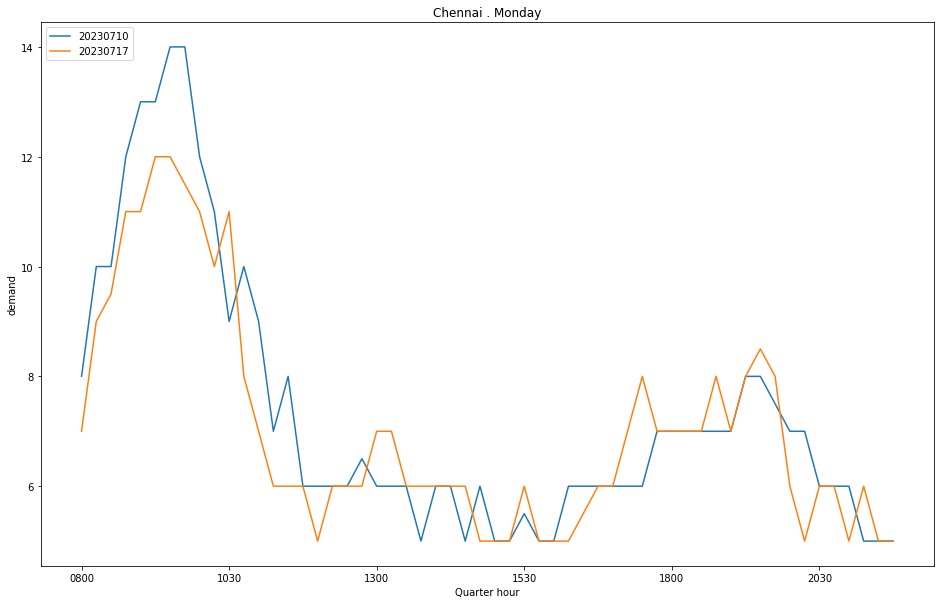

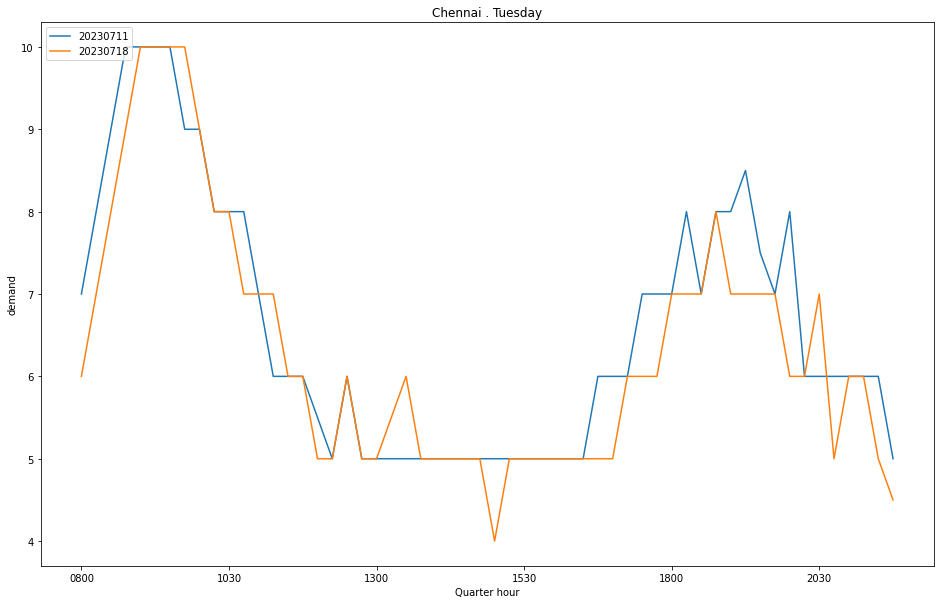

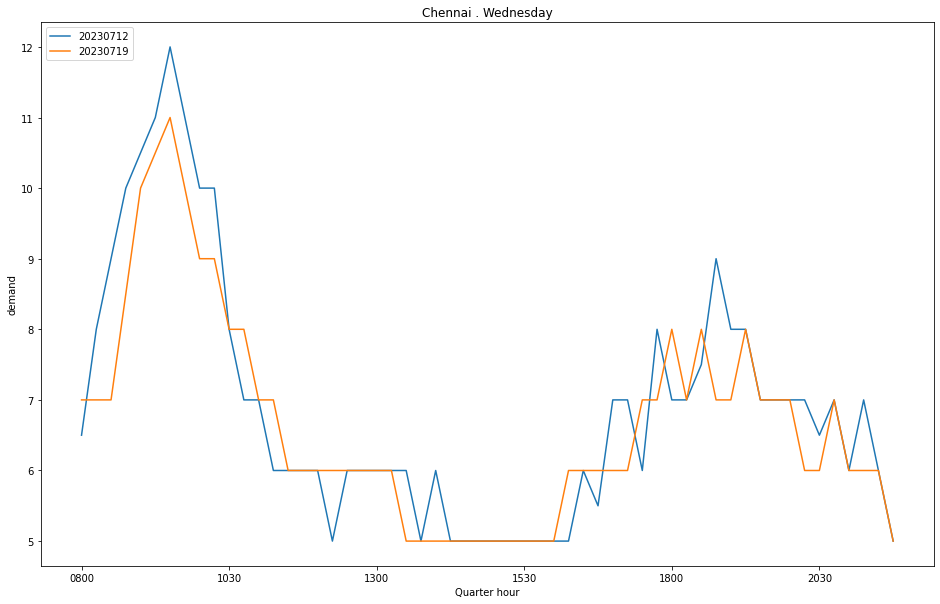

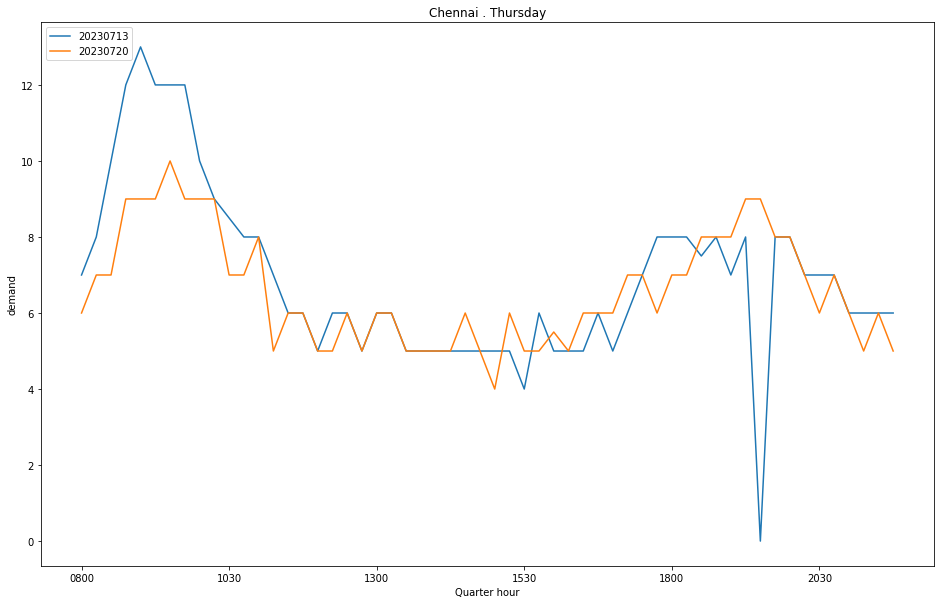

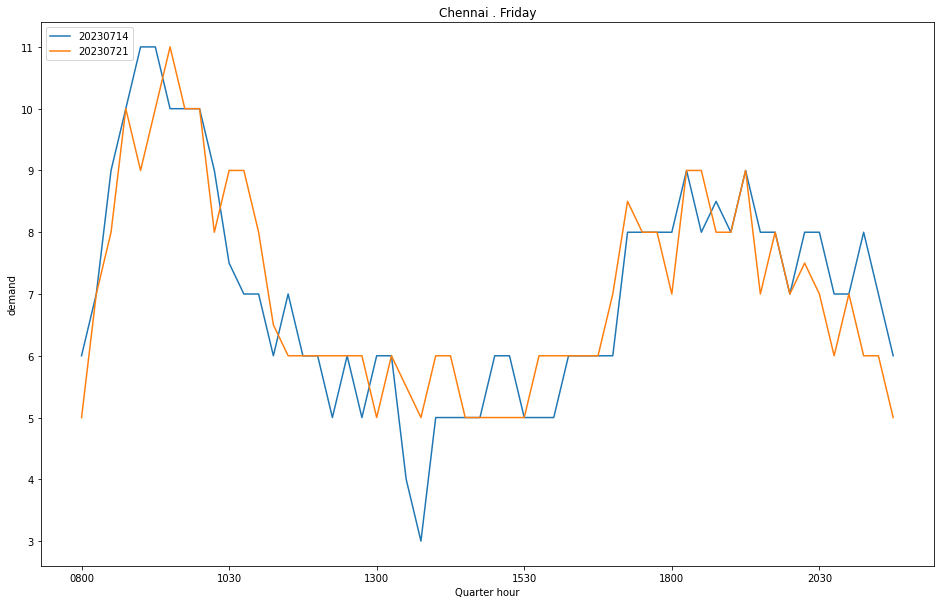

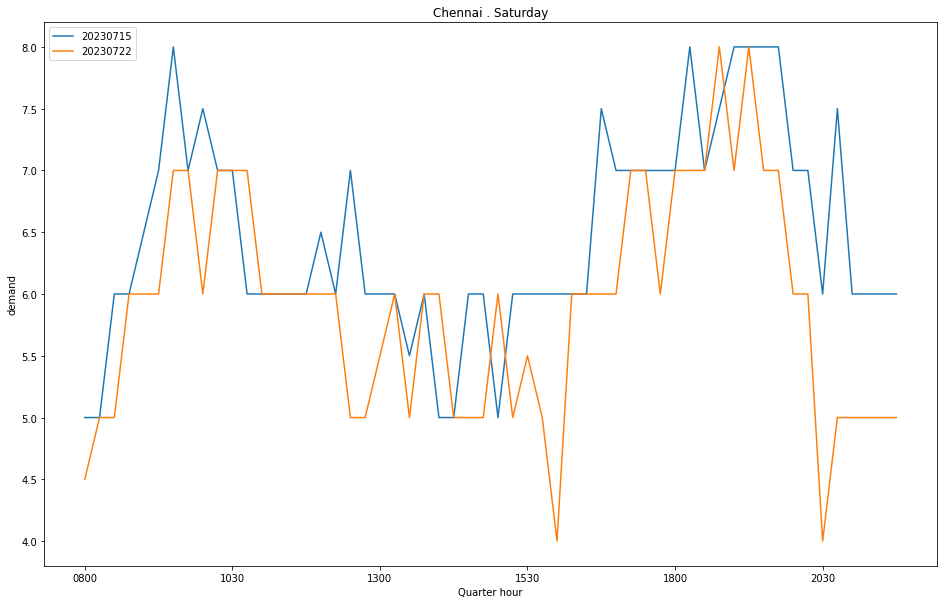

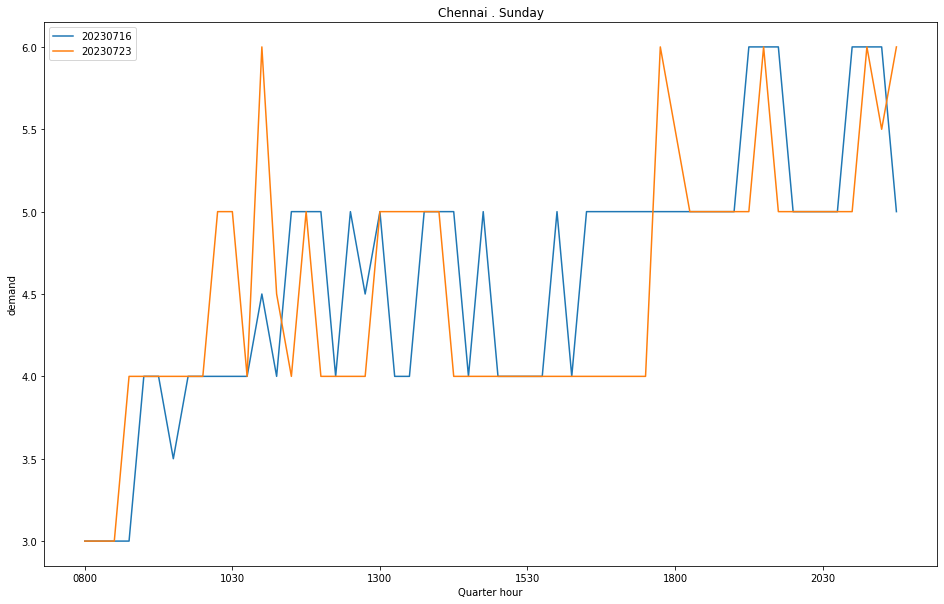

In [98]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    demand_each_wp = demand_counts[demand_counts['week_period'] == each_week_period]

    ax = demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('demand');

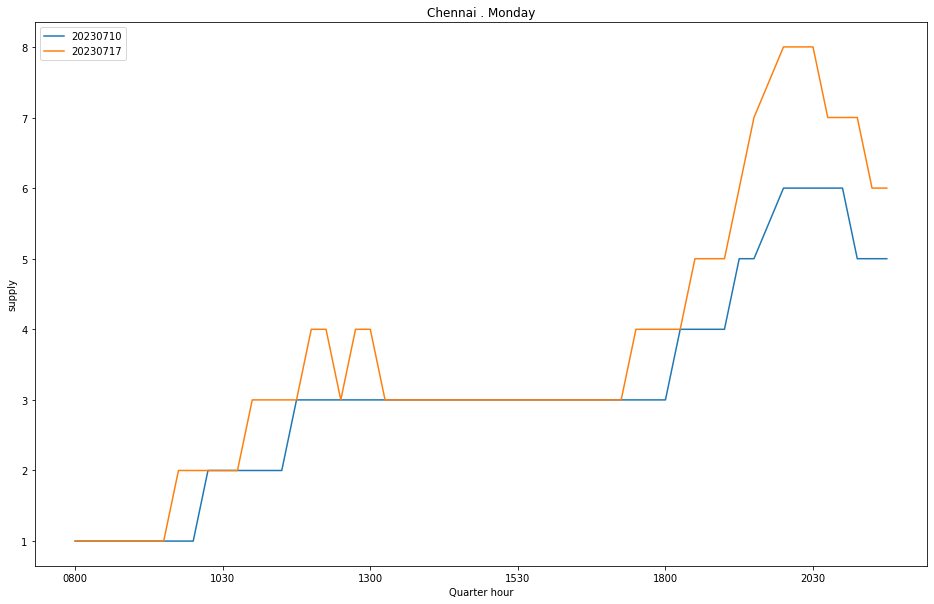

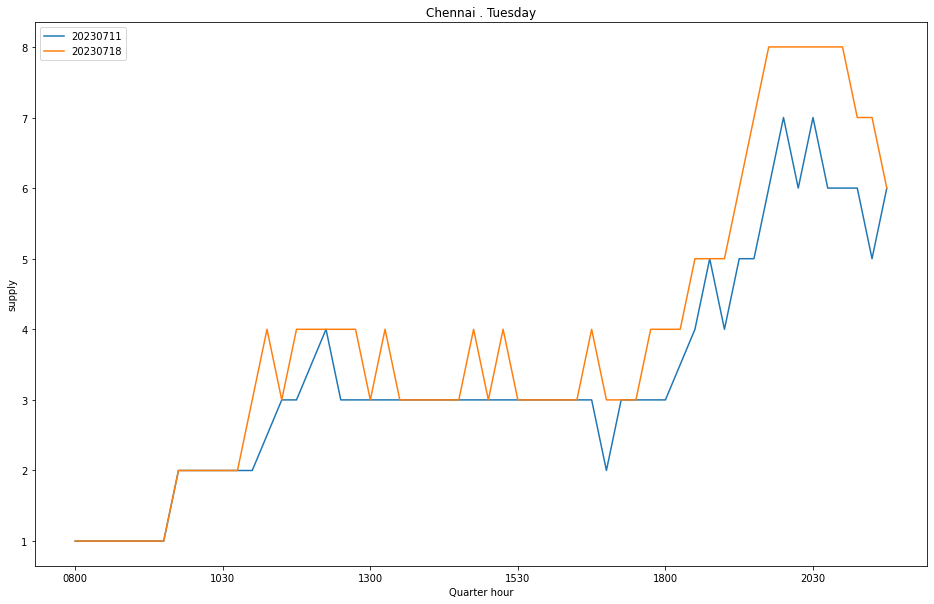

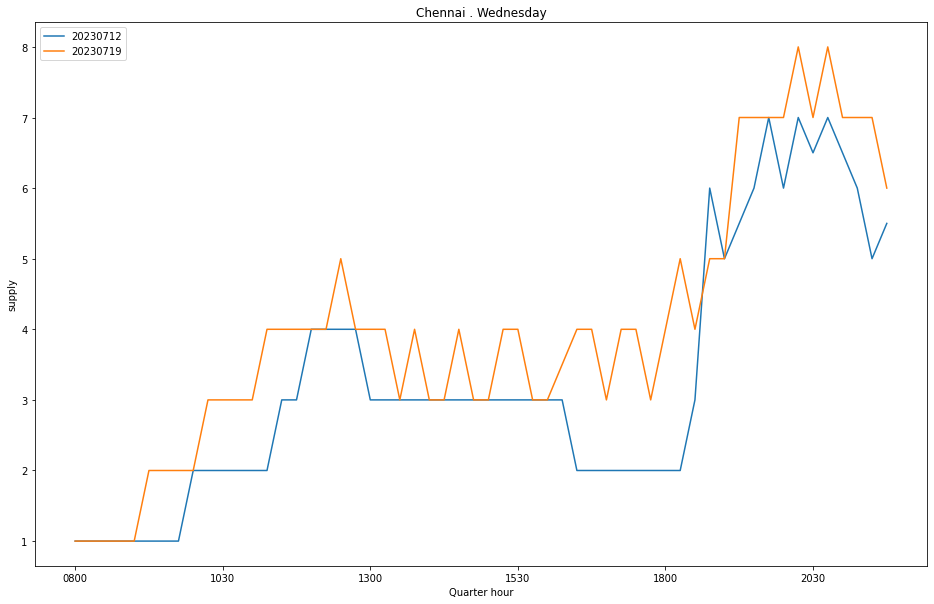

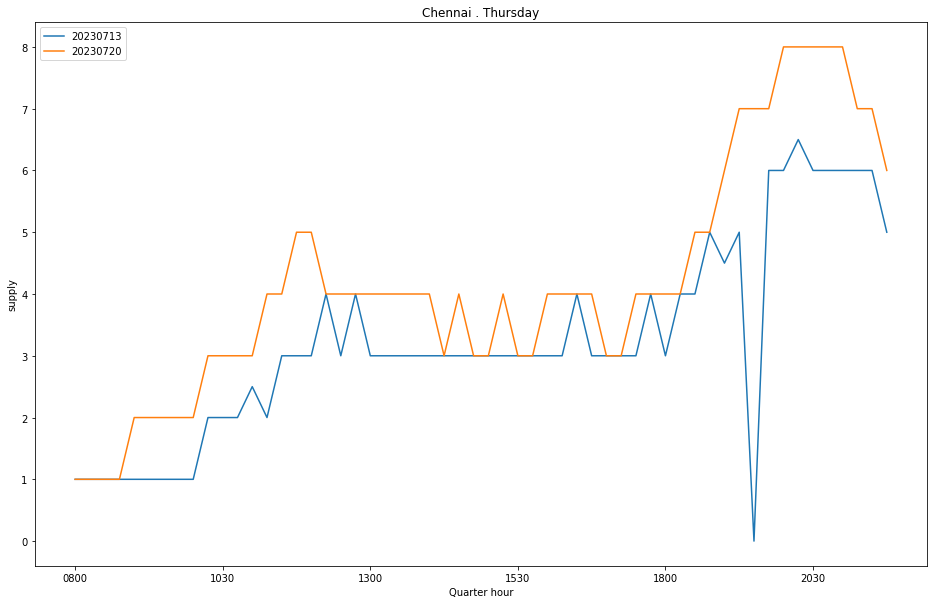

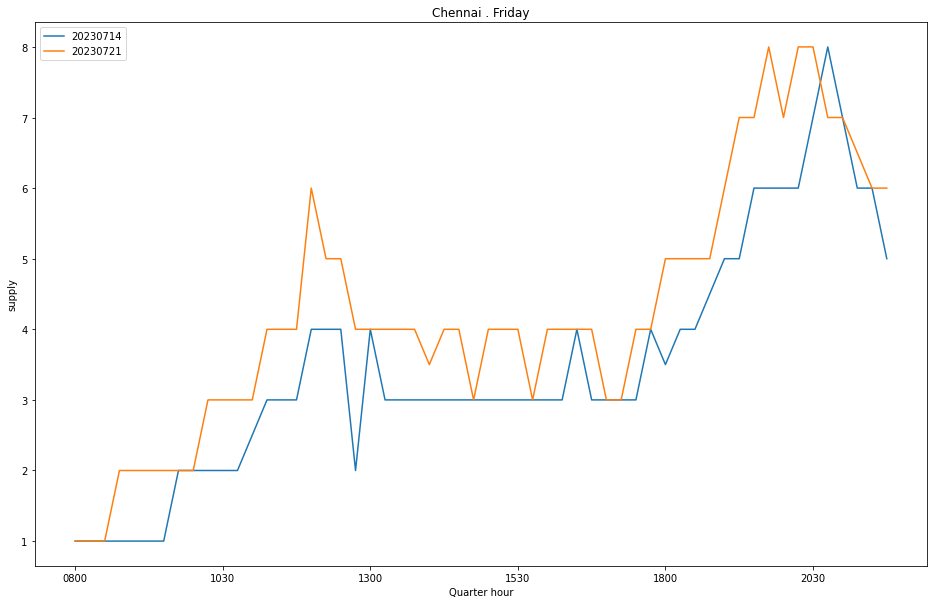

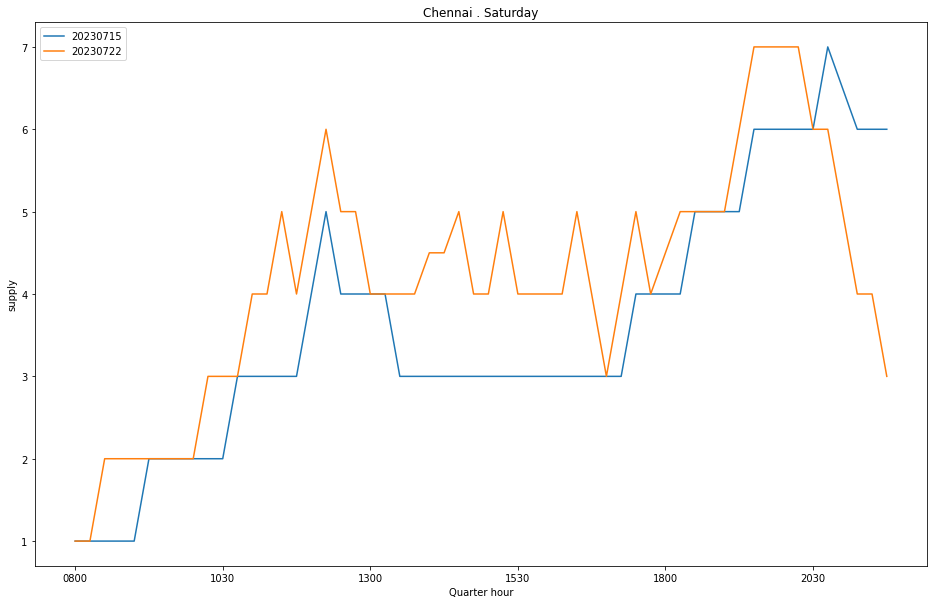

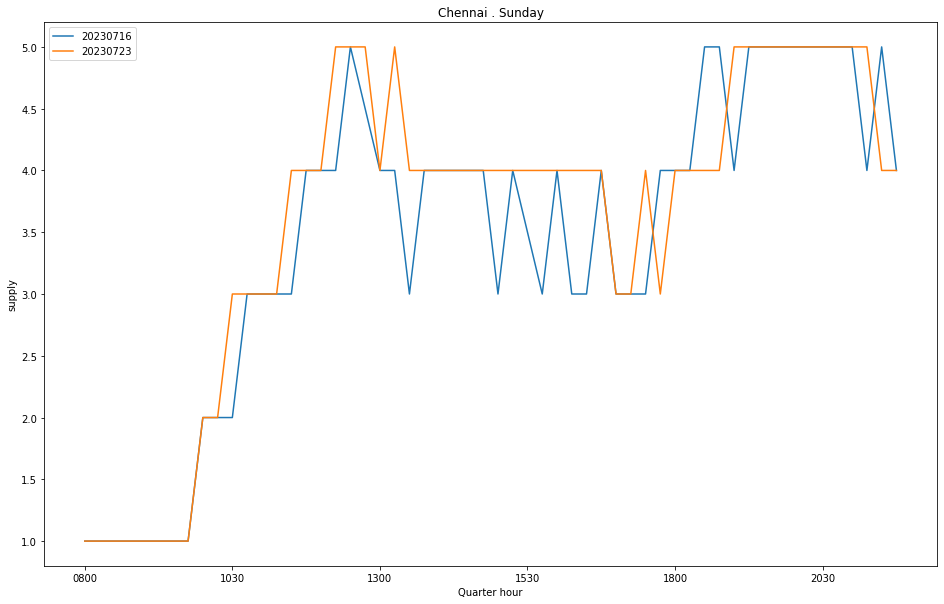

In [99]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    supply_each_wp = supply_counts[supply_counts['week_period'] == each_week_period]

    ax = supply_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='supply').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('supply');

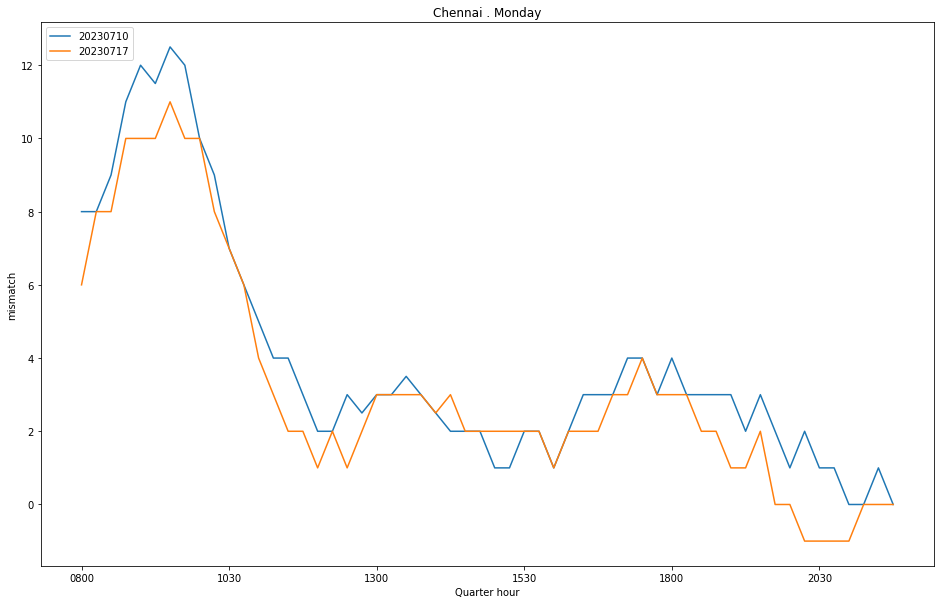

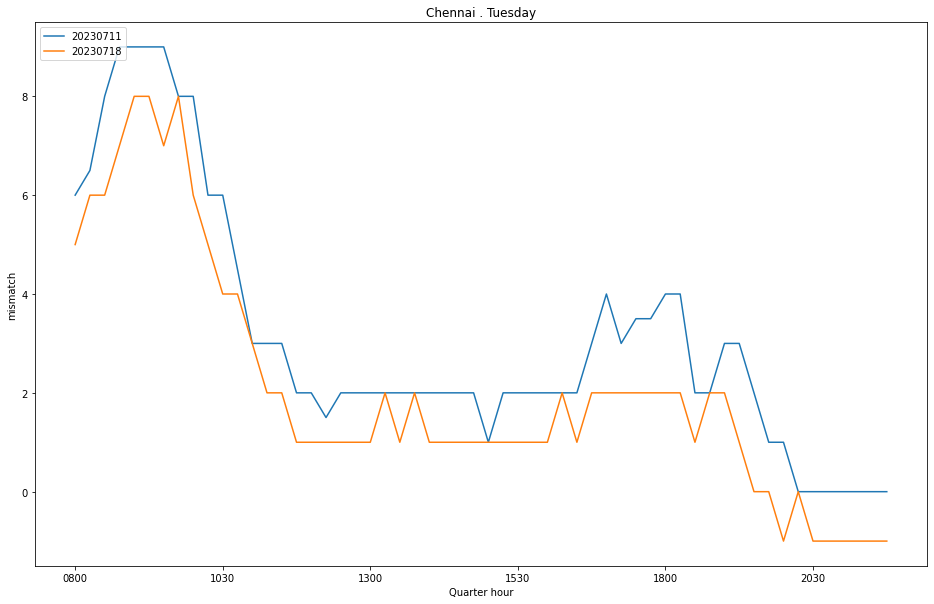

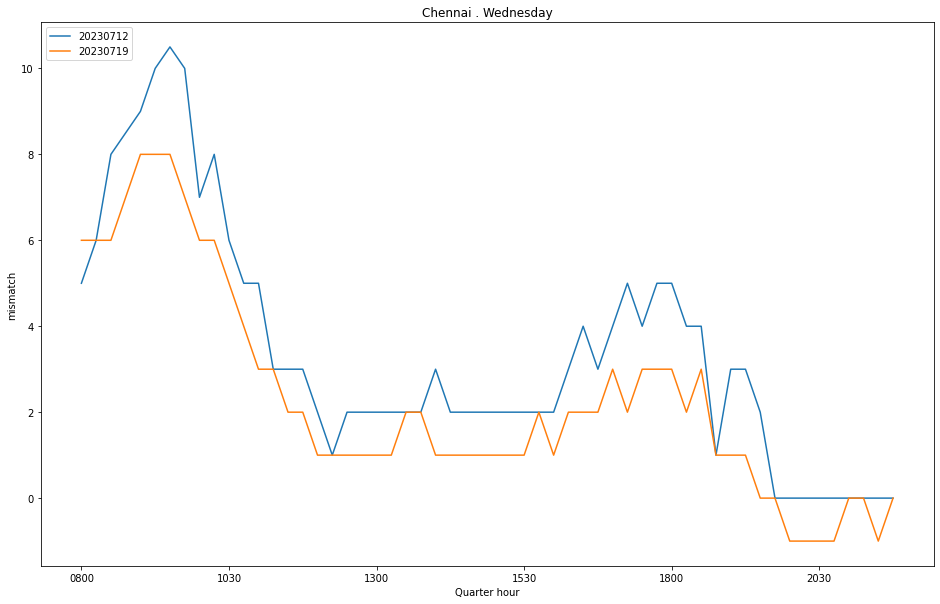

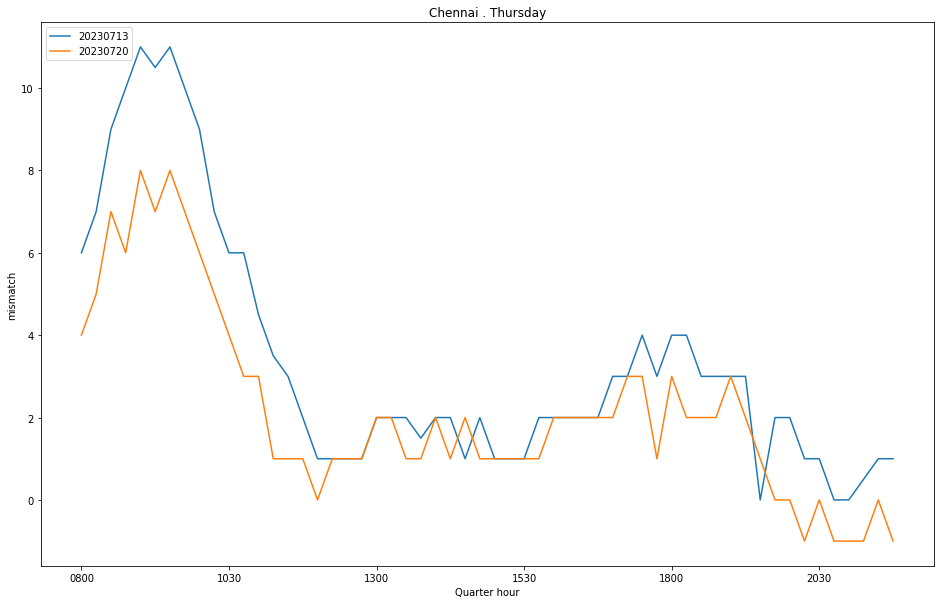

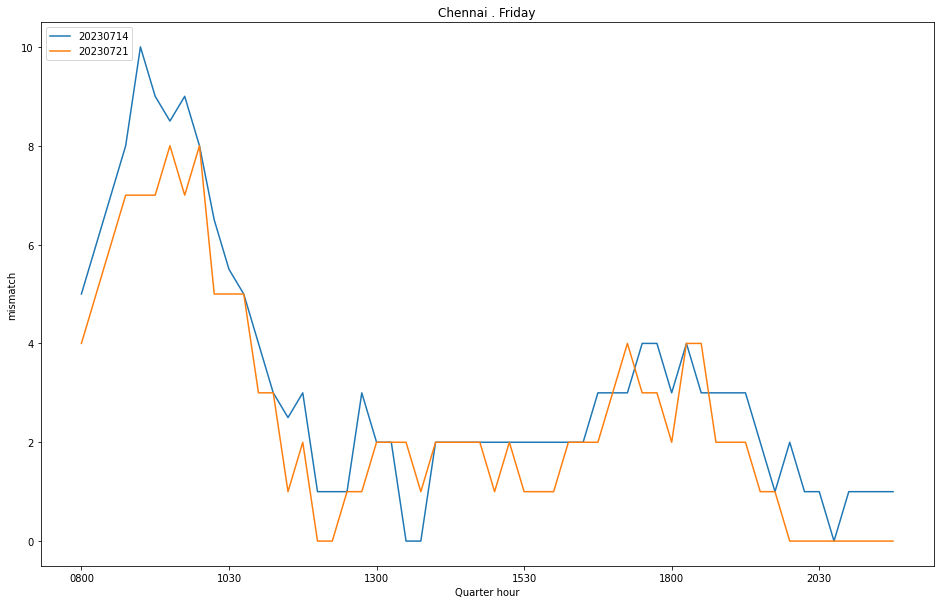

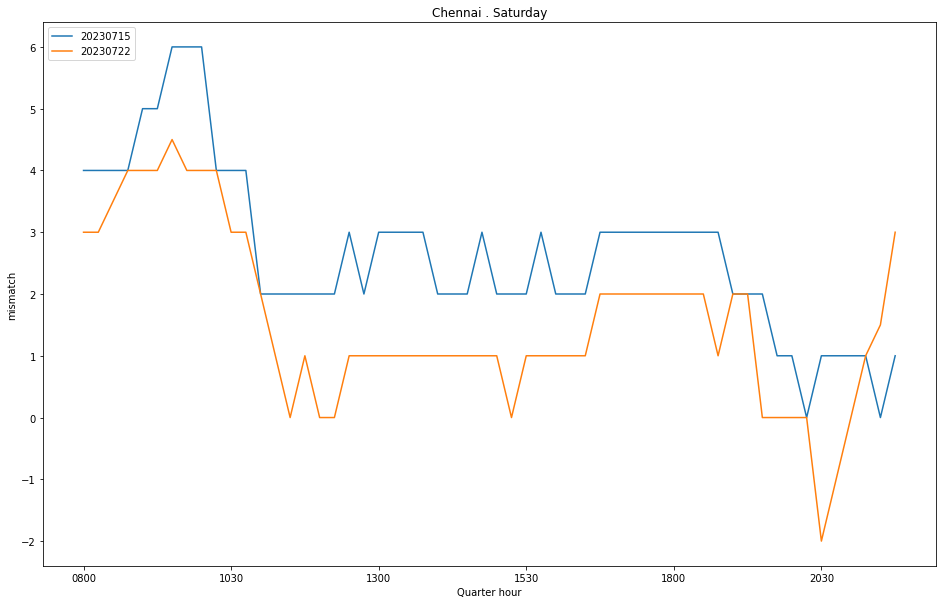

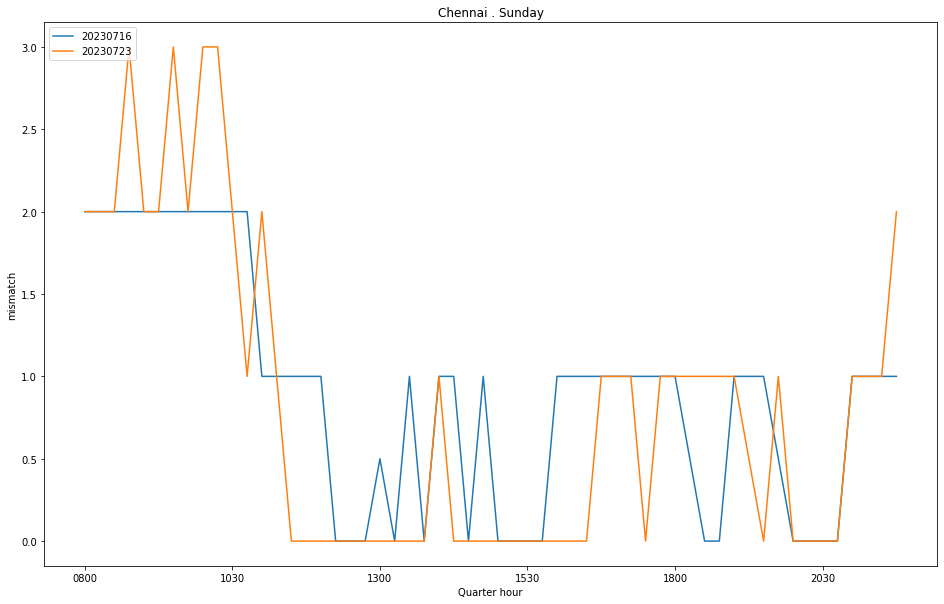

In [100]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    mismatch_each_wp = mismatch_counts[mismatch_counts['week_period'] == each_week_period]

    ax = mismatch_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='mismatch').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('mismatch');

### At city and time period level

In [101]:
# Demand view at city and time period level for Link orders.
deamnd_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='demand') \
    .reset_index()

print(deamnd_counts_tp.shape)
deamnd_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  5bed473f1278885df4ea9d57
0                  20230710     afternoon                       6.0
1                  20230710  evening_peak                       7.0
2                  20230710  morning_peak                      10.0
3                  20230711     afternoon                       5.0
4                  20230711  evening_peak                       7.0

In [102]:
# Supply view at city level and time_period for Link orders.
supply_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='supply') \
    .reset_index()

print(supply_counts_tp.shape)
supply_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  5bed473f1278885df4ea9d57
0                  20230710     afternoon                       3.0
1                  20230710  evening_peak                       4.0
2                  20230710  morning_peak                       1.0
3                  20230711     afternoon                       3.0
4                  20230711  evening_peak                       5.0

In [103]:
# Mismatch view at city and time_period level for Link orders.
mismatch_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='mismatch') \
    .reset_index()

print(mismatch_counts_tp.shape)
mismatch_counts_tp.head()

(42, 3)


service_detail_id  yyyymmdd   time_period  5bed473f1278885df4ea9d57
0                  20230710     afternoon                       2.0
1                  20230710  evening_peak                       2.0
2                  20230710  morning_peak                       8.0
3                  20230711     afternoon                       2.0
4                  20230711  evening_peak                       2.0

### Check for cluster temporal combinations for which dcf_data has mismatch positive, 
* what is the supply
* what is the demand 

In [104]:
# clusters_post_idle_captain_threshold_filter = ['Gachibowli', 'Nanakramguda 2', 'Hitech City',
#        'Wipro Nanakramguda Circle', 'Wipro Gachibowli Campus',
#        'Manikonda', 'shilparamam', 'Kukatpally 3', 'Shamshabad',
#        'Banjara Hills', 'Bahadurguda', 'Quthbullapur', 'Saroor Nagar',
#        'Bodduppal', 'Hitech City 2', 'Mansoorabad', 'Miyapur 2',
#        'Hafeezpet', 'Hayath Nagar', 'Jeedimetla', 'Kukatpally',
#        'Kothaguda 2', 'BHEL']


clusters_post_idle_captain_threshold_filter = cluster_temporal_combinations_selected.pickup_cluster.unique().tolist()


dcf_data.head()

service_detail_id   orderdate quarter_hour  pickup_cluster  \
1  5bed473f1278885df4ea9d57  2023-07-10         0800    Thoraipakkam   
3  5bed473f1278885df4ea9d57  2023-07-10         0930      Madhavaram   
5  5bed473f1278885df4ea9d57  2023-07-10         0930        Taramani   
7  5bed473f1278885df4ea9d57  2023-07-10         0945  Keelkattalai 2   
9  5bed473f1278885df4ea9d57  2023-07-10         0945      Madhavaram   

   gross_orders  net_orders  mean_distance  demand  supply   time_period  ...  \
1            27          14       5.162681    16.0     2.0  morning_peak  ...   
3            19           9       5.318214    18.0     3.0  morning_peak  ...   
5            17           9       4.435067     9.0     1.0  morning_peak  ...   
7            15           4       3.572133    14.0     1.0  morning_peak  ...   
9            17          12       8.060667    19.0     2.0  morning_peak  ...   

      city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  FE2Net  \
1  Chennai  20230710       115        32         14   27.8  43.8    12.2   
3  Chennai  20230710       113        24          9   21.2  37.5     8.0   
5  Chennai  20230710        78        20          9   25.6  45.0    11.5   
7  Chennai  20230710        89        20          4   22.5  20.0     4.5   
9  Chennai  20230710       112        18         12   16.1  66.7    10.7   

   week_period mismatch  
1       Monday     14.0  
3       Monday     15.0  
5       Monday      8.0  
7       Monday     13.0  
9       Monday     17.0  

[5 rows x 21 columns]

In [105]:
dcf_data_filtered_on_supply = dcf_data[dcf_data['pickup_cluster'].isin(clusters_post_idle_captain_threshold_filter)]

dcf_data_filtered_on_supply.head()

service_detail_id   orderdate quarter_hour  pickup_cluster  \
1   5bed473f1278885df4ea9d57  2023-07-10         0800    Thoraipakkam   
3   5bed473f1278885df4ea9d57  2023-07-10         0930      Madhavaram   
7   5bed473f1278885df4ea9d57  2023-07-10         0945  Keelkattalai 2   
9   5bed473f1278885df4ea9d57  2023-07-10         0945      Madhavaram   
15  5bed473f1278885df4ea9d57  2023-07-10         1030   Thiruvanmiyur   

    gross_orders  net_orders  mean_distance  demand  supply   time_period  \
1             27          14       5.162681    16.0     2.0  morning_peak   
3             19           9       5.318214    18.0     3.0  morning_peak   
7             15           4       3.572133    14.0     1.0  morning_peak   
9             17          12       8.060667    19.0     2.0  morning_peak   
15            12           9       3.247467    17.0     4.0  morning_peak   

    ...     city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  \
1   ...  Chennai  20230710       115        32         14   27.8  43.8   
3   ...  Chennai  20230710       113        24          9   21.2  37.5   
7   ...  Chennai  20230710        89        20          4   22.5  20.0   
9   ...  Chennai  20230710       112        18         12   16.1  66.7   
15  ...  Chennai  20230710        85        12          9   14.1  75.0   

    FE2Net  week_period mismatch  
1     12.2       Monday     14.0  
3      8.0       Monday     15.0  
7      4.5       Monday     13.0  
9     10.7       Monday     17.0  
15    10.6       Monday     13.0  

[5 rows x 21 columns]

In [106]:
dcf_data_filtered_on_supply.quarter_hour.unique()

array(['0800', '0930', '0945', '1030', '1045', '1100', '1115', '1215',
       '1315', '1945', '2100', '1845', '1430', '1515', '1530', '1600',
       '1645', '1745', '1900', '2115', '2130', '2145', '0815', '0830',
       '0915', '1545', '1615', '1715', '1730', '1015', '1145', '1200',
       '1230', '2045', '1630', '1830', '0900', '1000', '1345', '1915',
       '2000', '2015', '0845', '1415', '1500', '2030', '1800', '1815',
       '1130', '1330', '1400', '1445', '1700', '1930', '1245', '1300'],
      dtype=object)

In [107]:
## morning peak vs evening peak vs afternoon peak of dcf_data post supply filter

cluster_name = clusters_post_idle_captain_threshold_filter[0]

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply[
    dcf_data_filtered_on_supply['pickup_cluster'] == cluster_name]

dcf_data_filtered_on_supply_one_cluster.head()

service_detail_id   orderdate quarter_hour pickup_cluster  \
51   5bed473f1278885df4ea9d57  2023-07-11         1315       Mylapore   
468  5bed473f1278885df4ea9d57  2023-07-19         1815       Mylapore   
625  5bed473f1278885df4ea9d57  2023-07-22         2015       Mylapore   
633  5bed473f1278885df4ea9d57  2023-07-22         2030       Mylapore   
645  5bed473f1278885df4ea9d57  2023-07-22         2130       Mylapore   

     gross_orders  net_orders  mean_distance  demand  supply   time_period  \
51             14          10       2.042382    19.0    10.0     afternoon   
468            42          31       5.758225    30.0    13.0  evening_peak   
625            22           9       3.090170    27.0    14.0  evening_peak   
633            14           4       3.741539    21.0    17.0  evening_peak   
645            24          10       4.272024    11.0    10.0  evening_peak   

     ...     city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  \
51   ...  Chennai  20230711        73        15         10   20.5  66.7   
468  ...  Chennai  20230719       235        52         31   22.1  59.6   
625  ...  Chennai  20230722       210        22          9   10.5  40.9   
633  ...  Chennai  20230722       406        14          4    3.4  28.6   
645  ...  Chennai  20230722       366        28         10    7.7  35.7   

     FE2Net  week_period mismatch  
51     13.7      Tuesday      9.0  
468    13.2    Wednesday     17.0  
625     4.3     Saturday     13.0  
633     1.0     Saturday      4.0  
645     2.7     Saturday      1.0  

[5 rows x 21 columns]

In [108]:
dcf_data_filtered_on_supply_one_cluster['quarter_hour'] = dcf_data_filtered_on_supply_one_cluster[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply_one_cluster[
    (dcf_data_filtered_on_supply_one_cluster['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply_one_cluster['quarter_hour'] <= 2100)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply_one_cluster, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                 1100  1115  1130  1145  1200  1215  1230  1245   
pickup_cluster week_period                                                    
Mylapore       Friday        26.0  25.5  21.0  23.5  24.5  21.0  16.5  10.5   
               Monday        24.5  27.5  26.0  25.5  23.0  23.5  30.0  23.0   
               Saturday      28.5  26.0  27.5  27.0  24.0  19.0  19.5  18.5   
               Sunday        25.5  24.5  21.5  25.5  21.5  21.5  26.5  17.0   
               Thursday      25.5  24.0  25.5  29.0  24.5  20.0  18.5  15.5   
               Tuesday       25.0  19.5  22.0  24.0  25.5  20.0  18.5  18.5   
               Wednesday     27.5  24.5  24.5  26.5  23.5  20.0  17.5  17.0   

                                        ...                                \
quarter_hour                1300  1315  ...  1845  1900  1915  1930  1945   
pickup_cluster week_period              ...                                 
Mylapore       Friday       10.5  13.0  ...  10.0  14.5  14.0  20.5  18.5   
               Monday       17.5  12.5  ...  12.0  12.0  15.0  18.5  20.0   
               Saturday     15.0  13.0  ...  11.0  13.5  14.5  14.0  20.5   
               Sunday       13.0  12.5  ...  10.5  13.0  11.5  13.0  15.5   
               Thursday     11.5  11.5  ...  12.0  18.5  14.0  10.5  21.5   
               Tuesday      13.5  13.0  ...  11.5  13.0  16.0  16.0  19.0   
               Wednesday    15.5  13.0  ...  15.0  12.5  16.5  14.5  22.0   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
Mylapore       Friday       18.5  21.0  20.0  17.5  23.5  
               Monday       18.0  18.5  14.0  16.5  20.0  
               Saturday     17.5  15.0  17.0  21.0  23.0  
               Sunday       11.5  13.5  13.0  13.5  11.5  
               Thursday     21.0  25.5  21.0  22.0  20.0  
               Tuesday      19.5  21.5  18.0  17.5  21.0  
               Wednesday    23.0  26.5  23.5  21.0  21.5  

[7 rows x 41 columns]

In [110]:
dcf_data_filtered_on_supply['quarter_hour'] = dcf_data_filtered_on_supply[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply = dcf_data_filtered_on_supply[
    (dcf_data_filtered_on_supply['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply['quarter_hour'] <= 2100)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                 1100  1115  1130  1145  1200  1215  1230  1245   
pickup_cluster week_period                                                    
Adambakkam     Friday         1.0   3.0   3.0   2.5   4.0   4.0   4.0   1.5   
               Monday         1.5   2.0   1.5   3.0   4.0   3.5   4.0   3.0   
               Saturday       3.0   3.0   3.5   4.0   5.0   3.5   5.0   4.5   
               Sunday         1.5   2.5   4.0   4.0   4.0   4.5   4.5   3.5   
               Thursday       1.0   1.0   2.5   3.5   4.0   4.0   4.0   3.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
kilpauk        Saturday      14.5  18.5  21.5  22.5  24.5  19.0  21.0  17.5   
               Sunday        14.5  16.5  18.0  18.0  19.0  18.0  20.5  16.0   
               Thursday      13.0  16.5  19.0  19.5  22.0  18.5  20.0  15.0   
               Tuesday       14.0  16.0  16.5  19.0  25.0  19.0  20.0  14.0   
               Wednesday     13.0  17.0  17.0  16.5  22.0  16.5  18.5  15.0   

                                        ...                                \
quarter_hour                1300  1315  ...  1845  1900  1915  1930  1945   
pickup_cluster week_period              ...                                 
Adambakkam     Friday        4.0   4.0  ...   4.5   4.5   6.0   5.5   7.0   
               Monday        4.0   3.0  ...   4.5   4.5   5.0   6.5   7.0   
               Saturday      5.0   4.0  ...   6.5   5.0   5.0   5.0   6.0   
               Sunday        3.5   3.5  ...   3.5   4.0   5.5   4.0   5.0   
               Thursday      3.5   4.0  ...   5.5   5.0   6.5   4.0   7.5   
...                          ...   ...  ...   ...   ...   ...   ...   ...   
kilpauk        Saturday     16.0  17.0  ...  24.0  24.0  33.0  31.5  35.5   
               Sunday       16.5  15.0  ...  18.5  16.5  21.5  25.0  26.5   
               Thursday     15.0  12.5  ...  24.5  22.5  35.0  21.5  42.0   
               Tuesday      14.0  14.5  ...  25.0  24.5  36.5  42.0  39.0   
               Wednesday    13.5  15.0  ...  28.5  25.0  34.0  37.0  39.5   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
Adambakkam     Friday        8.0   7.5   9.0   8.0   6.5  
               Monday        8.0   6.0   9.0   7.5   5.5  
               Saturday      6.5   7.0   5.5   5.5   4.5  
               Sunday        4.5   5.0   5.5   4.5   3.5  
               Thursday      7.0   7.0   8.5   9.0   8.0  
...                          ...   ...   ...   ...   ...  
kilpauk        Saturday     34.5  37.5  31.0  28.5  25.5  
               Sunday       27.0  26.0  24.5  19.0  19.0  
               Thursday     42.0  46.0  35.5  37.0  32.0  
               Tuesday      37.5  41.0  38.5  40.0  30.5  
               Wednesday    39.5  40.0  36.5  35.5  31.5  

[273 rows x 41 columns]

In [112]:
dcf_data.head()

service_detail_id   orderdate quarter_hour  pickup_cluster  \
1  5bed473f1278885df4ea9d57  2023-07-10         0800    Thoraipakkam   
3  5bed473f1278885df4ea9d57  2023-07-10         0930      Madhavaram   
5  5bed473f1278885df4ea9d57  2023-07-10         0930        Taramani   
7  5bed473f1278885df4ea9d57  2023-07-10         0945  Keelkattalai 2   
9  5bed473f1278885df4ea9d57  2023-07-10         0945      Madhavaram   

   gross_orders  net_orders  mean_distance  demand  supply   time_period  ...  \
1            27          14       5.162681    16.0     2.0  morning_peak  ...   
3            19           9       5.318214    18.0     3.0  morning_peak  ...   
5            17           9       4.435067     9.0     1.0  morning_peak  ...   
7            15           4       3.572133    14.0     1.0  morning_peak  ...   
9            17          12       8.060667    19.0     2.0  morning_peak  ...   

      city  yyyymmdd  fe_count  rr_count  net_count  FE2RR   G2N  FE2Net  \
1  Chennai  20230710       115        32         14   27.8  43.8    12.2   
3  Chennai  20230710       113        24          9   21.2  37.5     8.0   
5  Chennai  20230710        78        20          9   25.6  45.0    11.5   
7  Chennai  20230710        89        20          4   22.5  20.0     4.5   
9  Chennai  20230710       112        18         12   16.1  66.7    10.7   

   week_period mismatch  
1       Monday     14.0  
3       Monday     15.0  
5       Monday      8.0  
7       Monday     13.0  
9       Monday     17.0  

[5 rows x 21 columns]

In [113]:
dcf_data.demand.median()

6.0

In [114]:
dcf_data['hour'] = dcf_data['quarter_hour'].apply(lambda x: str(x[0:2]))
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data_stats_hour_level = dcf_data.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period','hour']).agg(
    demand = pd.NamedAgg('demand','sum'), 
    supply = pd.NamedAgg('supply','sum'),
    mismatch = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','hour','time_period'])

dcf_data_stats_hour_level['mismtach_pred'] = dcf_data_stats_hour_level['demand'] - dcf_data_stats_hour_level['supply']

dcf_data_stats_hour_level.head(20)

city pickup_cluster         service_detail_id week_period  \
10  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
11  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
12  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
13  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
0   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
1   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
2   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
3   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
4   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
5   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
6   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
7   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
8   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
9   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
24  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
25  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
26  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
27  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
14  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
15  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   

     time_period hour  demand  supply  mismatch  fe_count  rr_count  \
10  morning_peak   08   146.0     1.0      18.0       662       171   
11  morning_peak   09   206.0     5.0      25.5       853       241   
12  morning_peak   10   129.0     7.0      14.5       469       135   
13  morning_peak   11    90.0    19.0       9.0       314        72   
0      afternoon   12    75.0    27.0       7.5       285        72   
1      afternoon   13    39.0    27.0       3.0       189        38   
2      afternoon   14    60.0    24.0       4.5       279        82   
3      afternoon   15    56.0    30.0       2.5       204        50   
4      afternoon   16    45.0    29.0       2.0       247        48   
5   evening_peak   17    63.0    26.0       4.0       274        73   
6   evening_peak   18    86.0    33.0       6.5       377        85   
7   evening_peak   19    79.0    46.0       4.5       339        80   
8   evening_peak   20    87.0    65.0       2.5       366        89   
9   evening_peak   21    83.0    48.0       4.0       276        70   
24  morning_peak   08   153.0     2.0      18.5       898       238   
25  morning_peak   09   213.0     2.0      28.0      1124       235   
26  morning_peak   10   137.0     5.0      15.5       636       150   
27  morning_peak   11    82.0    16.0       7.0       367        86   
14     afternoon   12    79.0    29.0       5.5       281        71   
15     afternoon   13    62.0    27.0       4.5       223        50   

    net_count  mismtach_pred  
10         71          145.0  
11         83          201.0  
12         77          122.0  
13         49           71.0  
0          55           48.0  
1          25           12.0  
2          42           36.0  
3          32           26.0  
4          40           16.0  
5          61           37.0  
6          59           53.0  
7          63           33.0  
8          67           22.0  
9          54           35.0  
24         55          151.0  
25         66          211.0  
26         72          132.0  
27         52           66.0  
14         52           50.0  
15         35           35.0

In [115]:
dcf_data_stats_hour_level['excess_supply_ratio'] = dcf_data_stats_hour_level[
    'supply']/dcf_data_stats_hour_level['demand']

dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'
dcf_data_stats_hour_level.head()

city pickup_cluster         service_detail_id week_period  \
10  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
11  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
12  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
13  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
0   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   

     time_period hour  demand  supply  mismatch  fe_count  rr_count  \
10  morning_peak   08   146.0     1.0      18.0       662       171   
11  morning_peak   09   206.0     5.0      25.5       853       241   
12  morning_peak   10   129.0     7.0      14.5       469       135   
13  morning_peak   11    90.0    19.0       9.0       314        72   
0      afternoon   12    75.0    27.0       7.5       285        72   

    net_count  mismtach_pred  excess_supply_ratio is_excess_supply  
10         71          145.0             0.006849               no  
11         83          201.0             0.024272               no  
12         77          122.0             0.054264               no  
13         49           71.0             0.211111               no  
0          55           48.0             0.360000               no

In [116]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_hour_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply', 'fe_count', 'rr_count','net_count'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period','hour']
                                          )
dcf_data_stats_hour_level_pivot

demand                                       \
time_period                afternoon                         evening_peak   
hour                              12    13    14    15    16           17   
pickup_cluster week_period                                                  
Adambakkam     Friday           75.0  39.0  60.0  56.0  45.0         63.0   
               Monday           79.0  62.0  49.0  47.0  58.0         65.0   
               Saturday         82.0  66.0  56.0  41.0  62.0         75.0   
               Sunday           59.0  38.0  49.0  59.0  53.0         58.0   
               Thursday         56.0  56.0  57.0  24.0  56.0         68.0   
...                              ...   ...   ...   ...   ...          ...   
puzhal         Saturday          0.0   0.0   0.0   1.0   4.0          0.0   
               Sunday            NaN   0.0   3.0   1.0   NaN          NaN   
               Thursday          1.0   NaN   0.0   0.0   4.0          1.0   
               Tuesday           1.0   1.0   NaN   0.0   0.0          5.0   
               Wednesday         1.0   1.0   NaN   0.0   6.0          2.0   

                                                    ...    supply  \
time_period                                         ... afternoon   
hour                          18    19    20    21  ...        16   
pickup_cluster week_period                          ...             
Adambakkam     Friday       86.0  79.0  87.0  83.0  ...      29.0   
               Monday       72.0  72.0  58.0  43.0  ...      30.0   
               Saturday     87.0  74.0  65.0  44.0  ...      38.0   
               Sunday       61.0  66.0  60.0  56.0  ...      28.0   
               Thursday     93.0  60.0  69.0  63.0  ...      35.0   
...                          ...   ...   ...   ...  ...       ...   
puzhal         Saturday      0.0   NaN   NaN   0.0  ...       2.0   
               Sunday        1.0   0.0   NaN   0.0  ...       NaN   
               Thursday      1.0   NaN   NaN   0.0  ...       2.0   
               Tuesday       0.0   0.0   1.0   0.0  ...       0.0   
               Wednesday     0.0   NaN   NaN   NaN  ...       5.0   

                                                                              \
time_period                evening_peak                         morning_peak   
hour                                 17    18    19    20    21           08   
pickup_cluster week_period                                                     
Adambakkam     Friday              26.0  33.0  46.0  65.0  48.0          1.0   
               Monday              28.0  29.0  46.0  61.0  41.0          2.0   
               Saturday            33.0  39.0  42.0  49.0  31.0          2.0   
               Sunday              31.0  23.0  37.0  39.0  33.0          0.0   
               Thursday            28.0  34.0  46.0  63.0  52.0          1.0   
...                                 ...   ...   ...   ...   ...          ...   
puzhal         Saturday             0.0   0.0   NaN   NaN   0.0          NaN   
               Sunday               NaN   1.0   0.0   NaN   0.0          NaN   
               Thursday             0.0   0.0   NaN   NaN   0.0          0.0   
               Tuesday              1.0   0.0   0.0   1.0   0.0          0.0   
               Wednesday            0.0   0.0   NaN   NaN   NaN          0.0   

                                             
time_period                                  
hour                         09    10    11  
pickup_cluster week_period                   
Adambakkam     Friday       5.0   7.0  19.0  
               Monday       2.0   5.0  16.0  
               Saturday     7.0  13.0  27.0  
               Sunday       2.0  10.0  24.0  
               Thursday     3.0   6.0  16.0  
...                         ...   ...   ...  
puzhal         Saturday     0.0   0.0   2.0  
               Sunday       NaN   0.0   NaN  
               Thursday     0.0   NaN   0.0  
               Tuesday      1.0   NaN  

In [117]:
dcf_data_stats_hour_level.groupby(
    ['pickup_cluster','week_period','time_period','hour']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   hour  is_excess_supply
Adambakkam      Friday       afternoon     12    no                  1
                                           13    no                  1
                                           14    no                  1
                                           15    no                  1
                                           16    no                  1
                                                                    ..
puzhal          Wednesday    afternoon     12    no                  1
                                           13    yes                 1
                                           16    no                  1
                             evening_peak  17    no                  1
                             morning_peak  11    yes                 1
Name: is_excess_supply, Length: 14657, dtype: int64

In [118]:
check_for_excess_idle_captains = dcf_data_stats_hour_level[dcf_data_stats_hour_level['pickup_cluster'].isin(
    clusters_post_idle_captain_threshold_filter)]

In [119]:
check_for_excess_idle_captains = check_for_excess_idle_captains.dropna()

In [120]:
check_for_excess_idle_captains.head()

city pickup_cluster         service_detail_id week_period  \
10  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
11  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
12  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
13  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
0   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   

     time_period hour  demand  supply  mismatch  fe_count  rr_count  \
10  morning_peak   08   146.0     1.0      18.0       662       171   
11  morning_peak   09   206.0     5.0      25.5       853       241   
12  morning_peak   10   129.0     7.0      14.5       469       135   
13  morning_peak   11    90.0    19.0       9.0       314        72   
0      afternoon   12    75.0    27.0       7.5       285        72   

    net_count  mismtach_pred  excess_supply_ratio is_excess_supply  
10         71          145.0             0.006849               no  
11         83          201.0             0.024272               no  
12         77          122.0             0.054264               no  
13         49           71.0             0.211111               no  
0          55           48.0             0.360000               no

In [121]:
dcf_data_stats_tp_level = dcf_data_stats_hour_level.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period']).agg(
    demand = pd.NamedAgg('demand','median'), 
    supply = pd.NamedAgg('supply','median'),
    mismatch_qr_level = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum'),
    fe_count_med = pd.NamedAgg('fe_count','median'), 
    rr_count_med = pd.NamedAgg('rr_count','median'), 
    net_count_med = pd.NamedAgg('net_count','median')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','time_period'])

dcf_data_stats_tp_level['mismtach_pred_tp'] = dcf_data_stats_tp_level['demand'] - dcf_data_stats_tp_level['supply']

dcf_data_stats_tp_level.head(20)

city pickup_cluster         service_detail_id week_period  \
0   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
1   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
2   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday   
3   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
4   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
5   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday   
6   Chennai     Adambakkam  5bed473f1278885df4ea9d57    Saturday   
7   Chennai     Adambakkam  5bed473f1278885df4ea9d57    Saturday   
8   Chennai     Adambakkam  5bed473f1278885df4ea9d57    Saturday   
9   Chennai     Adambakkam  5bed473f1278885df4ea9d57      Sunday   
10  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Sunday   
11  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Sunday   
12  Chennai     Adambakkam  5bed473f1278885df4ea9d57    Thursday   
13  Chennai     Adambakkam  5bed473f1278885df4ea9d57    Thursday   
14  Chennai     Adambakkam  5bed473f1278885df4ea9d57    Thursday   
15  Chennai     Adambakkam  5bed473f1278885df4ea9d57     Tuesday   
16  Chennai     Adambakkam  5bed473f1278885df4ea9d57     Tuesday   
17  Chennai     Adambakkam  5bed473f1278885df4ea9d57     Tuesday   
18  Chennai     Adambakkam  5bed473f1278885df4ea9d57   Wednesday   
19  Chennai     Adambakkam  5bed473f1278885df4ea9d57   Wednesday   

     time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
0      afternoon    56.0    27.0               3.00      1204       290   
1   evening_peak    83.0    46.0               4.00      1632       397   
2   morning_peak   137.5     6.0              16.25      2298       619   
3      afternoon    58.0    29.0               2.50      1239       290   
4   evening_peak    65.0    41.0               3.50      1283       327   
5   morning_peak   145.0     3.5              17.00      3025       709   
6      afternoon    62.0    34.0               3.00      1791       333   
7   evening_peak    74.0    39.0               4.50      2364       342   
8   morning_peak    83.0    10.0               8.00      1492       333   
9      afternoon    53.0    30.0               2.50      1663       267   
10  evening_peak    60.0    33.0               3.00      1892       314   
11  morning_peak    50.5     6.0               5.00      1135       181   
12     afternoon    56.0    30.0               2.50      1124       270   
13  evening_peak    68.0    46.0               2.50      1318       375   
14  morning_peak   119.0     4.5              13.50      2683       627   
15     afternoon    51.0    29.0               1.00      1074       250   
16  evening_peak    71.0    48.0               2.00      1261       339   
17  morning_peak   116.0     5.5              13.50      2363       517   
18     afternoon    55.0    29.0               3.00      1139       267   
19  evening_peak    71.0   128.0              -6.00      1485       363   

    net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  
0         194         247.0          50.0           40.0              29.0  
1         304         339.0          80.0           61.0              37.0  
2         280         565.5         153.0           74.0             131.5  
3         201         247.0          56.0           35.0              29.0  
4         247         277.0          71.0           50.0              24.0  
5         245         767.0         192.5           60.5             141.5  
6         239         364.0          59.0           42.0              28.0  
7         247         519.0          72.0           50.0              35.0  
8         234         376.0          85.5           63.0              73.0  
9         197         354.0          54.0           40.0              23.0  
10        229         403.0          62.0           45.0              27.0  
11        144         284.5          43.0           35.5              44.5  
1

In [122]:
dcf_data_stats_tp_level['excess_supply_ratio'] = dcf_data_stats_tp_level[
    'supply']/dcf_data_stats_tp_level['demand']

dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'

dcf_data_stats_tp_level = dcf_data_stats_tp_level.dropna()
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period   time_period  \
0  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday     afternoon   
1  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  evening_peak   
2  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  morning_peak   
3  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday     afternoon   
4  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday  evening_peak   

   demand  supply  mismatch_qr_level  fe_count  rr_count  net_count  \
0    56.0    27.0               3.00      1204       290        194   
1    83.0    46.0               4.00      1632       397        304   
2   137.5     6.0              16.25      2298       619        280   
3    58.0    29.0               2.50      1239       290        201   
4    65.0    41.0               3.50      1283       327        247   

   fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0         247.0          50.0           40.0              29.0   
1         339.0          80.0           61.0              37.0   
2         565.5         153.0           74.0             131.5   
3         247.0          56.0           35.0              29.0   
4         277.0          71.0           50.0              24.0   

   excess_supply_ratio is_excess_supply  
0             0.482143               no  
1             0.554217               no  
2             0.043636               no  
3             0.500000               no  
4             0.630769               no

In [123]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','week_period','time_period']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   is_excess_supply
Adambakkam      Friday       afternoon     no                  1
                             evening_peak  no                  1
                             morning_peak  no                  1
                Monday       afternoon     no                  1
                             evening_peak  no                  1
                                                              ..
puzhal          Thursday     evening_peak  no                  1
                Tuesday      afternoon     no                  1
                             morning_peak  no                  1
                Wednesday    afternoon     no                  1
                             evening_peak  no                  1
Name: is_excess_supply, Length: 3173, dtype: int64

In [124]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','time_period']).is_excess_supply.value_counts()

pickup_cluster  time_period   is_excess_supply
Adambakkam      afternoon     no                  7
                evening_peak  no                  6
                              yes                 1
                morning_peak  no                  7
Adyar           afternoon     no                  7
                                                 ..
puzhal          afternoon     no                  4
                              yes                 2
                evening_peak  no                  2
                morning_peak  no                  1
                              yes                 1
Name: is_excess_supply, Length: 611, dtype: int64

In [125]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_tp_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period']
                                          )
dcf_data_stats_tp_level_pivot

demand                              supply  \
time_period                 afternoon evening_peak morning_peak afternoon   
pickup_cluster week_period                                                  
Adambakkam     Friday       55.000000    79.600000   142.750000     27.40   
               Monday       59.000000    62.000000   146.250000     28.40   
               Saturday     61.400000    69.000000    80.500000     33.60   
               Sunday       51.600000    60.200000    47.000000     30.40   
               Thursday     49.800000    70.600000   133.750000     30.00   
...                               ...          ...          ...       ...   
puzhal         Saturday      1.000000     0.000000     0.666667      0.80   
               Sunday        1.333333     0.333333     0.000000      3.00   
               Thursday      1.250000     0.666667     0.333333      0.50   
               Tuesday       0.500000     1.200000     0.666667      0.00   
               Wednesday     2.000000     1.000000     1.000000      1.75   

                                                      
time_period                evening_peak morning_peak  
pickup_cluster week_period                            
Adambakkam     Friday         43.600000     8.000000  
               Monday         41.000000     6.250000  
               Saturday       38.800000    12.250000  
               Sunday         32.600000     9.000000  
               Thursday       44.600000     6.500000  
...                                 ...          ...  
puzhal         Saturday        0.000000     0.666667  
               Sunday          0.333333     0.000000  
               Thursday        0.000000     0.000000  
               Tuesday         0.400000     0.333333  
               Wednesday       0.000000     1.333333  

[1113 rows x 6 columns]

In [126]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_pivot.reset_index()

dcf_data_stats_tp_level_flattened.head()

pickup_cluster week_period    demand                            \
time_period                            afternoon evening_peak morning_peak   
0               Adambakkam      Friday      55.0         79.6       142.75   
1               Adambakkam      Monday      59.0         62.0       146.25   
2               Adambakkam    Saturday      61.4         69.0        80.50   
3               Adambakkam      Sunday      51.6         60.2        47.00   
4               Adambakkam    Thursday      49.8         70.6       133.75   

               supply                            
time_period afternoon evening_peak morning_peak  
0                27.4         43.6         8.00  
1                28.4         41.0         6.25  
2                33.6         38.8        12.25  
3                30.4         32.6         9.00  
4                30.0         44.6         6.50

In [127]:
dcf_data_stats_tp_level_flattened.columns

MultiIndex([('pickup_cluster',             ''),
            (   'week_period',             ''),
            (        'demand',    'afternoon'),
            (        'demand', 'evening_peak'),
            (        'demand', 'morning_peak'),
            (        'supply',    'afternoon'),
            (        'supply', 'evening_peak'),
            (        'supply', 'morning_peak')],
           names=[None, 'time_period'])

In [128]:
## flatten the column names

dcf_data_stats_tp_level_flattened.columns = ['_'.join(col) for col in dcf_data_stats_tp_level_flattened.columns.values]

In [129]:
dcf_data_stats_tp_level_flattened.head()

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
0      Adambakkam       Friday              55.0                 79.6   
1      Adambakkam       Monday              59.0                 62.0   
2      Adambakkam     Saturday              61.4                 69.0   
3      Adambakkam       Sunday              51.6                 60.2   
4      Adambakkam     Thursday              49.8                 70.6   

   demand_morning_peak  supply_afternoon  supply_evening_peak  \
0               142.75              27.4                 43.6   
1               146.25              28.4                 41.0   
2                80.50              33.6                 38.8   
3                47.00              30.4                 32.6   
4               133.75              30.0                 44.6   

   supply_morning_peak  
0                 8.00  
1                 6.25  
2                12.25  
3                 9.00  
4                 6.50

In [130]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_flattened.dropna()

In [131]:
dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] = dcf_data_stats_tp_level_flattened[
    'supply_afternoon']/dcf_data_stats_tp_level_flattened['demand_afternoon']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] = dcf_data_stats_tp_level_flattened[
    'supply_evening_peak']/dcf_data_stats_tp_level_flattened['demand_evening_peak']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_mp'] = dcf_data_stats_tp_level_flattened[
    'supply_morning_peak']/dcf_data_stats_tp_level_flattened['demand_morning_peak']

dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) , 'is_excess_supply_after'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] <= 1.0) , 'is_excess_supply_after'] = 'no'


dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] > 1.0) , 'is_excess_supply_ep'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] <= 1.0) , 'is_excess_supply_ep'] = 'no'

In [132]:
dcf_data_stats_tp_level_flattened.head()

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
0      Adambakkam       Friday              55.0                 79.6   
1      Adambakkam       Monday              59.0                 62.0   
2      Adambakkam     Saturday              61.4                 69.0   
3      Adambakkam       Sunday              51.6                 60.2   
4      Adambakkam     Thursday              49.8                 70.6   

   demand_morning_peak  supply_afternoon  supply_evening_peak  \
0               142.75              27.4                 43.6   
1               146.25              28.4                 41.0   
2                80.50              33.6                 38.8   
3                47.00              30.4                 32.6   
4               133.75              30.0                 44.6   

   supply_morning_peak  excess_supply_ratio_afternoon  excess_supply_ratio_ep  \
0                 8.00                       0.498182                0.547739   
1                 6.25                       0.481356                0.661290   
2                12.25                       0.547231                0.562319   
3                 9.00                       0.589147                0.541528   
4                 6.50                       0.602410                0.631728   

   excess_supply_ratio_mp is_excess_supply_after is_excess_supply_ep  
0                0.056042                     no                  no  
1                0.042735                     no                  no  
2                0.152174                     no                  no  
3                0.191489                     no                  no  
4                0.048598                     no                  no

In [133]:
dcf_data_stats_tp_level_flattened['is_excess_supply_after'].value_counts()

no     796
yes    280
Name: is_excess_supply_after, dtype: int64

In [134]:
dcf_data_stats_tp_level_flattened['is_excess_supply_ep'].value_counts()

no     725
yes    355
Name: is_excess_supply_ep, dtype: int64

In [136]:
## How many clusters have excess supply afternoon and not in evening peak?

total_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].nunique()

total_uniq_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].pickup_cluster_.unique()

excess_supply_afternoon_dat = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)]


print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.shape[0]))
print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.pickup_cluster_.nunique()))

print("--------------------------------------------------------------------")

print("Clusters having excess supply in afternoon but not evening peak")

print("--------------------------------------------------------------------")

print("Total cluster week period Combinations")
print("-------------------------------------------")
print(total_cluster_wp_combinations)
print("")
print("Total unique clusters Combinations",len(total_uniq_cluster_wp_combinations))
print("")
print("List of unique clusters week period combinations")
print("")
print(total_uniq_cluster_wp_combinations)


Total cluster week period Combinations 1103
Total cluster week period Combinations 159
--------------------------------------------------------------------
Clusters having excess supply in afternoon but not evening peak
--------------------------------------------------------------------
Total cluster week period Combinations
-------------------------------------------
pickup_cluster_                  27
week_period_                      7
demand_afternoon                 30
demand_evening_peak              35
demand_morning_peak              34
supply_afternoon                 34
supply_evening_peak              33
supply_morning_peak              32
excess_supply_ratio_afternoon    34
excess_supply_ratio_ep           35
excess_supply_ratio_mp           34
is_excess_supply_after            1
is_excess_supply_ep               1
dtype: int64

Total unique clusters Combinations 27

List of unique clusters week period combinations

['Ambattur OT' 'Balaji Nagar' 'Beasant Nagar'
 'Chennai I

In [138]:

dcf_data_stats_tp_level_flattened[dcf_data_stats_tp_level_flattened['pickup_cluster_'] == total_uniq_cluster_wp_combinations[0]]

pickup_cluster_ week_period_  demand_afternoon  demand_evening_peak  \
63     Ambattur OT       Friday              36.0                 65.6   
64     Ambattur OT       Monday              38.0                 59.4   
65     Ambattur OT     Saturday              45.6                 53.2   
66     Ambattur OT       Sunday              19.8                 22.8   
67     Ambattur OT     Thursday              39.6                 56.6   
68     Ambattur OT      Tuesday              31.0                 59.8   
69     Ambattur OT    Wednesday              40.0                 58.4   

    demand_morning_peak  supply_afternoon  supply_evening_peak  \
63                51.50              27.2                 46.8   
64                67.75              36.4                 38.2   
65                49.75              29.0                 39.2   
66                22.00              18.0                 22.0   
67                56.25              27.8                 43.0   
68                56.00              49.4                 48.8   
69                59.00              26.8                 46.8   

    supply_morning_peak  excess_supply_ratio_afternoon  \
63                68.75                       0.755556   
64                23.00                       0.957895   
65                23.50                       0.635965   
66                12.25                       0.909091   
67                25.75                       0.702020   
68                32.00                       1.593548   
69                34.00                       0.670000   

    excess_supply_ratio_ep  excess_supply_ratio_mp is_excess_supply_after  \
63                0.713415                1.334951                     no   
64                0.643098                0.339483                     no   
65                0.736842                0.472362                     no   
66                0.964912                0.556818                     no   
67                0.759717                0.457778                     no   
68                0.816054                0.571429                    yes   
69                0.801370                0.576271                     no   

   is_excess_supply_ep  
63                  no  
64                  no  
65                  no  
66                  no  
67                  no  
68                  no  
69                  no

In [139]:
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period   time_period  \
0  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday     afternoon   
1  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  evening_peak   
2  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  morning_peak   
3  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday     afternoon   
4  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday  evening_peak   

   demand  supply  mismatch_qr_level  fe_count  rr_count  net_count  \
0    56.0    27.0               3.00      1204       290        194   
1    83.0    46.0               4.00      1632       397        304   
2   137.5     6.0              16.25      2298       619        280   
3    58.0    29.0               2.50      1239       290        201   
4    65.0    41.0               3.50      1283       327        247   

   fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0         247.0          50.0           40.0              29.0   
1         339.0          80.0           61.0              37.0   
2         565.5         153.0           74.0             131.5   
3         247.0          56.0           35.0              29.0   
4         277.0          71.0           50.0              24.0   

   excess_supply_ratio is_excess_supply  
0             0.482143               no  
1             0.554217               no  
2             0.043636               no  
3             0.500000               no  
4             0.630769               no

In [140]:
dcf_data_stats_tp_level.to_csv(
    '~/Downloads/dcf_data_stats_tp_level_{city}_{service}_{start_date}_{end_date}.csv'.format(
    city = city, 
    service=service, 
    start_date=start_date, 
    end_date = end_date))

In [141]:
dcf_data_stats_tp_level['unique_name'] = dcf_data_stats_tp_level[
    'pickup_cluster'] + '_' + dcf_data_stats_tp_level['week_period']

excess_supply_afternoon_dat['unique_name'] = excess_supply_afternoon_dat[
    'pickup_cluster_'] + '_' + excess_supply_afternoon_dat['week_period_']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
funnel_coverage_calc_data = dcf_data_stats_tp_level[dcf_data_stats_tp_level['unique_name'].isin(
    excess_supply_afternoon_dat['unique_name'].unique().tolist())]

funnel_coverage_calc_data.head()


city pickup_cluster         service_detail_id week_period  \
202  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
203  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
204  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
448  Chennai   Balaji Nagar  5bed473f1278885df4ea9d57      Sunday   
449  Chennai   Balaji Nagar  5bed473f1278885df4ea9d57      Sunday   

      time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
202     afternoon    30.0    51.0               -2.0       715       165   
203  evening_peak    62.0    49.0                2.0      1000       307   
204  morning_peak    55.5    35.5                3.0       771       238   
448     afternoon    13.0    14.0                0.0       487        74   
449  evening_peak    22.0    13.0                1.0       678       124   

     net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
202        121         141.0          32.0           23.0             -21.0   
203        226         204.0          67.0           50.0              13.0   
204        169         203.0          63.5           44.5              20.0   
448         50          88.0          15.0            9.0              -1.0   
449         94         138.0          24.0           16.0               9.0   

     excess_supply_ratio is_excess_supply          unique_name  
202             1.700000              yes  Ambattur OT_Tuesday  
203             0.790323               no  Ambattur OT_Tuesday  
204             0.639640               no  Ambattur OT_Tuesday  
448             1.076923              yes  Balaji Nagar_Sunday  
449             0.590909               no  Balaji Nagar_Sunday

In [143]:
funnel_coverage_calc_data['fe2rr'] = 100*funnel_coverage_calc_data['rr_count']/funnel_coverage_calc_data['fe_count']
funnel_coverage_calc_data['g2n'] = 100*funnel_coverage_calc_data['net_count']/funnel_coverage_calc_data['rr_count']
funnel_coverage_calc_data['fe2rr_med'] = 100*funnel_coverage_calc_data['rr_count_med']/funnel_coverage_calc_data[
    'fe_count_med']
funnel_coverage_calc_data['g2n_med'] = 100*funnel_coverage_calc_data['net_count_med']/funnel_coverage_calc_data[
    'rr_count_med']

## equating net count = supply (idealistic scenario)
funnel_coverage_calc_data['full_utiliz_g2n_med'] = 100*funnel_coverage_calc_data[
    'supply']/funnel_coverage_calc_data[
    'rr_count_med']

funnel_coverage_calc_data.loc[funnel_coverage_calc_data['full_utiliz_g2n_med'] > 100.0, 'full_utiliz_g2n_med'] = 100.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [144]:
funnel_coverage_calc_data.head()

city pickup_cluster         service_detail_id week_period  \
202  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
203  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
204  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
448  Chennai   Balaji Nagar  5bed473f1278885df4ea9d57      Sunday   
449  Chennai   Balaji Nagar  5bed473f1278885df4ea9d57      Sunday   

      time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  ...  \
202     afternoon    30.0    51.0               -2.0       715       165  ...   
203  evening_peak    62.0    49.0                2.0      1000       307  ...   
204  morning_peak    55.5    35.5                3.0       771       238  ...   
448     afternoon    13.0    14.0                0.0       487        74  ...   
449  evening_peak    22.0    13.0                1.0       678       124  ...   

     net_count_med  mismtach_pred_tp  excess_supply_ratio  is_excess_supply  \
202           23.0             -21.0             1.700000               yes   
203           50.0              13.0             0.790323                no   
204           44.5              20.0             0.639640                no   
448            9.0              -1.0             1.076923               yes   
449           16.0               9.0             0.590909                no   

             unique_name      fe2rr        g2n  fe2rr_med    g2n_med  \
202  Ambattur OT_Tuesday  23.076923  73.333333  22.695035  71.875000   
203  Ambattur OT_Tuesday  30.700000  73.615635  32.843137  74.626866   
204  Ambattur OT_Tuesday  30.869001  71.008403  31.280788  70.078740   
448  Balaji Nagar_Sunday  15.195072  67.567568  17.045455  60.000000   
449  Balaji Nagar_Sunday  18.289086  75.806452  17.391304  66.666667   

     full_utiliz_g2n_med  
202           100.000000  
203            73.134328  
204            55.905512  
448            93.333333  
449            54.166667  

[5 rows x 23 columns]

In [145]:
funnel_coverage_calc_data.is_excess_supply.value_counts()

no     67
yes    36
Name: is_excess_supply, dtype: int64

In [146]:
excess_supply_all_sessions = funnel_coverage_calc_data[funnel_coverage_calc_data['is_excess_supply'] == 'yes']

fe_countribution = 100*excess_supply_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*excess_supply_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*excess_supply_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply", excess_supply_all_sessions.shape[0])
print("")

print("% contribution by these clusters for all sessions")
print("-------------------------------------------------")

print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply 36

% contribution by these clusters for all sessions
-------------------------------------------------
FE Contribution % 0.7233873922249207
RR Contribution % 0.5576293880923486
Net Contribution % 0.5541690867507818


## Actual session wise fe contribution

In [148]:
excess_supply_all_sessions = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_all_sessions.shape[0]

737

### All sessions

In [149]:
funnel_coverage_calc_data_all_sessions = excess_supply_all_sessions[
    excess_supply_all_sessions['time_period'] != 'rest']

fe_countribution = 100*funnel_coverage_calc_data_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during all sessions", 
      funnel_coverage_calc_data_all_sessions.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during all sessions 737

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 14.780929637271438
RR Contribution % 12.950059571454393
Net Contribution % 13.05194212655507


### Evening peak

In [150]:
excess_supply_ep = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'evening_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_ep.shape[0]

351

In [151]:
funnel_coverage_calc_data_ep = excess_supply_ep[excess_supply_ep['time_period'] == 'evening_peak']

fe_countribution = 100*funnel_coverage_calc_data_ep['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_ep['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_ep['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during evening peak", 
      funnel_coverage_calc_data_ep.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during evening peak 351

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 8.267533847676571
RR Contribution % 7.413234084462363
Net Contribution % 7.9266747102779105


### Afternoon

In [152]:
excess_supply_after = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'afternoon') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_after.shape[0]

278

In [153]:
funnel_coverage_calc_data_after = excess_supply_after[excess_supply_after['time_period'] == 'afternoon']

fe_countribution = 100*funnel_coverage_calc_data_after['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_after['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_after['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during afternoon", 
      funnel_coverage_calc_data_after.shape[0])
print("")

print("% contribution by these clusters during afternoon")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during afternoon 278

% contribution by these clusters during afternoon
-------------------------------------------------
FE Contribution % 5.30035923121569
RR Contribution % 4.387815701043515
Net Contribution % 3.9555158364027965


In [154]:
excess_supply_after.pickup_cluster.unique()

array(['Ambattur', 'Ambattur OT', 'Anakaputhur', 'Annanur',
       'Arasankalani', 'Avadi', 'Ayappakkam', 'Balaji Nagar',
       'Basin Bridge', 'Beasant Avenue', 'Beasant Nagar',
       'CHN GUDUVANCHERY', 'CHN KANDIGAI', 'CHN KELAMBAKKAM',
       'CHN MAMBAKKAM', 'CHN SRM UNIVERSITY', 'CHN URAPAKKAM',
       'CHN VANDALUR', 'Chembarambakkam', 'Chennai International Airport',
       'Chennai One IT park ', 'Chromepet', 'ECR Beach', 'East Tambaram',
       'Ennore', 'Guindy 3', 'Guindy National Park',
       'Kamarajapuram Ambattur', 'Kannadapalayam', 'Kattupakkam',
       'Keelkattalai 2', 'Keelkattalai 3', 'Korattur', 'Kotturpuram',
       'Kundrathur', 'Madhanandapuram', 'Madhavaram', 'Manali',
       'Manapakkam', 'Mangadu', 'Mangadu 2', 'Medavakkam Central',
       'Meenambakkam', 'NIWE', 'New Vellanur', 'Padianallur',
       'Palavakkam', 'Pallavaram', 'Pallikaranai', 'Panaiyur',
       'Pattabiram', 'Perumbakkam', 'Perungalattur', 'Poonamallee',
       'Red Hills', 'Retteri Lake

In [155]:
excess_supply_all_sessions[excess_supply_all_sessions['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

city pickup_cluster         service_detail_id week_period  \
189  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Friday   
197  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Sunday   
202  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   

      time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
189  morning_peak    52.5    73.0              -1.75       739       219   
197  evening_peak    21.0    25.0               0.50       871       139   
202     afternoon    30.0    51.0              -2.00       715       165   

     net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
189        150         195.5          54.0           37.0             -20.5   
197         98         172.0          28.0           20.0              -4.0   
202        121         141.0          32.0           23.0             -21.0   

     excess_supply_ratio is_excess_supply          unique_name  
189             1.390476              yes   Ambattur OT_Friday  
197             1.190476              yes   Ambattur OT_Sunday  
202             1.700000              yes  Ambattur OT_Tuesday

### Morning peak

In [156]:
excess_supply_mp = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'morning_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_mp.shape[0]

108

In [157]:
funnel_coverage_calc_data_mp = excess_supply_mp[excess_supply_mp['time_period'] == 'morning_peak']

fe_countribution = 100*funnel_coverage_calc_data_mp['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_mp['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_mp['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during morning peak", 
      funnel_coverage_calc_data_mp.shape[0])
print("")

print("% contribution by these clusters during morning peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during morning peak 108

% contribution by these clusters during morning peak
-------------------------------------------------
FE Contribution % 1.2130365583791767
RR Contribution % 1.149009785948514
Net Contribution % 1.1697515798743632


In [298]:
364+569+396

1329

----

## Final segments where we need to perform the experiment

In [158]:
cluster_temporal_stats_with_idle_captain_threshold.head()

time_period pickup_cluster week_period  total_fe_count  total_rr_count  \
0   afternoon     Adambakkam      Friday            1204             290   
1   afternoon     Adambakkam      Monday            1239             290   
2   afternoon     Adambakkam    Saturday            1791             333   
3   afternoon     Adambakkam      Sunday            1663             267   
4   afternoon     Adambakkam     Tuesday            1074             250   

   total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
0               194    24.066390  66.666667                   68.11   
1               201    23.387097  69.072165                   68.11   
2               239    18.582589  71.556886                   68.11   
3               197    16.045673  73.507463                   68.11   
4               190    23.255814  75.697211                   68.11   

  higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
0                   75.055  ...                          high   
1                   75.055  ...                        medium   
2                   75.055  ...                        medium   
3                   75.055  ...                           low   
4                   75.055  ...                        medium   

  fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
0                       low              high-low   
1                    medium         medium-medium   
2                    medium         medium-medium   
3                    medium            low-medium   
4                      high           medium-high   

  conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
0                          high                       low   
1                        medium                    medium   
2                        medium                    medium   
3                           low                    medium   
4                        medium                      high   

  cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
0              high-low                        high                     low   
1         medium-medium                      medium                  medium   
2         medium-medium                      medium                  medium   
3            low-medium                         low                  medium   
4           medium-high                      medium                    high   

  cf_category_0.1_0.9 idle_captain_threshold  
0            high-low                 111.88  
1       medium-medium                 111.88  
2       medium-medium                 111.88  
3          low-medium                 111.88  
4         medium-high                 111.88  

[5 rows x 44 columns]

In [159]:
cluster_temporal_stats_lh = cluster_temporal_stats_with_idle_captain_threshold[
    cluster_temporal_stats_with_idle_captain_threshold['cf_category_0.25_0.75'] == 'low-high']

cluster_temporal_stats_lh.head()

time_period   pickup_cluster week_period  total_fe_count  total_rr_count  \
37   afternoon         Alwarpet      Sunday            1366             273   
45   afternoon  Alwarthirunagar      Sunday             859             124   
51   afternoon         Ambattur    Saturday            1637             301   
66   afternoon      Ambattur OT      Sunday             742             115   
71   afternoon      Anakaputhur    Saturday            2232             401   

    total_net_orders  fe_rr_ratio  g2n_ratio lower_g2n_threshold_0.1  \
37               212    19.970739  77.372263                 67.8461   
45                76    14.418605  60.800000                 38.1695   
51               224    18.376068  74.172185                 66.5767   
66                84    15.477793  72.413793                 64.1154   
71               237    17.957904  58.955224                 53.2231   

   higher_g2n_threshold_0.9  ... conversion_category_0.15_0.85  \
37                  78.3821  ...                           low   
45                  62.9316  ...                           low   
51                  73.0134  ...                        medium   
66                  72.6049  ...                           low   
71                  60.0098  ...                        medium   

   fulfil_category_0.15_0.85 cf_category_0.15_0.85  \
37                    medium            low-medium   
45                    medium            low-medium   
51                      high           medium-high   
66                    medium            low-medium   
71                    medium         medium-medium   

   conversion_category_0.12_0.87 fulfil_category_0.12_0.87  \
37                           low                    medium   
45                           low                    medium   
51                        medium                      high   
66                           low                    medium   
71                        medium                    medium   

   cf_category_0.12_0.87 conversion_category_0.1_0.9 fulfil_category_0.1_0.9  \
37            low-medium                         low                  medium   
45            low-medium                         low                  medium   
51           medium-high                      medium                    high   
66            low-medium                         low                  medium   
71         medium-medium                      medium                  medium   

   cf_category_0.1_0.9 idle_captain_threshold  
37          low-medium                 111.88  
45          low-medium                 111.88  
51         medium-high                 111.88  
66          low-medium                 111.88  
71       medium-medium                 111.88  

[5 rows x 44 columns]

In [160]:
cluster_temporal_stats_lh_filtered = cluster_temporal_stats_lh[['pickup_cluster','week_period','time_period',
                           'cf_category_0.25_0.75','idle_captain_threshold','total_fe_count',
                           'total_rr_count','total_net_orders','fe_rr_ratio','g2n_ratio']]

cluster_temporal_stats_lh_filtered.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
37         Alwarpet      Sunday   afternoon              low-high   
45  Alwarthirunagar      Sunday   afternoon              low-high   
51         Ambattur    Saturday   afternoon              low-high   
66      Ambattur OT      Sunday   afternoon              low-high   
71      Anakaputhur    Saturday   afternoon              low-high   

    idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
37                  111.88            1366             273               212   
45                  111.88             859             124                76   
51                  111.88            1637             301               224   
66                  111.88             742             115                84   
71                  111.88            2232             401               237   

    fe_rr_ratio  g2n_ratio  
37    19.970739  77.372263  
45    14.418605  60.800000  
51    18.376068  74.172185  
66    15.477793  72.413793  
71    17.957904  58.955224

In [161]:
dcf_data_stats_tp_level.head()

city pickup_cluster         service_detail_id week_period   time_period  \
0  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday     afternoon   
1  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  evening_peak   
2  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Friday  morning_peak   
3  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday     afternoon   
4  Chennai     Adambakkam  5bed473f1278885df4ea9d57      Monday  evening_peak   

   demand  supply  mismatch_qr_level  fe_count  rr_count  net_count  \
0    56.0    27.0               3.00      1204       290        194   
1    83.0    46.0               4.00      1632       397        304   
2   137.5     6.0              16.25      2298       619        280   
3    58.0    29.0               2.50      1239       290        201   
4    65.0    41.0               3.50      1283       327        247   

   fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
0         247.0          50.0           40.0              29.0   
1         339.0          80.0           61.0              37.0   
2         565.5         153.0           74.0             131.5   
3         247.0          56.0           35.0              29.0   
4         277.0          71.0           50.0              24.0   

   excess_supply_ratio is_excess_supply        unique_name  
0             0.482143               no  Adambakkam_Friday  
1             0.554217               no  Adambakkam_Friday  
2             0.043636               no  Adambakkam_Friday  
3             0.500000               no  Adambakkam_Monday  
4             0.630769               no  Adambakkam_Monday

In [163]:
dcf_data_stats_tp_level[dcf_data_stats_tp_level['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

city pickup_cluster         service_detail_id week_period  \
187  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Friday   
188  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Friday   
189  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Friday   
190  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Monday   
191  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Monday   
192  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Monday   
193  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Saturday   
194  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Saturday   
195  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Saturday   
196  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Sunday   
197  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Sunday   
198  Chennai    Ambattur OT  5bed473f1278885df4ea9d57      Sunday   
199  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Thursday   
200  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Thursday   
201  Chennai    Ambattur OT  5bed473f1278885df4ea9d57    Thursday   
202  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
203  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
204  Chennai    Ambattur OT  5bed473f1278885df4ea9d57     Tuesday   
205  Chennai    Ambattur OT  5bed473f1278885df4ea9d57   Wednesday   
206  Chennai    Ambattur OT  5bed473f1278885df4ea9d57   Wednesday   
207  Chennai    Ambattur OT  5bed473f1278885df4ea9d57   Wednesday   

      time_period  demand  supply  mismatch_qr_level  fe_count  rr_count  \
187     afternoon    35.0    27.0               1.00       785       210   
188  evening_peak    69.0    42.0               1.50      1391       340   
189  morning_peak    52.5    73.0              -1.75       739       219   
190     afternoon    38.0    36.0               0.00       774       188   
191  evening_peak    57.0    38.0               2.50       982       314   
192  morning_peak    65.0    24.5               6.00      1019       288   
193     afternoon    44.0    29.0               2.00      1025       235   
194  evening_peak    44.0    40.0               2.00      1584       282   
195  morning_peak    52.0    24.5               2.75       754       206   
196     afternoon    18.0    17.0               0.00       742       115   
197  evening_peak    21.0    25.0               0.50       871       139   
198  morning_peak    21.5    13.0               1.25       551        99   
199     afternoon    41.0    28.0               1.00       876       216   
200  evening_peak    54.0    46.0               2.50      1066       310   
201  morning_peak    60.0    28.5               3.50       772       243   
202     afternoon    30.0    51.0              -2.00       715       165   
203  evening_peak    62.0    49.0               2.00      1000       307   
204  morning_peak    55.5    35.5               3.00       771       238   
205     afternoon    37.0    27.0               1.00       809       209   
206  evening_peak    58.0    45.0               0.50      1215       311   
207  morning_peak    59.0    39.5               3.50       846       250   

     net_count  fe_count_med  rr_count_med  net_count_med  mismtach_pred_tp  \
187        140         154.0          44.0           28.0               8.0   
188        247         310.0          68.0           49.0              27.0   
189        150         195.5          54.0           37.0             -20.5   
190        130         159.0          34.0           23.0               2.0   
191        231         214.0          64.0           46.0              19.0   
192        171         255.5          70.0           43.5              40.5   
193        145         202.0          49.0           27.0              15.0   
194        216         296.0          59.0           47.0               4.0   
195        154         189.5          50.0           38.5              27.5   
196         84         142

In [164]:
dcf_data_stats_tp_level_excess_supply_filter = dcf_data_stats_tp_level[
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes']

lh_cluster_temporal_with_excess_supply = pd.merge(
    cluster_temporal_stats_lh_filtered, dcf_data_stats_tp_level_excess_supply_filter, on = [
    'pickup_cluster','week_period','time_period'], how = 'inner').drop(
    columns = ['fe_count','rr_count','net_count'])



lh_cluster_temporal_with_excess_supply.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
0       Ambattur    Saturday   afternoon              low-high   
1    Anakaputhur    Saturday   afternoon              low-high   
2    Anakaputhur      Sunday   afternoon              low-high   
3        Annanur    Saturday   afternoon              low-high   
4        Annanur      Sunday   afternoon              low-high   

   idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
0                  111.88            1637             301               224   
1                  111.88            2232             401               237   
2                  111.88            2317             288               178   
3                  111.88            1072             173                93   
4                  111.88            1555             157               102   

   fe_rr_ratio  g2n_ratio  ... demand supply  mismatch_qr_level  fe_count_med  \
0    18.376068  74.172185  ...   57.0   70.0               -2.0         342.0   
1    17.957904  58.955224  ...   68.0  113.0               -5.5         453.0   
2    12.424504  61.591696  ...   49.0  141.0              -11.5         437.0   
3    16.123020  53.448276  ...   32.0   71.0               -5.0         217.0   
4    10.089974  64.556962  ...   25.0   98.0               -7.0         304.0   

   rr_count_med  net_count_med  mismtach_pred_tp  excess_supply_ratio  \
0          61.0           44.0             -13.0             1.228070   
1          81.0           43.0             -45.0             1.661765   
2          61.0           34.0             -92.0             2.877551   
3          31.0           19.0             -39.0             2.218750   
4          30.0           21.0             -73.0             3.920000   

   is_excess_supply           unique_name  
0               yes     Ambattur_Saturday  
1               yes  Anakaputhur_Saturday  
2               yes    Anakaputhur_Sunday  
3               yes      Annanur_Saturday  
4               yes        Annanur_Sunday  

[5 rows x 22 columns]

In [165]:
lh_cluster_temporal_with_excess_supply.shape[0], lh_cluster_temporal_with_excess_supply.pickup_cluster.nunique()

(76, 47)

In [166]:
PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [170]:
lh_cluster_temporal_with_excess_supply.to_csv(
    PATH_TO_ROOT_DIR + 'data/non_peak_demand_hours/Chennai/Link/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Chennai_Link_20230710_20230723.csv')

## Question arises:
### Why we should focus on afternoon on creating demand
#### <font color = 'green'> > Need to validate if afternoon has more stability in terms of excess supply than evening peak, we should first focus on afternoon then evening peak. </font>

## Coefficient of Variation
* Why it is needed? -> to get to know the relative dispersion and which time period (sample mean to chose) using G2N as the estimate

In [300]:
lh_cluster_temporal_after = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'afternoon']

lh_cluster_temporal_ep = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'evening_peak']

std_error_fe2rr_after = lh_cluster_temporal_after['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])
std_error_g2n_after = lh_cluster_temporal_after['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])

cv_fe2rr_after = 100*std_error_fe2rr_after/lh_cluster_temporal_after['fe_rr_ratio'].mean()
cv_g2n_after = 100*std_error_g2n_after/lh_cluster_temporal_after['g2n_ratio'].mean()

std_error_fe2rr_ep = lh_cluster_temporal_ep['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])
std_error_g2n_ep = lh_cluster_temporal_ep['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])

cv_fe2rr_ep = 100*std_error_fe2rr_ep/lh_cluster_temporal_ep['fe_rr_ratio'].mean()
cv_g2n_ep = 100*std_error_g2n_ep/lh_cluster_temporal_ep['g2n_ratio'].mean()

print('| Descriptive Statistics of FE2RR, G2N during afternoon')
print("------------------------------------------------------")
print(lh_cluster_temporal_after[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % afternoon ",cv_fe2rr_after)
print("G2N estimate CV % afternoon ",cv_g2n_after)
print("")
print('| Descriptive Statistics of FE2RR, G2N during evening_peak')
print("---------------------------------------------------------")
print(lh_cluster_temporal_ep[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % evening peak ",cv_fe2rr_ep)
print("G2N estimate CV % evening peak ",cv_g2n_ep)

| Descriptive Statistics of FE2RR, G2N during afternoon
------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count    12.000000  12.000000
mean     11.600848  65.129476
std       4.215511  12.042825
min       8.341323  48.611111
25%       9.107444  52.178170
50%       9.806107  67.620049
75%      13.044898  75.136861
max      23.376623  83.206107

G2N estimate CV % afternoon  5.337773732145282

| Descriptive Statistics of FE2RR, G2N during evening_peak
---------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count     9.000000   9.000000
mean     12.413268  56.408860
std       2.085428  12.319582
min      10.000000  43.243243
25%      10.363212  45.454545
50%      11.689692  56.250000
75%      13.811189  61.006289
max      15.251175  79.669031

G2N estimate CV % evening peak  7.279933198334396


## Conclusion
> Since the fulfilment G2N CV % for afternoon is less than the G2N CV % of evening peak(more precise in terms of variability), we should focus on generating demand during the afternoon. 

## Calculating the price descrease
Question: 
    How much % of uplift should be there if we reduce the rate card amount by x %

In [18]:
price_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
        -- COALESCE(rr_tbl.rr_count,0) AS rr_count,
        -- COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        -- SUM(fe_count) AS fe_count,
        -- SUM(COALESCE(COUNT(distinct order_id),0)) AS rr_count,
        -- SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0)) AS net_count,
        -- 100.0*SUM(COALESCE(COUNT(distinct order_id),0))/SUM(fe_count) AS FE2RR,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(COALESCE(COUNT(distinct order_id),0)) AS G2N,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service_name = service,
    city = city)

KeyError: 'service'

In [17]:
print(price_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

In [19]:
price_data = pd.read_sql(price_query, conn)

price_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Chennai  20230710  2023-07-10                        1700        11   
1  Chennai  20230710  2023-07-10                        1500         8   
2  Chennai  20230710  2023-07-10                        1830         6   
3  Chennai  20230710  2023-07-10                        1000         3   
4  Chennai  20230710  2023-07-10                        0900         4   

   rr_count  net_count FE2RR    G2N FE2Net  
0         2          0  18.2    0.0    0.0  
1         1          0  12.5    0.0    0.0  
2         2          1  33.3   50.0   16.7  
3         1          0  33.3    0.0    0.0  
4         1          1  25.0  100.0   25.0

In [20]:
PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [23]:
price_data.to_csv(PATH_TO_ROOT_DIR +
    'data/non_peak_demand_hours/Chennai/Link/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [27]:
price_decrease_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(discount) as mean_discount,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(price_decrease_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

In [28]:
price_decrease_dat = pd.read_sql(price_decrease_query, conn)

price_decrease_dat.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  \
0  Chennai  20230710  2023-07-10                        0545   
1  Chennai  20230710  2023-07-10                        0600   
2  Chennai  20230710  2023-07-10                        0615   
3  Chennai  20230710  2023-07-10                        0630   
4  Chennai  20230710  2023-07-10                        0715   

   mean_rate_card_amount  mean_subtotal  mean_distance_final_distance  \
0                 50.090           63.0                         3.430   
1                 37.788           50.0                         3.132   
2                 99.765          112.5                         9.540   
3                 99.730          113.0                         9.520   
4                 29.525           35.0                         2.180   

   mean_final_amount  mean_surge  mean_discount  \
0               51.0        12.0           12.0   
1               37.0        11.4           13.0   
2              100.5        12.0           12.0   
3              101.0        12.0           12.0   
4               26.5         0.0            8.5   

   mean_rate_card_amount_with_surge  
0                            50.090  
1                            37.788  
2                            99.765  
3                            99.730  
4                            29.525

In [29]:
price_decrease_dat.to_csv(PATH_TO_ROOT_DIR +
    'data/non_peak_demand_hours/Chennai/Link/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [ ]:
price_decrease_dat['discount_factor'] = round(100 * price_decrease_dat['mean_discount'] / price_decrease_dat['mean_subtotal'],
                                                  2)

### Query to fetch the raw fare estimates data

In [145]:
fare_estimates_raw_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_hex_8 = drp_cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    -- group by 1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster AS pickup_cluster,
        drp_cls.cluster AS drop_cluster,
        quarter_hour,
        order_id,
        estimate_id as fare_estimate_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge,
        1 as gross_converted
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex pic_cls
        ON 
            ols.pickup_location_hex_8 = pic_cls.hex_id
    LEFT JOIN 
        datasets.city_cluster_hex drp_cls
        ON 
            ols.drop_location_hex_8 = drp_cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.drop_cluster,
        fe_tbl.quarter_hour,
        fe_tbl.fare_estimate_id,
        fe_tbl.user_id,
        fe_tbl.dynamic_surge,
        fe_tbl.dynamic_fare,
        fe_tbl.dynamic_surge_value,
        fe_tbl.dynamic_fare_value,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge,
        COALESCE(rr_tbl.gross_converted, 0) as gross_converted
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
        AND fe_tbl.fare_estimate_id = rr_tbl.fare_estimate_id
)

SELECT * FROM fe_merged ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(fare_estimates_raw_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_he

In [146]:
fare_estimates_raw = pd.read_sql(fare_estimates_raw_query, conn)

fare_estimates_raw.head()

city  yyyymmdd   orderdate pickup_cluster drop_cluster quarter_hour  \
0  Chennai  20230710  2023-07-10                                     1330   
1  Chennai  20230710  2023-07-10                                     1145   
2  Chennai  20230710  2023-07-10                                     1745   
3  Chennai  20230710  2023-07-10                                     0630   
4  Chennai  20230710  2023-07-10                                     1330   

           fare_estimate_id                   user_id  dynamic_surge  \
0  64abbd676715773fe232adb5  631353bc304c3080a6a6d213            0.0   
1  64aba52514eed2dfaa4e5d2a  6260d97d2c043736b4405824            0.0   
2  64abf918c50f872dfee8ac39  64a95be8c3ba8b68215761b9            0.0   
3  64ab59718d13039a7a3c5c4c  63593e1785b399297f517ddb            0.0   
4  64abbd8686cf835252a681db  631353bc304c3080a6a6d213            0.0   

   dynamic_fare  ...  order_id  order_status rate_card_amount subtotal  \
0           0.0  ...      None          None              NaN      NaN   
1           0.0  ...      None          None              NaN      NaN   
2           0.0  ...      None          None              NaN      NaN   
3           0.0  ...      None          None              NaN      NaN   
4           0.0  ...      None          None              NaN      NaN   

   distance_final_distance  amount  discount  surge  \
0                      NaN     NaN       NaN    NaN   
1                      NaN     NaN       NaN    NaN   
2                      NaN     NaN       NaN    NaN   
3                      NaN     NaN       NaN    NaN   
4                      NaN     NaN       NaN    NaN   

   rate_card_amount_with_surge  gross_converted  
0                          NaN                0  
1                          NaN                0  
2                          NaN                0  
3                          NaN                0  
4                          NaN                0  

[5 rows x 22 columns]

In [147]:
fare_estimates_raw['discount_factor'] = round(100 * fare_estimates_raw['discount'] / fare_estimates_raw['subtotal'],
                                                  2)

In [148]:
cleaned_fe = fare_estimates_raw.dropna(subset=['user_id'])

cleaned_fe = cleaned_fe[cleaned_fe['dynamic_fare'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_fare'] = cleaned_fe['dynamic_fare'].replace(-999, 0).astype(int)
cleaned_fe = cleaned_fe[cleaned_fe['dynamic_surge'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_surge'] = cleaned_fe['dynamic_surge'].replace(-999, 0).astype(int)


surge_threshold_quantile = cleaned_fe['dynamic_surge_value'].quantile(0.999)
dynamic_fare_threshold_quantile = cleaned_fe['dynamic_fare_value'].quantile(0.999)

cleaned_fe_wo_outliers = cleaned_fe[cleaned_fe['dynamic_surge_value'] <= surge_threshold_quantile]
cleaned_fe_wo_outliers = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['dynamic_fare_value'] <= dynamic_fare_threshold_quantile]

customer_wise_stats = cleaned_fe_wo_outliers.groupby('user_id').agg(
    ride_count=pd.NamedAgg('subtotal', 'count'),
    total_surge_amount=pd.NamedAgg('surge', 'sum')
).reset_index().sort_values('ride_count', ascending=False)

customer_ride_count_threshold = customer_wise_stats['ride_count'].quantile(0.999)
valid_customers = customer_wise_stats[customer_wise_stats['ride_count'] <= customer_ride_count_threshold]

cleaned_fe_wo_outliers_all = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['user_id'].isin(valid_customers['user_id'])].copy()

cleaned_fe_wo_outliers_all.to_csv(
    PATH_TO_ROOT_DIR + '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/cleaned_fare_estimates_wo_outliers_{city}_{service}_{start_date}_{end_date}_cleaned.csv'''.format(
        city=city,
        service = service,
        start_date=start_date,
        end_date=end_date), index=False)

In [149]:
fare_estimates_raw.to_csv(PATH_TO_ROOT_DIR +
    'data/non_peak_demand_hours/Chennai/Link/price_decrease_using_rate_card/fare_estimates_raw_{city}_{service}_{start_date}_{end_date}.csv'.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [ ]:
# def get_cluster_hex_mapping(city):
#     print('Downloading Cluster Hex Mapping')

#     cluster_hex_query = """

#         SELECT
#             cluster,
#             hex_id,
#             executiondate
#         FROM 
#             datasets.city_cluster_hex
#         WHERE
#             city = '{city}'
#             AND resolution = 8

#         """.format(
#         city=city)

#     cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
#     max_date = cluster_hex_mapping['executiondate'].max()
#     cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
#     cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

#     return cluster_hex_mapping

### Pre-processing of data before fitting to model

In [159]:
cleaned_fe_wo_outliers_all.groupby([])

city  yyyymmdd   orderdate pickup_cluster drop_cluster  \
3749752  Chennai  20230719  2023-07-19     Adambakkam   Adambakkam   
3749759  Chennai  20230719  2023-07-19     Adambakkam   Adambakkam   
3749772  Chennai  20230719  2023-07-19     Adambakkam   Adambakkam   
3749782  Chennai  20230719  2023-07-19     Adambakkam   Adambakkam   
3749787  Chennai  20230719  2023-07-19     Adambakkam   Adambakkam   

        quarter_hour          fare_estimate_id                   user_id  \
3749752         1300  64b79243bfe16e99c2932099  628f521164ce2b6615ee15b3   
3749759         0900  64b7590112b99c985eafa863  63bd091656971a1ccc0ba270   
3749772         0945  64b765e544fb20039e02f660  61d3ed51fb071b0d3adf5196   
3749782         1300  64b7918242918675fea73e22  642d9c524a48fb3c52d453f2   
3749787         1030  64b76f97bfb5b644a79bb0d5  5d19e11893686945e70d440a   

         dynamic_surge  dynamic_fare  ...  order_status  rate_card_amount  \
3749752              6             0  ...       dropped             34.79   
3749759              4             0  ...          None               NaN   
3749772              5             0  ...          None               NaN   
3749782              5             0  ...          None               NaN   
3749787              3             0  ...          None               NaN   

        subtotal distance_final_distance  amount  discount  surge  \
3749752     55.0                   2.863    43.0      12.0   6.96   
3749759      NaN                     NaN     NaN       NaN    NaN   
3749772      NaN                     NaN     NaN       NaN    NaN   
3749782      NaN                     NaN     NaN       NaN    NaN   
3749787      NaN                     NaN     NaN       NaN    NaN   

         rate_card_amount_with_surge  gross_converted  discount_factor  
3749752                        41.75                1            21.82  
3749759                          NaN                0              NaN  
3749772                          NaN                0              NaN  
3749782                          NaN                0              NaN  
3749787                          NaN                0              NaN  

[5 rows x 23 columns]

In [174]:
fare_estimates_with_cluster = cleaned_fe_wo_outliers_all.copy()

In [165]:
cleaned_fe_wo_outliers_all.gross_converted.value_counts()

0    408889
1     40216
Name: gross_converted, dtype: int64

In [166]:
cleaned_fe_wo_outliers_all.isna().sum()

city                                0
yyyymmdd                            0
orderdate                           0
pickup_cluster                      0
drop_cluster                       42
quarter_hour                        0
fare_estimate_id                    0
user_id                             0
dynamic_surge                       0
dynamic_fare                        0
dynamic_surge_value                 0
dynamic_fare_value                  0
order_id                       408889
order_status                   408889
rate_card_amount               408889
subtotal                       408889
distance_final_distance        408889
amount                         408889
discount                       408889
surge                          408889
rate_card_amount_with_surge    408889
gross_converted                     0
discount_factor                408889
dtype: int64

In [188]:
fare_estimates_with_cluster['quarter_hour'] = fare_estimates_with_cluster['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

fare_estimates_with_cluster['day_name'] = fare_estimates_with_cluster['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

fare_estimates_with_cluster['time_period'] = fare_estimates_with_cluster['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

fare_estimates_with_cluster['week_period'] = fare_estimates_with_cluster['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

fare_estimates_with_cluster['route'] = (
        fare_estimates_with_cluster['pickup_cluster'] + '-' + fare_estimates_with_cluster['drop_cluster'])

fare_estimates_with_cluster = fare_estimates_with_cluster.dropna().reset_index(drop=True)

fare_estimates_with_cluster = fare_estimates_with_cluster[
    ['fare_estimate_id', 'user_id', 'yyyymmdd','orderdate',
     'quarter_hour', 'week_period', 'time_period',
     'pickup_cluster', 'drop_cluster', 'route', 'rate_card_amount','rate_card_amount_with_surge',
     'subtotal', 'amount', 'discount', 'discount_factor',
     'surge','gross_converted']]

### Filter the fe level surge and discount for the LH groups forming non-peak demand

In [78]:
lh_cluster_temporal_with_excess_supply = pd.read_csv(
    PATH_TO_ROOT_DIR + 'data/non_peak_demand_hours/Chennai/Link/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Chennai_Link_20230710_20230723.csv', index_col = 0)

In [79]:
lh_cluster_temporal_with_excess_supply.head()

pickup_cluster week_period time_period cf_category_0.25_0.75  \
0       Ambattur    Saturday   afternoon              low-high   
1    Anakaputhur    Saturday   afternoon              low-high   
2    Anakaputhur      Sunday   afternoon              low-high   
3        Annanur    Saturday   afternoon              low-high   
4        Annanur      Sunday   afternoon              low-high   

   idle_captain_threshold  total_fe_count  total_rr_count  total_net_orders  \
0                  111.88            1637             301               224   
1                  111.88            2232             401               237   
2                  111.88            2317             288               178   
3                  111.88            1072             173                93   
4                  111.88            1555             157               102   

   fe_rr_ratio  g2n_ratio  ... demand supply  mismatch_qr_level  fe_count_med  \
0    18.376068  74.172185  ...   57.0   70.0               -2.0         342.0   
1    17.957904  58.955224  ...   68.0  113.0               -5.5         453.0   
2    12.424504  61.591696  ...   49.0  141.0              -11.5         437.0   
3    16.123020  53.448276  ...   32.0   71.0               -5.0         217.0   
4    10.089974  64.556962  ...   25.0   98.0               -7.0         304.0   

   rr_count_med  net_count_med  mismtach_pred_tp  excess_supply_ratio  \
0          61.0           44.0             -13.0             1.228070   
1          81.0           43.0             -45.0             1.661765   
2          61.0           34.0             -92.0             2.877551   
3          31.0           19.0             -39.0             2.218750   
4          30.0           21.0             -73.0             3.920000   

   is_excess_supply           unique_name  
0               yes     Ambattur_Saturday  
1               yes  Anakaputhur_Saturday  
2               yes    Anakaputhur_Sunday  
3               yes      Annanur_Saturday  
4               yes        Annanur_Sunday  

[5 rows x 22 columns]

In [176]:
fare_estimates_with_cluster.shape

(449105, 18)

In [189]:
lh_cluster_temporal_with_excess_supply['cluster_week_time'] = lh_cluster_temporal_with_excess_supply[
    'pickup_cluster'] + '-' + lh_cluster_temporal_with_excess_supply[
    'week_period'] + '-' + lh_cluster_temporal_with_excess_supply['time_period']

fare_estimates_with_cluster['cluster_week_time'] = fare_estimates_with_cluster[
    'pickup_cluster'] + '-' + fare_estimates_with_cluster['week_period'] + '-' + fare_estimates_with_cluster[
    'time_period']

fare_estimates_filtered_lh = fare_estimates_with_cluster[
    fare_estimates_with_cluster['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

In [190]:
fare_estimates_filtered_lh.shape, fare_estimates_with_cluster.shape, lh_cluster_temporal_with_excess_supply.shape

((672, 19), (40214, 19), (76, 23))

In [191]:
fare_estimates_filtered_lh.head()

fare_estimate_id                   user_id  yyyymmdd  \
2037  64b7529012b99c9199af7605  645b05b0fb27ea3712507fd6  20230719   
2038  64b74f88169c47238a088b2f  6395d15f9bebc64c7659bd1d  20230719   
2039  64b75437f62ccec4b29a89a5  62d4c8a1d05963239fb03998  20230719   
2041  64b7539f9a4bd1299826dc18  62d4c8a1d05963239fb03998  20230719   
2043  64b7531488fa800ec0f72f05  649ed1b718958159399803c3  20230719   

       orderdate quarter_hour week_period   time_period pickup_cluster  \
2037  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2038  2023-07-19         0815   Wednesday  morning_peak   CHN VANDALUR   
2039  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2041  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2043  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   

       drop_cluster                       route  rate_card_amount  \
2037   CHN KANDIGAI   CHN VANDALUR-CHN KANDIGAI             76.16   
2038  CHN URAPAKKAM  CHN VANDALUR-CHN URAPAKKAM             49.57   
2039   CHN VANDALUR   CHN VANDALUR-CHN VANDALUR             41.08   
2041   CHN VANDALUR   CHN VANDALUR-CHN VANDALUR             40.83   
2043       Siruseri       CHN VANDALUR-Siruseri            291.37   

      rate_card_amount_with_surge  subtotal  amount  discount  \
2037                        91.39     104.0    92.0      12.0   
2038                        59.48      72.0    50.0      22.0   
2039                        49.30      62.0    50.0      12.0   
2041                        49.00      62.0    50.0      12.0   
2043                       349.64     363.0   341.0      22.0   

      discount_factor  surge  gross_converted  \
2037            11.54  15.23                1   
2038            30.56   9.91                1   
2039            19.35  20.22                1   
2041            19.35  20.17                1   
2043             6.06  70.27                1   

                        cluster_week_time  
2037  CHN VANDALUR-Wednesday-morning_peak  
2038  CHN VANDALUR-Wednesday-morning_peak  
2039  CHN VANDALUR-Wednesday-morning_peak  
2041  CHN VANDALUR-Wednesday-morning_peak  
2043  CHN VANDALUR-Wednesday-morning_peak

### Calculate price variation with rate card as fixed price

In [192]:
shortlisted_routes_fare_estimates = fare_estimates_filtered_lh.copy()

## so the logic here is amount = subtotal - discount, if we wish to know how much price we are varying and 
#how much customer is willing to pay we will do (subtotal - discount) - (subtotal - surge - rate_card_amount)

## subtotal - discount - subtotal + surge + rate_card_amount = rate_card_amount_with_surge - discount = price diff customer is paying

price_diff_wrt_rate_card = shortlisted_routes_fare_estimates['amount'] - (
    shortlisted_routes_fare_estimates['subtotal'] - shortlisted_routes_fare_estimates[
        'rate_card_amount_with_surge'])

print("Price difference wr.t. rate card amount after discount from subtotal ", price_diff_wrt_rate_card)

shortlisted_routes_fare_estimates['price_variation'] = round(
    100 * price_diff_wrt_rate_card / shortlisted_routes_fare_estimates['subtotal'], 2)

shortlisted_routes_fare_estimates.head(20)

Price difference wr.t. rate card amount after discount from subtotal  2037      79.39
2038      37.48
2039      37.30
2041      37.00
2043     327.64
          ...  
39779     20.00
39780     52.13
39781     30.22
39782     66.05
39784     22.00
Length: 672, dtype: float64


fare_estimate_id                   user_id  yyyymmdd  \
2037   64b7529012b99c9199af7605  645b05b0fb27ea3712507fd6  20230719   
2038   64b74f88169c47238a088b2f  6395d15f9bebc64c7659bd1d  20230719   
2039   64b75437f62ccec4b29a89a5  62d4c8a1d05963239fb03998  20230719   
2041   64b7539f9a4bd1299826dc18  62d4c8a1d05963239fb03998  20230719   
2043   64b7531488fa800ec0f72f05  649ed1b718958159399803c3  20230719   
2044   64b768b178642c2ef05fd97d  6349ae0cbe6aa760b82cc23a  20230719   
2658   64b74d3abfe16eb72e90c62a  62c26eda522aa0c769db8a00  20230719   
24582  64bbac991fc4075c50e358c1  6428f62ed47342fab637a0cb  20230722   
24583  64bba535ba972905e2e098d2  62f7ca34c30fe248c68fa394  20230722   
24588  64bba4713cb96ebd2bf6d466  6182533b16ec5261ecd39ffc  20230722   
24589  64bb8541ec3df94c6d583862  62ee61b9b6ba02be68669523  20230722   
24590  64bba51061ffd0dfce1e3a7a  6134caa28709d2ac2594b1a7  20230722   
24601  64bba8900ddf378b948f731f  6478c37bcc3c73979fb0e943  20230722   
24603  64bb9783be0acd690421c88b  61b99134b26e0e0b2fa4dc07  20230722   
24606  64bb8132f75b832d1c12be9f  6291bc8e7a9543592fc0097f  20230722   
24609  64bb7a1e43abd1dfd7e0b400  64663b3ac3c7a38b0ef6a9bf  20230722   
24619  64bb9f93dff9617a892120ca  61ebcedfebef82ed1d226b33  20230722   
24628  64bb93c6aba0497100d6b153  6149accdde864cec9103100f  20230722   
24629  64bb9c4eab7b1673c379ce1b  6138ada78709d229129754d0  20230722   
24634  64bb9a3a2dbfd33082f72a4a  5cb6e67954bc7263ff3e100e  20230722   

        orderdate quarter_hour week_period   time_period pickup_cluster  \
2037   2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2038   2023-07-19         0815   Wednesday  morning_peak   CHN VANDALUR   
2039   2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2041   2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2043   2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2044   2023-07-19         1000   Wednesday  morning_peak   CHN VANDALUR   
2658   2023-07-19         0800   Wednesday  morning_peak      ECR Beach   
24582  2023-07-22         1545    Saturday     afternoon       Ambattur   
24583  2023-07-22         1515    Saturday     afternoon       Ambattur   
24588  2023-07-22         1500    Saturday     afternoon       Ambattur   
24589  2023-07-22         1245    Saturday     afternoon       Ambattur   
24590  2023-07-22         1500    Saturday     afternoon       Ambattur   
24601  2023-07-22         1515    Saturday     afternoon       Ambattur   
24603  2023-07-22         1415    Saturday     afternoon       Ambattur   
24606  2023-07-22         1230    Saturday     afternoon       Ambattur   
24609  2023-07-22         1200    Saturday     afternoon       Ambattur   
24619  2023-07-22         1445    Saturday     afternoon       Ambattur   
24628  2023-07-22         1400    Saturday     afternoon       Ambattur   
24629  2023-07-22         1430    Saturday     afternoon       Ambattur   
24634  2023-07-22         1415    Saturday     afternoon       Ambattur   

                     drop_cluster                                route  \
2037                 CHN KANDIGAI            CHN VANDALUR-CHN KANDIGAI   
2038                CHN URAPAKKAM           CHN VANDALUR-CHN URAPAKKAM   
2039                 CHN VANDALUR            CHN VANDALUR-CHN VANDALUR   
2041                 CHN VANDALUR            CHN VANDALUR-CHN VANDALUR   
2043                     Siruseri                CHN VANDALUR-Siruseri   
2044                Sithalapakkam           CHN VANDALUR-Sithalapakkam   
2658                    Teynampet                  ECR Beach-Teynampet   
24582  Ambattur Industrial Estate  Ambattur-Ambattur Industrial Estate   
24583  Ambattur Industrial Estate  Ambattur-Ambattur Industrial Estate   
24588  Ambattur Industrial Estate  Ambattur-Ambattur Industrial Estate   
24589  Ambattur Industrial Estate  Ambattur-Ambattur Industrial Estate   
24590  Ambattur Industrial Estate  Ambattur-Ambattur Indust

In [193]:
shortlisted_routes_fare_estimates.gross_converted.value_counts()

1    672
Name: gross_converted, dtype: int64

## Get the fe data 
for fe2rr, g2n and fe2net

In [194]:
price_data.head()

city  yyyymmdd   orderdate pickup_cluster quarter_hour  fe_count  \
0  Chennai  20230710  2023-07-10                        1700        11   
1  Chennai  20230710  2023-07-10                        1500         8   
2  Chennai  20230710  2023-07-10                        1830         6   
3  Chennai  20230710  2023-07-10                        1000         3   
4  Chennai  20230710  2023-07-10                        0900         4   

   rr_count  net_count FE2RR    G2N FE2Net day_name   time_period week_period  \
0         2          0  18.2    0.0    0.0   Monday  evening_peak      Monday   
1         1          0  12.5    0.0    0.0   Monday     afternoon      Monday   
2         2          1  33.3   50.0   16.7   Monday  evening_peak      Monday   
3         1          0  33.3    0.0    0.0   Monday  morning_peak      Monday   
4         1          1  25.0  100.0   25.0   Monday  morning_peak      Monday   

      cluster_week_time  
0  -Monday-evening_peak  
1     -Monday-afternoon  
2  -Monday-evening_peak  
3  -Monday-morning_peak  
4  -Monday-morning_peak

In [195]:
price_data['quarter_hour'] = price_data['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

price_data['day_name'] = price_data['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

price_data['time_period'] = price_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

price_data['week_period'] = price_data['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

price_data['cluster_week_time'] = price_data[
    'pickup_cluster'] + '-' + price_data['week_period'] + '-' + price_data[
    'time_period']

fe2rr_lh = price_data[
    price_data['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

fe2rr_lh.head()

city  yyyymmdd   orderdate   pickup_cluster quarter_hour  fe_count  \
2125  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2100        10   
2137  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2000        35   
2142  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         1900        23   
2146  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2045        32   
2149  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2130        10   

      rr_count  net_count FE2RR    G2N FE2Net day_name   time_period  \
2125         1          0  10.0    0.0    0.0   Monday  evening_peak   
2137         1          1   2.9  100.0    2.9   Monday  evening_peak   
2142         5          3  21.7   60.0   13.0   Monday  evening_peak   
2146         5          3  15.6   60.0    9.4   Monday  evening_peak   
2149         4          3  40.0   75.0   30.0   Monday  evening_peak   

     week_period                    cluster_week_time  
2125      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2137      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2142      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2146      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2149      Monday  CHN KELAMBAKKAM-Monday-evening_peak

In [196]:
fe2rr_lh.shape, price_data.shape, lh_cluster_temporal_with_excess_supply.shape

((2548, 15), (162548, 15), (76, 23))

In [197]:
fe_rr_avg = fe2rr_lh.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')).reset_index()

fe_rr_avg['fe_rr_ratio'] = (100 * fe_rr_avg['gross_converted']) / fe_rr_avg['total_num_fe']

In [198]:
fe_rr_avg.head()

pickup_cluster week_period   time_period  total_num_fe  gross_converted  \
0       Ambattur    Saturday     afternoon          1637              301   
1       Ambattur      Sunday  morning_peak           962              169   
2    Anakaputhur    Saturday     afternoon          2232              401   
3    Anakaputhur      Sunday     afternoon          2317              288   
4    Anakaputhur      Sunday  morning_peak          1501              214   

   fe_rr_ratio  
0    18.387294  
1    17.567568  
2    17.965950  
3    12.429866  
4    14.257162

In [203]:
pv_data.price_variation_bucket.unique()

array([ 100,   70,   55,   80,   75,   45,  120,   90,   20,   60,   50,
         30,   25,   35, -105,   85,   65,   95,   40,   -5])

In [214]:
fe2rr_lh.head()

city  yyyymmdd   orderdate   pickup_cluster quarter_hour  fe_count  \
2125  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2100        10   
2137  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2000        35   
2142  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         1900        23   
2146  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2045        32   
2149  Chennai  20230710  2023-07-10  CHN KELAMBAKKAM         2130        10   

      rr_count  net_count FE2RR    G2N FE2Net day_name   time_period  \
2125         1          0  10.0    0.0    0.0   Monday  evening_peak   
2137         1          1   2.9  100.0    2.9   Monday  evening_peak   
2142         5          3  21.7   60.0   13.0   Monday  evening_peak   
2146         5          3  15.6   60.0    9.4   Monday  evening_peak   
2149         4          3  40.0   75.0   30.0   Monday  evening_peak   

     week_period                    cluster_week_time  
2125      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2137      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2142      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2146      Monday  CHN KELAMBAKKAM-Monday-evening_peak  
2149      Monday  CHN KELAMBAKKAM-Monday-evening_peak

In [213]:
pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fare_estimate_id', 'count'),
    gross_converted=pd.NamedAgg('gross_converted', 'count')
).reset_index().sort_values(['total_num_fe'])

shortlisted_routes_fare_estimates.head()

fare_estimate_id                   user_id  yyyymmdd  \
2037  64b7529012b99c9199af7605  645b05b0fb27ea3712507fd6  20230719   
2038  64b74f88169c47238a088b2f  6395d15f9bebc64c7659bd1d  20230719   
2039  64b75437f62ccec4b29a89a5  62d4c8a1d05963239fb03998  20230719   
2041  64b7539f9a4bd1299826dc18  62d4c8a1d05963239fb03998  20230719   
2043  64b7531488fa800ec0f72f05  649ed1b718958159399803c3  20230719   

       orderdate quarter_hour week_period   time_period pickup_cluster  \
2037  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2038  2023-07-19         0815   Wednesday  morning_peak   CHN VANDALUR   
2039  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2041  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   
2043  2023-07-19         0830   Wednesday  morning_peak   CHN VANDALUR   

       drop_cluster                       route  ...  \
2037   CHN KANDIGAI   CHN VANDALUR-CHN KANDIGAI  ...   
2038  CHN URAPAKKAM  CHN VANDALUR-CHN URAPAKKAM  ...   
2039   CHN VANDALUR   CHN VANDALUR-CHN VANDALUR  ...   
2041   CHN VANDALUR   CHN VANDALUR-CHN VANDALUR  ...   
2043       Siruseri       CHN VANDALUR-Siruseri  ...   

      rate_card_amount_with_surge  subtotal  amount  discount  \
2037                        91.39     104.0    92.0      12.0   
2038                        59.48      72.0    50.0      22.0   
2039                        49.30      62.0    50.0      12.0   
2041                        49.00      62.0    50.0      12.0   
2043                       349.64     363.0   341.0      22.0   

      discount_factor  surge  gross_converted  \
2037            11.54  15.23                1   
2038            30.56   9.91                1   
2039            19.35  20.22                1   
2041            19.35  20.17                1   
2043             6.06  70.27                1   

                        cluster_week_time price_variation  \
2037  CHN VANDALUR-Wednesday-morning_peak           76.34   
2038  CHN VANDALUR-Wednesday-morning_peak           52.06   
2039  CHN VANDALUR-Wednesday-morning_peak           60.16   
2041  CHN VANDALUR-Wednesday-morning_peak           59.68   
2043  CHN VANDALUR-Wednesday-morning_peak           90.26   

      price_variation_bucket  
2037                      75  
2038                      50  
2039                      60  
2041                      55  
2043                      90  

[5 rows x 21 columns]

In [216]:
merged_fe2rr_rc_data = pd.merge(shortlisted_routes_fare_estimates, fe2rr_lh, on = ['yyyymmdd','orderdate','pickup_cluster',
                                                            'quarter_hour', 'time_period', 
                                                            'week_period','cluster_week_time'], how = 'left')

merged_fe2rr_rc_data.head()

fare_estimate_id                   user_id  yyyymmdd   orderdate  \
0  64b7529012b99c9199af7605  645b05b0fb27ea3712507fd6  20230719  2023-07-19   
1  64b74f88169c47238a088b2f  6395d15f9bebc64c7659bd1d  20230719  2023-07-19   
2  64b75437f62ccec4b29a89a5  62d4c8a1d05963239fb03998  20230719  2023-07-19   
3  64b7539f9a4bd1299826dc18  62d4c8a1d05963239fb03998  20230719  2023-07-19   
4  64b7531488fa800ec0f72f05  649ed1b718958159399803c3  20230719  2023-07-19   

  quarter_hour week_period   time_period pickup_cluster   drop_cluster  \
0         0830   Wednesday  morning_peak   CHN VANDALUR   CHN KANDIGAI   
1         0815   Wednesday  morning_peak   CHN VANDALUR  CHN URAPAKKAM   
2         0830   Wednesday  morning_peak   CHN VANDALUR   CHN VANDALUR   
3         0830   Wednesday  morning_peak   CHN VANDALUR   CHN VANDALUR   
4         0830   Wednesday  morning_peak   CHN VANDALUR       Siruseri   

                        route  ...  price_variation  price_variation_bucket  \
0   CHN VANDALUR-CHN KANDIGAI  ...            76.34                      75   
1  CHN VANDALUR-CHN URAPAKKAM  ...            52.06                      50   
2   CHN VANDALUR-CHN VANDALUR  ...            60.16                      60   
3   CHN VANDALUR-CHN VANDALUR  ...            59.68                      55   
4       CHN VANDALUR-Siruseri  ...            90.26                      90   

      city  fe_count  rr_count  net_count  FE2RR    G2N FE2Net   day_name  
0  Chennai        38         6          3   15.8   50.0    7.9  Wednesday  
1  Chennai        24         4          4   16.7  100.0   16.7  Wednesday  
2  Chennai        38         6          3   15.8   50.0    7.9  Wednesday  
3  Chennai        38         6          3   15.8   50.0    7.9  Wednesday  
4  Chennai        38         6          3   15.8   50.0    7.9  Wednesday  

[5 rows x 29 columns]

In [217]:
merged_fe2rr_rc_data.shape, shortlisted_routes_fare_estimates.shape, fe2rr_lh.shape

((672, 29), (672, 21), (2548, 15))

In [225]:
pv_data['fe_rr_ratio'].describe()

count      19.000000
mean      766.125621
std       293.737178
min       400.000000
25%       483.333333
50%       800.000000
75%       958.947368
max      1300.000000
Name: fe_rr_ratio, dtype: float64

In [220]:
required_fe_rr_uplift = 4

                   pickup_cluster week_period   time_period  \
0                        Ambattur    Saturday     afternoon   
1                        Ambattur      Sunday  morning_peak   
2                     Anakaputhur    Saturday     afternoon   
3                     Anakaputhur      Sunday     afternoon   
4                     Anakaputhur      Sunday  morning_peak   
5                         Annanur    Saturday     afternoon   
6                         Annanur      Sunday     afternoon   
7                         Annanur      Sunday  morning_peak   
8                    Arasankalani    Saturday  evening_peak   
9                           Avadi      Sunday  morning_peak   
10                     Ayappakkam      Sunday     afternoon   
11               CHN GUDUVANCHERY    Saturday     afternoon   
12                   CHN VANDALUR   Wednesday  morning_peak   
13                Chembarambakkam      Sunday     afternoon   
14  Chennai International Airport      Sunday     after

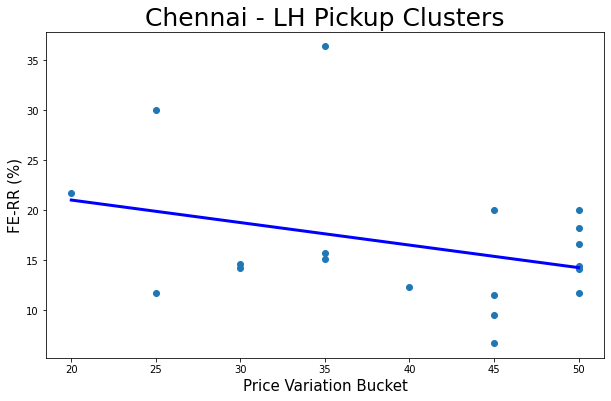

In [234]:
max_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).max()
max_price_variation = max_price_variation + (5 - max_price_variation % 5)
min_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).min()
min_price_variation = min_price_variation - (5 - abs(min_price_variation) % 5)

bin_price_variation = list(range(min_price_variation, max_price_variation + 1, 5))
bin_price_variation_label = list(range(min_price_variation, max_price_variation, 5))
shortlisted_routes_fare_estimates['price_variation_bucket'] = pd.cut(shortlisted_routes_fare_estimates[
                                                                         'price_variation'],
                                                                     bins=bin_price_variation,
                                                                     include_lowest=True,
                                                                     labels=bin_price_variation_label).astype(int)

rate_card_avg = shortlisted_routes_fare_estimates.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    mean_rate_card_avg=pd.NamedAgg('price_variation', 'mean')).reset_index()

print(rate_card_avg)

#avg_ferr_calc = shortlisted_routes_fare_estimates[shortlisted_routes_fare_estimates['price_variation'] == 0]


#all_categories = shortlisted_routes_fare_estimates[['week_period','time_period']].unique()


rc_price_decrease = pd.DataFrame(columns=[
    'rc_price_decrease_pct', 'fe_rr_uplift'])

category_data = merged_fe2rr_rc_data.copy()

print(category_data)

pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')
).reset_index().sort_values(['total_num_fe'])

pv_data['fe_rr_ratio'] = (
        (100 * pv_data['gross_converted']) / pv_data['total_num_fe']
)

pv_data = pv_data[(pv_data['fe_rr_ratio'] != 0) & (
        pv_data['fe_rr_ratio'] != 100) & (
    pv_data['price_variation_bucket'] >= -50) & (pv_data['price_variation_bucket'] <= 50)].reset_index(drop=True)

print('Input data to the model...')

print(pv_data.shape)

pv_data = pv_data.sort_values(['price_variation_bucket']).reset_index(drop=True)
rate_card_mean = rate_card_avg['mean_rate_card_avg']
fe_rr_mean = fe_rr_avg['fe_rr_ratio']

X = pv_data['price_variation_bucket'].values
Y = pv_data['fe_rr_ratio'].values
m = len(X)
X = X.reshape((m, 1))

reg = LinearRegression()
reg = reg.fit(X, Y)
Y_pred = reg.predict(X)

X1 = [[0], [-2], [-4], [-6], [-8], [-10], [-12], [-13], [-14], [-16], [-18]]
Y1_pred = reg.predict(X1)
Y1_recommend = Y1_pred - Y1_pred[0]

get_index = list(Y1_recommend <= (required_fe_rr_uplift + 1))
max_index = 0
for idx, val in enumerate(get_index):
    if val == True:
        max_index = idx

rc_price_decrease = rc_price_decrease.append({
    'discount_percent': abs(X1[max_index][0]),
    'fe_rr_uplift': round(Y1_recommend[max_index], 2)},
    ignore_index=True)

mse_model = mse(Y, Y_pred)
rmse = np.sqrt(mse_model)
r2_score = reg.score(X, Y)

print(
    '--------------------------------------------------------------------------------------------------------')
plt.rcParams['figure.figsize'] = [10, 6]
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='blue', linewidth=3)
plt.title(city + ' - LH Pickup Clusters', fontsize=25)
plt.xlabel('Price Variation Bucket', fontsize=15)
plt.ylabel('FE-RR (%)', fontsize=15)
print('RMSE: ' + str(rmse))
print('R2_Score: ' + str(r2_score))
print('')
print('Avg FE-RR (%): ' + str(fe_rr_mean))
print('')
print('Rate Card Price Decrease Discount(%): ' + str(X1))
print('')
print('FE-RR(%): ' + str(Y1_pred))
print('')
print('Delta FE-RR(%): ' + str(Y1_recommend))
print(
    '--------------------------------------------------------------------------------------------------------')

plt.show()

-----